참고 : https://zero-ai.tistory.com/62

In [1]:
import torch

print(f"CUDA 사용 가능 여부: {torch.cuda.is_available()}")
print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
print(f"CUDA 버전: {torch.version.cuda}")
print(f"PyTorch 버전: {torch.version}")
print(f"bf16 지원 여부: {torch.cuda.is_bf16_supported()}")
print(f"현재 GPU : {torch.cuda.current_device()}")

CUDA 사용 가능 여부: True
GPU 이름: NVIDIA GB10
CUDA 버전: 13.0
PyTorch 버전: <module 'torch.version' from '/home/vsc/LLM_TUNE/QA-FineTune/.venv/lib/python3.12/site-packages/torch/version.py'>
bf16 지원 여부: True
현재 GPU : 0


/home/vsc/LLM_TUNE/QA-FineTune/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


In [2]:
import torch

def check_vram_torch():
    # 1. 현재 텐서들이 실제로 점유하고 있는 메모리
    allocated = torch.cuda.memory_allocated() / (1024**3)
    # 2. PyTorch가 OS로부터 할당받아 캐싱하고 있는 전체 메모리
    reserved = torch.cuda.memory_reserved() / (1024**3)
    # 3. 해당 GPU의 전체 용량
    total = torch.cuda.get_device_properties(0).total_memory / (1024**3)

    print(f"--- GPU Memory Status ---")
    print(f"Allocated: {allocated:.2f} GB")
    print(f"Reserved:  {reserved:.2f} GB")
    print(f"Total:     {total:.2f} GB")
    print(f"Free (in Reserved): {reserved - allocated:.2f} GB")
    print(f"--------------------------")

check_vram_torch()

--- GPU Memory Status ---
Allocated: 0.00 GB
Reserved:  0.00 GB
Total:     119.69 GB
Free (in Reserved): 0.00 GB
--------------------------


In [1]:
from datasets import Dataset
import pandas as pd
import glob

file_path = glob.glob("./data/*.xlsx")
df = pd.read_excel(file_path[0])
dataset = Dataset.from_pandas(df)

print(dataset)
print(dataset[0])

Dataset({
    features: ['FAQ', 'TITLE', 'DES'],
    num_rows: 110
})
{'FAQ': 1, 'TITLE': '회원증을 대리발급 할 수 있나요?', 'DES': '회원증 대리발급은 만14세 미만 아동, 만65세 이상 어르신, 장애인, 임산부만 가능하며 아래 구비서류를 지참하여 대리인이 방문 시 대리발급이 가능합니다.\n\n· 대상 : 만14세 미만 아동, 만65세 이상 어르신, 장애인, 임산부\n· 구비서류\n\xa0 - 공통 : ①위임자 신분증, ②피위임자(대리인) 신분증\n\xa0 - 장애인 : 장애인 복지카드 또는 장애인 증명서\n\xa0 - 임신부 : 산모수첩 / 산모 : 주민등록등본(출산 후 12개월까지)\n· 방법 : 홈페이지 회원가입 후 위 항목의 해당하는 구비서류를 지참하여 피위임자(대리인)이 도서관 방문'}


In [2]:
# 데이터 증강을 위해 로컬 EXAONE-3.5-7.8B-Instruct 모델 사용
# Instruct 모델 : 명령 / 지시를 내리는 모델
# 일반 LLM 모델 : 텍스트를 자연스럽게 이어가는 데 초점을 둔 모델

In [2]:
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig, 
    TrainingArguments,
)
from datasets import Dataset
import os, torch, json, wandb, subprocess
from sklearn.model_selection import train_test_split
import torch.nn as nn
from vllm import LLM, SamplingParams

In [4]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)

MODEL_NAME = "/home/vsc/LLM/model/Exaone-3.5-32B-Instruct"

In [5]:
# vLLM의 경우 pipeline 방식에 비해 추론 속도가 빠르며, 메모리 안정성이 더 높음 + continuous batching으로 한 번에 여러 응답을 받을 수 있 음

In [8]:
def generate_augmented_data(faq_content):
    system_message = (
        "당신은 도서관 FAQ 데이터를 바탕으로 자연스러운 대화형 학습 데이터를 생성하는 전문가입니다.\n"
        "제공된 정보를 분석하여 다음 4가지 유형의 데이터를 생성하세요. 각 유형별로 최소 3개씩, 총 12개의 예시를 만드세요.\n\n"
        "이때 판단이 쉬운 예시와 보통, 어려운 예시 총 3가지 상황을 가정하세요."
        
        "### [답변 가이드라인]\n"
        "1. **label: 'yes' (긍정 확인)**\n"
        "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
        "   - 문구: '네, 가능합니다! 도서관 규정에 따르면...'\n"
        "   - 활용: 질문의 조건이 FAQ와 일치할 때 사용.\n"
        "2. **label: 'no' (부정/제한)**\n"
        "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
        "   - 문구: '죄송하지만 어렵습니다. 그 이유는...'\n"
        "   - 활용: 질문의 조건이 FAQ 규정에 어긋날 때 사용. '사실과 다르다'는 표현 대신 '규정상 어렵다'를 사용하세요.\n"
        "3. **label: 'info' (단순 정보 제공)**\n"
        "   - 질문이 '~은 무엇인가요?', '~은 어떻게 하나요?', '~은 언제인가요?'처럼 절차/시간/방법을 물을 때 사용하세요.\n"
        "   - 문구: '문의하신 내용에 대해 안내해 드리겠습니다. 관련 서류는...'\n"
        "   - 활용: 네/아니오 판단이 아닌 정보 질문에 사용.\n"
        "4. **label: 'false' (판단 불가)**\n"
        "   - 문구: '죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.'\n"
        "   - 활용: FAQ에 없는 내용이거나 질문이 모호할 때 사용.\n\n"
        
        "모든 답변은 실제 도서관 사서가 방문객에게 설명하듯 친절하고 자연스러운 문장으로 작성하세요."
        "판단 불가의 경우 문구 외에 다른 문장은 생성하지 마세요."
        "JSON 답변 외에 다른 문장은 일체 생성하지 마세요."
    )

    # 사용자가 정의한 user_content
    user_content = f"""
    [도서관 FAQ 정보]
    {faq_content}
    
    위 정보를 바탕으로 질문과 답변이 논리적으로 완벽하게 이어지는 JSON 데이터를 생성하세요.
    
    [출력 예시]:
    [
      {{"question": "임산부인데 남편이 대신 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함됩니다.", "label": "yes"}},
      {{"question": "성인 직장인인데 친구가 대신 가도 되나요?", "answer": "죄송하지만, 해당 조건으로는 대리 발급이 어렵습니다. 대리 발급은 아동, 어르신, 장애인, 임산부로 대상이 제한되어 있기 때문입니다.", "label": "no"}},
      {{"question": "장애인 대리 발급 시 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 장애인 복지카드 또는 장애인 증명서를 지참하시면 됩니다.", "label": "info"}},
      {{"question": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", "label": "false"}}
    ]
    """
    
    chat_completion = client.chat.completions.create(
        model=MODEL_NAME,
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_content},
        ],
        temperature=0.7,   # 창의성 조절 (0.0 ~ 2.0)
        max_tokens=2048,   # 생성할 최대 토큰 수
        top_p=0.9,         # 답변의 다양성 조절
    )

    response = chat_completion.choices[0].message.content
    
    return response

In [9]:
import json
import re
import pandas as pd

def parse_generated_json(response_text):
    try:
        # 1. 마크다운 코드 블록 제거 (```json ... ``` 사이의 내용만 추출)
        json_pattern = re.compile(r"```json\s*(.*?)\s*```", re.DOTALL)
        match = json_pattern.search(response_text)
        
        if match:
            json_str = match.group(1)
        else:
            json_str = response_text.strip()
            
        # 2. JSON 문자열을 파이썬 리스트로 변환
        data_list = json.loads(json_str)
        return data_list
    except Exception as e:
        print(f"파싱 에러 발생: {e}")
        return []

In [13]:
from tqdm import tqdm

output_file = "augmented_library_faq_quant_EXAONE_32B_vLLM.jsonl"

with open(output_file, "a", encoding="utf-8") as f:
    for i, row in enumerate(tqdm(dataset.select(range(108, len(dataset))), desc="Data Augmentation")):
        # 1. 모델로부터 텍스트 생성
        raw_output = generate_augmented_data(row["DES"])
        
        # 2. 파싱하여 리스트로 변환
        parsed_list = parse_generated_json(raw_output)
        
        for item in parsed_list:
            item['faq'] = row['FAQ'] 
            item['title'] = row['TITLE'] 
            item['DES'] = row['DES']
            
            f.write(json.dumps(item, ensure_ascii=False) + "\n")
            
print(f"✅ 총 {len(df)}개의 학습 데이터 생성 완료!")

Data Augmentation: 100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.78s/it]

✅ 총 110개의 학습 데이터 생성 완료!


In [5]:
# wanDB & weave + W&B artifact 셋업

In [3]:
import json
import asyncio, aiofiles
import wandb
from tqdm.asyncio import tqdm as async_tqdm
from openai import AsyncOpenAI
import weave

PROJECT_NAME="library-faq-augmentation"

config = {
    "model": "/home/vsc/LLM/model/Exaone-3.5-32B-Instruct",
    "quantization": "None",
    "engine": "vLLM-v1",
    "temperature": 0.7,
    "max_tokens" : 2048,
    "top_p" : 0.7,
    "max_model_len": 16384,
    "gpu_util": 0.9
}

wandb.init(project=PROJECT_NAME, name="EXAONE-32B-vLLM-Run")
weave.init(PROJECT_NAME)
sample_table = wandb.Table(columns=["row_id", "question", "answer", "label"])
client = AsyncOpenAI(base_url="http://localhost:8000/v1", api_key="EMPTY")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/vsc/.netrc.
wandb: Currently logged in as: jungseonglian (uailab-unist_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Initializing weave.
weave: Logged in as Weights & Biases user: jungseonglian.
weave: View Weave data at https://wandb.ai/uailab-unist_/library-faq-augmentation/weave
[2026-02-09 00:18:59] INFO init_message.py:174: Logged in as Weights & Biases user: jungseonglian.
View Weave data at https://wandb.ai/uailab-unist_/library-faq-augmentation/weave


In [4]:
@weave.op()
async def generate_augmented_data_async(faq_content, row_id, config) :
    system_message = (
    "당신은 도서관 FAQ 데이터를 바탕으로 자연스러운 대화형 학습 데이터를 생성하는 전문가입니다.\n"
    "제공된 정보를 분석하여 다음 4가지 유형의 데이터를 생성하세요. 각 유형별로 최소 3개씩, 총 12개의 예시를 만드세요.\n\n"
    "이때 판단이 쉬운 예시와 보통, 어려운 예시 총 3가지 상황을 가정하세요."
    
    "### [답변 가이드라인]\n"
    "1. **label: 'yes' (긍정 확인)**\n"
    "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
    "   - 문구: '네, 가능합니다! 도서관 규정에 따르면...'\n"
    "   - 활용: 질문의 조건이 FAQ와 일치할 때 사용.\n"
    "2. **label: 'no' (부정/제한)**\n"
    "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
    "   - 문구: '죄송하지만 어렵습니다. 그 이유는...'\n"
    "   - 활용: 질문의 조건이 FAQ 규정에 어긋날 때 사용. '사실과 다르다'는 표현 대신 '규정상 어렵다'를 사용하세요.\n"
    "3. **label: 'info' (단순 정보 제공)**\n"
    "   - 질문이 '~은 무엇인가요?', '~은 어떻게 하나요?', '~은 언제인가요?'처럼 절차/시간/방법을 물을 때 사용하세요.\n"
    "   - 문구: '문의하신 내용에 대해 안내해 드리겠습니다. 관련 서류는...'\n"
    "   - 활용: 네/아니오 판단이 아닌 정보 질문에 사용.\n"
    "4. **label: 'false' (판단 불가)**\n"
    "   - 문구: '죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.'\n"
    "   - 활용: FAQ에 없는 내용이거나 질문이 모호할 때 사용.\n\n"
    
    "모든 답변은 실제 도서관 사서가 방문객에게 설명하듯 친절하고 자연스러운 문장으로 작성하세요."
    "판단 불가의 경우 문구 외에 다른 문장은 생성하지 마세요."
    "JSON 답변 외에 다른 문장은 일체 생성하지 마세요."
    )

    # 사용자가 정의한 user_content
    user_content = f"""
        [도서관 FAQ 정보]
        {faq_content}
        
        위 정보를 바탕으로 질문과 답변이 논리적으로 완벽하게 이어지는 JSON 데이터를 생성하세요.
        
        [출력 예시]:
        [
          {{"question": "임산부인데 남편이 대신 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함됩니다.", "label": "yes"}},
          {{"question": "성인 직장인인데 친구가 대신 가도 되나요?", "answer": "죄송하지만, 해당 조건으로는 대리 발급이 어렵습니다. 대리 발급은 아동, 어르신, 장애인, 임산부로 대상이 제한되어 있기 때문입니다.", "label": "no"}},
          {{"question": "장애인 대리 발급 시 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 장애인 복지카드 또는 장애인 증명서를 지참하시면 됩니다.", "label": "info"}},
          {{"question": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", "label": "false"}}
        ]
    """
    
    try :
        chat_completion = await client.chat.completions.create(
            model=config["model"],  # MODEL_NAME 대신 config["model"] 사용
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_content},
            ],
            temperature=config["temperature"],
            max_tokens=config["max_tokens"],
            top_p=config["top_p"],
        )

        raw_output = chat_completion.choices[0].message.content

        if "```json" in raw_output:
            raw_output = raw_output.split("```json")[1].split("```")[0].strip()
        elif "```" in raw_output:
            raw_output = raw_output.split("```")[1].split("```")[0].strip()

        print(raw_output)

        parsed_list = json.loads(raw_output)
        return parsed_list

    except Exception as e :
        print(f"Error at {row_id} : {e}")
        return []
    
async def process_dataset(dataset) :
    output_file = "async_library_faq_quant_EXAONE_32B_vLLM_async.jsonl"
    async with aiofiles.open(output_file, "w", encoding="utf-8") as f:
        semaphore = asyncio.Semaphore(64)
        lock = asyncio.Lock()

        async def semaphore_task(row, idx) :
            async with semaphore :
                results = await generate_augmented_data_async(row["DES"], idx, config)
                
                if results:  # 결과가 있을 때만 쓰기
                    async with lock:

                        for item in results[:2]:
                            sample_table.add_data(idx, item.get("question"), item.get("answer"), item.get("label"))

                        for item in results:
                            item.update({
                                'faq': row['FAQ'], 
                                'title': row['TITLE'], 
                                'DES': row['DES']
                            })
                            await f.write(json.dumps(item, ensure_ascii=False) + "\n")
                
                return len(results)
            return 0

        tasks = [semaphore_task(row, i) for i, row in enumerate(dataset)]

        total_created = 0

        for coro in async_tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="데이터 생성"):
            total_created += await coro

    wandb.log({"augmented_samples": sample_table})
    print(f"✅ 생성 완료! 총 {total_created}개의 데이터가 저장되었습니다.")

    return output_file

In [5]:
outputfile_name = await process_dataset(dataset)
artifact = wandb.Artifact(f"{config['model']}_{wandb.run.id}", type='dataset')
artifact.add_file(outputfile_name)
wandb.log_artifact(artifact)
wandb.finish()

데이터 생성:   0%|                                                                 | 0/110 [00:00<?, ?it/s]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd5-e315-7b40-87ab-18d79c9339ef
[2026-02-09 00:19:13] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd5-e315-7b40-87ab-18d79c9339ef
weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd5-e30e-7b76-ba58-f09545f0b19f
[2026-02-09 00:19:13] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd5-e30e-7b76-ba58-f09545f0b19f
weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd5-e314-7424-8878-d7c1ef284f14
weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd5-e308-778c-9297-aa08fd420a78
[2026-02-09 00:19:13] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd5-e314-7424-8878-d7c1ef284f14
weave: 🍩 htt

[
  {"question": "스마트도서관에서 책을 어떻게 검색할 수 있나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 스마트도서관 도서검색 탭을 이용하시면 원하시는 책을 쉽게 찾으실 수 있습니다.", 
   "label": "info"},

  {"question": "도서관 웹사이트에서도 도서 검색이 가능한가요?", 
   "answer": "네, 가능합니다! 도서관 웹사이트에도 도서 검색 기능이 마련되어 있습니다.", 
   "label": "yes"},

  {"question": "스마트도서관에서 검색 가능한 자료는 어떤 것들이 있나요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},

  {"question": "스마트도서관에서 찾은 책은 바로 대출할 수 있나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 스마트도서관에서 검색한 책은 온라인으로 예약 후 도서관 방문 시 대출하실 수 있습니다.", 
   "label": "info"},

  {"question": "스마트도서관에서 검색한 책의 위치를 알 수 있나요?", 
   "answer": "네, 가능합니다! 스마트도서관 시스템에서 검색한 책의 위치 정보를 확인하실 수 있습니다.", 
   "label": "yes"},

  {"question": "스마트도서관 이용 시간은 언제까지인가요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},

  {"question": "스마트도서관 이용에 필요한 회원증은 어떻게 발급받을 수 있나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 회원증 발급은 도서관에 직접 방문하여 신청하시면 됩니다.", 
   "label": "info"}
]


데이터 생성:   2%|█                                                      | 2/110 [03:38<2:46:54, 92.73s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd9-37ca-7a63-a957-a13602b00605
[2026-02-09 00:22:51] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd9-37ca-7a63-a957-a13602b00605


[
  {"question": "도서관이 언제 다시 문을 열 예정인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 리모델링 중으로 2026년 10월 이후에 개관 예정입니다.", 
   "label": "info"},
  {"question": "2025년에 도서관 이용이 가능한가요?",
   "answer": "죄송하지만 어렵습니다. 도서관 리모델링이 2026년 10월까지 예정되어 있어 2025년에는 이용이 불가능합니다.",
   "label": "no"},
  {"question": "리모델링 기간 동안 도서 대출은 어떻게 되나요?",
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 리모델링 기간 동안의 도서 대출 정책은 추후 공지될 예정입니다.",
   "label": "false"},
  {"question": "새로운 도서관 건물은 어떤 모습일까요?",
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 새로운 도서관의 디자인 및 시설에 대한 자세한 정보는 추후 공개될 예정입니다.",
   "label": "false"},
  {"question": "도서관 개관일은 정확히 언제인가요?", 
   "answer": "문의하신 내용에 대해 정확한 날짜는 아직 확정되지 않았습니다. 2026년 10월 이후 개관 예정이며, 정확한 날짜는 추후 공지될 예정입니다.", 
   "label": "info"},
  {"question": "리모델링 중에도 일부 공간은 이용 가능한가요?",
   "answer": "죄송하지만 어렵습니다. 현재 제공된 정보에서는 리모델링 기간 동안 일부 공간 이용 가능 여부에 대한 정보가 없습니다.",
   "label": "false"},
  {"question": "도서관 개관 전에 미리 예약할 수 있나요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습

데이터 생성:   3%|█▌                                                     | 3/110 [03:49<1:38:52, 55.45s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd9-6314-7543-99a2-dca9ff34d8fb
[2026-02-09 00:23:02] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dd9-6314-7543-99a2-dca9ff34d8fb


[
  {"question": "원당복합커뮤니티센터 도서관은 언제 개관하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 원당복합커뮤니티센터 내 도서관은 2028년 10월 이후 개관 예정입니다.", "label": "info"},
  {"question": "2028년 10월 이전에 도서관 이용이 가능한가요?", "answer": "죄송하지만 어렵습니다. 현재 계획에 따르면 2028년 10월 이후에 개관 예정이므로 그 이전에는 이용이 불가능합니다.", "label": "no"},
  {"question": "도서관 개관 예정일이 변경될 가능성은 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 개관 예정일은 추가적인 공지가 있을 때까지 변경 가능성에 대해 명확히 말씀드리기 어렵습니다.", "label": "false"},
  {"question": "2028년 10월 이후 개관 예정이라면, 개관 첫 주에 어떤 특별 이벤트가 계획되어 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 개관 이벤트에 대한 자세한 계획은 추후 별도로 공지될 예정입니다.", "label": "false"},
  {"question": "도서관 개관 후 이용 시간은 어떻게 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 하지만 현재로서는 개관 후의 구체적인 이용 시간은 아직 확정되지 않았습니다. 개관 시점에 맞춰 자세한 시간이 공지될 예정입니다.", "label": "info"},
  {"question": "도서관 개관 전에 미리 회원 등록을 할 수 있나요?", "answer": "죄송하지만 어렵습니다. 현재로서는 개관 전에 회원 등록을 받지 않고 있습니다. 개관 시점에 맞춰 등록 절차가 시작될 예정이니 참고 부탁드립니다.", "label": "no"},
  {"question": "도서관 개관 후 어린이 도서관 공간이 마련되어 

데이터 생성:   4%|██                                                     | 4/110 [04:41<1:35:46, 54.21s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-2f6c-73a8-83b7-3d51cad7ecaf
[2026-02-09 00:23:55] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-2f6c-73a8-83b7-3d51cad7ecaf


[
  {
    "question": "스마트도서관에서 빌린 책을 다른 스마트도서관 기기로 반납할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정에 따르면 스마트도서관 도서는 반드시 대출한 기기로만 반납해야 합니다. 상호대차나 책누리 시스템을 통한 반납은 불가능합니다.",
    "label": "no"
  },
  {
    "question": "대출한 스마트도서관 기기가 고장났습니다. 다른 기기로 반납할 수 있는 방법이 있나요?",
    "answer": "죄송하지만 현재 규정상 다른 기기로의 반납은 불가능합니다. 기기 고장 시에는 도서관에 연락하여 도움을 요청하시는 것이 좋습니다.",
    "label": "no"
  },
  {
    "question": "스마트도서관에서 빌린 책을 반납 기한을 넘겼습니다. 다른 스마트도서관 기기에서 연체료를 납부하고 반납할 수 있나요?",
    "answer": "네, 반납은 대출한 기기에서만 가능하지만, 연체료 납부는 도서관 카운터에서 가능합니다. 반납 기한을 넘긴 경우, 먼저 연체료를 납부하신 후 원래 대출한 스마트도서관 기기로 책을 반납해 주시기 바랍니다.",
    "label": "info"
  },
  {
    "question": "스마트도서관 도서를 다른 도서관 시스템(예: 일반 도서관)으로 반납할 수 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 스마트도서관 도서는 특정 시스템 내에서만 관리되기 때문에 일반 도서관 시스템으로의 반납은 불가능합니다.",
    "label": "false"
  },
  {
    "question": "대출한 스마트도서관 기기가 멀리 떨어져 있어서 반납이 어렵습니다. 예외적으로 다른 기기로 반납할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 규정상 스마트도서관 도서는 반드시 대출한 기기로만 반납해야 합니다. 예외적인 상황이라도 규정은 동일하게 

데이터 생성:   5%|██▌                                                    | 5/110 [05:04<1:15:10, 42.96s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-8947-702a-a0c6-f2a020c6df90
[2026-02-09 00:24:18] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-8947-702a-a0c6-f2a020c6df90


[
    {"question": "도서관의 정확한 위치를 알려주세요.", "answer": "네, 도서관은 고양시 일산서구 일산로 689(대화동)에 위치해 있습니다.", "label": "info"},
    {"question": "도서관에 전화로 문의할 수 있는 번호는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 전화번호는 031-8075-9130입니다.", "label": "info"},
    {"question": "주말에도 도서관이 열려 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 주말 운영 시간을 정확히 확인하기 어렵습니다. 자세한 시간은 도서관 홈페이지를 참조해 주시거나 직접 전화로 문의해 주시기 바랍니다.", "label": "false"},
    {"question": "임산부의 경우 남편이 도서 대출을 대신 받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 대출이 허용됩니다.", "label": "yes"},
    {"question": "일반 성인이 친구를 대신해 도서 대출을 받을 수 있나요?", "answer": "죄송하지만 어렵습니다. 대리 대출은 특정 조건 하에만 허용되며, 일반 성인의 경우 해당 조건에 포함되지 않습니다.", "label": "no"},
    {"question": "도서관에서 가장 많이 이용되는 서비스는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관에서 가장 많이 이용되는 서비스는 도서 대출과 열람실 이용입니다. 추가로 다양한 문화 프로그램도 인기가 많습니다.", "label": "info"},
    {"question": "도서관에서 특정 책을 찾을 때 도움을 받을 수 있나요?", "answer": "네, 가능합니다! 도서관 사서에게 도움을 청하면 도서 검색과 위치 안내를 받으실 수 있습니다.", "label": "yes"},
    {"questi

데이터 생성:   5%|███                                                      | 6/110 [05:08<51:15, 29.57s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-9744-7bd9-b3dd-3291765f65c5
[2026-02-09 00:24:21] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-9744-7bd9-b3dd-3291765f65c5


[
  {"question": "도서관은 언제 다시 문을 열 예정인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 현재 리모델링 중으로 2026년 10월 이후에 개관 예정입니다.", 
   "label": "info"},
  {"question": "2026년 10월 이전에 임시 도서관이 운영될 예정인가요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},
  {"question": "리모델링 중인 공간은 어디인가요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},
  {"question": "2026년 10월 이후 개관하면 새로운 시설이 추가될 예정인가요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},
  {"question": "도서관 개관 예정일이 변경될 가능성은 없나요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},
  {"question": "리모델링 계획에 대한 자세한 내용은 어디에서 확인할 수 있나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 자세한 리모델링 계획은 도서관 홈페이지에서 확인하실 수 있습니다.", 
   "label": "info"},
  {"question": "도서관 개관 후 회원증 발급은 어떻게 이루어지나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 개관 후에는 기존과 동일한 절차로 회원증 발급이 이루어질 예정입니다. 자세한 내용은 개관 안내를 참고해주세요.", 
   "label": "info"},
  {"question": "리모델링 기간 동

데이터 생성:   6%|███▋                                                     | 7/110 [05:17<39:20, 22.92s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-bb4e-704e-bd80-587013a046b0
[2026-02-09 00:24:30] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-bb4e-704e-bd80-587013a046b0


[
  {"question": "도서관의 정확한 주소가 어디인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 정확한 주소는 고양시 덕양구 고양대로 1937 (동산동)입니다.", "label": "info"},
  {"question": "도서관에 전화로 문의할 수 있는 번호가 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 전화번호는 031-8075-9305입니다.", "label": "info"},
  {"question": "주말에도 도서관이 열려 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 별도로 확인이 필요합니다.", "label": "false"},
  {"question": "아이를 대신해서 부모님이 도서 대출을 할 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 아동의 경우 부모님이나 법정대리인이 대리로 도서 대출을 할 수 있습니다.", "label": "yes"},
  {"question": "65세 이상 노인이 아닌데, 가족이 도서 대출을 대신해줄 수 있나요?", "answer": "죄송하지만 어렵습니다. 대리 대출은 주로 아동, 어르신, 장애인, 임산부 등 특정 조건을 충족하는 경우에만 허용됩니다.", "label": "no"},
  {"question": "도서관에서 도서 대출을 위한 신분증으로 어떤 것들을 인정하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 주민등록증, 운전면허증, 여권 등 공식적인 신분을 확인할 수 있는 서류가 인정됩니다.", "label": "info"},
  {"question": "도서관이 공휴일에도 운영되는지 알고 싶어요.", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 공휴일 운영 여부는 별도로 확인이 필요합니다.", "label": "false"},
  

데이터 생성:   7%|████▏                                                    | 8/110 [05:20<28:01, 16.49s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-c5e6-71e1-98d0-c61a29eb691d
[2026-02-09 00:24:33] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3dda-c5e6-71e1-98d0-c61a29eb691d


[
  {"question": "디지털 자료실이 주말에도 열려 있나요?", "answer": "네, 가능합니다! 디지털 자료실의 운영 시간은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.", "label": "yes"},
  {"question": "어린이 자료실에서는 밤 늦게까지 책을 읽을 수 있을까요?", "answer": "죄송하지만 어렵습니다. 어린이 자료실의 운영 시간은 평일과 주말 모두 오후 6시까지입니다.", "label": "no"},
  {"question": "열람실이 동절기에는 언제부터 열려 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 동절기에는 열람실이 오전 8시부터 문을 엽니다.", "label": "info"},
  {"question": "주말에 연속간행물실에서 오후 7시에 자료를 빌릴 수 있을까요?", "answer": "죄송합니다. 연속간행물실은 주말에도 오후 6시까지만 운영되므로 그 이후에는 이용이 어렵습니다.", "label": "no"},
  {"question": "종합자료실에서 가장 늦게까지 이용 가능한 시간은 언제인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 종합자료실은 평일에는 오후 10시까지 이용 가능합니다.", "label": "info"},
  {"question": "어린이 자료실이 평일에 오후 7시 이후에도 열려 있나요?", "answer": "죄송하지만 어렵습니다. 어린이 자료실의 운영 시간은 평일과 주말 모두 오후 6시까지입니다.", "label": "no"},
  {"question": "디지털 자료실에서 주말에 이용 가능한 최대 시간은 언제까지인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 디지털 자료실의 주말 이용 시간은 오후 6시까지입니다.", "label": "info"},
  {"question": "열람실의 하절기와 동절기 운영 시간 차이가 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 

데이터 생성:   8%|████▋                                                    | 9/110 [05:35<27:13, 16.17s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-0265-7f12-8c1f-b8809c420ce5
[2026-02-09 00:24:49] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-0265-7f12-8c1f-b8809c420ce5


[
  {"question": "행신도서관 열람실 이용 시간은 어떻게 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 행신도서관의 열람실은 하절기(3월~10월)에는 오전 7시부터 밤 11시까지, 동절기(11월~2월)에는 오전 8시부터 밤 11시까지 이용 가능합니다.", "label": "info"},
  {"question": "웹회원도 열람실을 이용할 수 있나요?", "answer": "네, 가능합니다! 웹회원과 도서관회원 모두 열람실 이용이 가능합니다. 각 도서관의 좌석발급기를 통해 좌석을 배정받으실 수 있습니다.", "label": "yes"},
  {"question": "삼송도서관에 열람실이 있나요?", "answer": "네, 가능합니다! 삼송도서관은 열람실을 갖추고 있어 이용하실 수 있습니다.", "label": "yes"},
  {"question": "식사도서관 열람실 이용이 가능한 날짜가 따로 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 열람실 이용 가능일에 대한 특별한 제한 사항은 명시되어 있지 않습니다.", "label": "false"},
  {"question": "좌석 발급은 어떻게 받나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 각 도서관의 좌석발급기를 통해 직접 좌석을 배정받으실 수 있습니다.", "label": "info"},
  {"question": "가좌도서관은 열람실이 있나요?", "answer": "네, 가능합니다! 가좌도서관도 열람실을 갖추고 있어 이용하실 수 있습니다.", "label": "yes"},
  {"question": "동절기에 모든 도서관 열람실이 같은 시간에 열려 있나요?", "answer": "네, 가능합니다! 동절기(11월~2월)에는 모든 열람실이 오전 8시부터 밤 11시까지 동일한 시간에 운영됩니다.", "label": "yes"},
  {"question": "도서관 회원이 아닌 사람

데이터 생성:   9%|█████                                                   | 10/110 [05:38<19:57, 11.98s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-0c7e-7734-a837-d65d2ad84250
[2026-02-09 00:24:51] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-0c7e-7734-a837-d65d2ad84250


[
  {"question": "책을 반납 연기할 수 있나요?", "answer": "네, 가능합니다! 홈페이지의 '나의 도서관' 메뉴에서 1회에 한해 7일 동안 반납을 연기하실 수 있습니다.", "label": "yes"},
  {"question": "이미 연기한 책을 또 연기할 수 있을까요?", "answer": "죄송하지만 어렵습니다. 규정상 한 번 연기한 도서는 추가 연기가 불가능합니다.", "label": "no"},
  {"question": "연체되면 얼마나 대출이 정지되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 연체된 일수만큼 대출이 정지됩니다. 가장 긴 연체일이 적용되므로 주의가 필요합니다.", "label": "info"},
  {"question": "다른 도서관에서도 연체 기록이 적용되나요?", "answer": "네, 그렇습니다. 고양시 내의 모든 도서관에서 연체 기록이 공유되므로 한 곳에서 연체되면 다른 도서관에서도 대출이 제한될 수 있습니다.", "label": "yes"},
  {"question": "연체 기간이 짧을 때도 대출 정지가 적용되나요?", "answer": "네, 연체 기간이 짧더라도 연체된 일수만큼 대출이 정지됩니다. 가장 긴 연체일이 적용되므로 작은 연체라도 주의해야 합니다.", "label": "yes"},
  {"question": "대출 정지 기간이 끝나면 바로 대출이 가능한가요?", "answer": "네, 대출 정지 기간이 정확히 끝나는 날부터 다시 대출이 가능합니다. 정지 기간이 끝나면 자동으로 대출 자격이 회복됩니다.", "label": "yes"},
  {"question": "연체 기록은 얼마나 유지되나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 연체 기록이 정확히 얼마나 유지되는지에 대한 구체적인 기간을 확인하기 어렵습니다. 도서관 규정을 직접 확인하시는 것이 좋습니다.", "label": "false"},
  {"question": "홈페이지

데이터 생성:  10%|█████▌                                                  | 11/110 [05:41<15:32,  9.41s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-1a90-7748-a92f-5b4092ce2055
[2026-02-09 00:24:55] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-1a90-7748-a92f-5b4092ce2055


[
  {"question": "어린이자료실이 주말에도 열려 있나요?", "answer": "네, 가능합니다! 어린이자료실은 주말에도 09:00부터 18:00까지 운영됩니다.", "label": "yes"},
  {"question": "책이음1실이 주말에도 밤 10시까지 열려 있을까요?", "answer": "죄송하지만 어렵습니다. 책이음1실은 주말에는 18:00까지 운영됩니다. 밤 10시까지는 평일에만 이용 가능합니다.", "label": "no"},
  {"question": "종합자료실의 평일 운영 시간은 언제부터 언제까지인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 종합자료실은 평일에는 오전 9시부터 오후 10시까지 운영됩니다.", "label": "info"},
  {"question": "디지털자료실에서 컴퓨터를 사용할 수 있는 시간이 주말에는 어떻게 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 책이음2(디지털자료실)은 주말에는 오전 9시부터 오후 6시까지 이용 가능합니다.", "label": "info"},
  {"question": "어린이자료실이 평일에 몇 시까지 열려 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 평일에는 오전 9시부터 오후 6시까지 운영됩니다.", "label": "info"},
  {"question": "주말에 연속간행물실을 이용할 수 있나요?", "answer": "네, 가능합니다! 책이음1실(연속간행물실)은 주말에도 오전 9시부터 오후 10시까지 열려 있습니다.", "label": "yes"},
  {"question": "도서관에서 가장 늦게까지 열려 있는 공간은 어디인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 종합자료실이 평일에는 가장 늦게까지 운영되며, 오후 10시까지 이용 가능합니다.", "label": "info"},
  {"question": "어린이자료실과 책이음2실의 주말

데이터 생성:  11%|██████                                                  | 12/110 [05:44<11:50,  7.25s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-237c-7c8f-83d4-9acec6ed5064
[2026-02-09 00:24:57] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-237c-7c8f-83d4-9acec6ed5064


[
  {"question": "원당복합커뮤니티센터 도서관은 언제 개관할 예정인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 원당복합커뮤니티센터 내 도서관은 2028년 10월 이후에 개관 예정입니다.", "label": "info"},
  {"question": "2027년에 도서관 이용이 가능할까요?", "answer": "죄송하지만 어렵습니다. 현재 계획에 따르면 2028년 10월 이후에 개관 예정이므로 2027년에는 이용이 불가능합니다.", "label": "no"},
  {"question": "도서관 개관 예정일이 변경될 가능성은 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 개관 예정일은 추가적인 공지가 있을 때까지 변동 가능성을 고려해야 합니다.", "label": "false"},
  {"question": "개관 전에 미리 회원 등록이 가능한가요?", "answer": "죄송하지만 어렵습니다. 현재 규정상 개관 이전에는 정식 회원 등록이 이루어지지 않습니다. 개관일 이후에 등록 절차를 진행하실 수 있습니다.", "label": "no"},
  {"question": "도서관 개관 후 첫 주에 어떤 특별 이벤트가 있을까요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 개관 후 이벤트에 대한 자세한 정보는 개관 전 추가 공지를 통해 안내될 예정입니다.", "label": "false"},
  {"question": "도서관 개관 후 이용 시간은 어떻게 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 하지만 현재로서는 개관 후 정확한 이용 시간이 확정되지 않았습니다. 개관 시점에 맞춰 자세한 시간 안내를 제공할 예정입니다.", "label": "info"},
  {"question": "도서관 개관 전에 문의 사항을 어디로 연락해야 하나요?", "answer": "문의하신 내용에 대해 안내해

데이터 생성:  12%|██████▌                                                 | 13/110 [05:55<13:43,  8.49s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-4fd0-71c9-b439-814dba19d142
[2026-02-09 00:25:08] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-4fd0-71c9-b439-814dba19d142


[
  {
    "question": "고양시 도서관 회원증으로 다른 지역 도서관도 이용할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정에 따르면 고양시 도서관 회원증은 고양시 관내 시립도서관과 공립작은도서관에서만 이용 가능합니다.",
    "label": "no"
  },
  {
    "question": "회원증을 잃어버렸는데 재발급 받으려면 어디로 가야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 관내 어느 시립도서관이나 공립작은도서관에 방문하시면 재발급을 받으실 수 있습니다. 신분증을 꼭 지참해주세요.",
    "label": "info"
  },
  {
    "question": "회원증 재발급 시 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 신분증을 지참하셔야 합니다. 추가 서류는 필요하지 않습니다.",
    "label": "info"
  },
  {
    "question": "회원증 없이 도서 대출이 가능한가요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.",
    "label": "false"
  },
  {
    "question": "고양시 외 지역 주민도 고양시 도서관 회원증을 발급받을 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정에 따르면 고양시 거주자만 회원증 발급이 가능합니다.",
    "label": "no"
  },
  {
    "question": "회원증으로 도서관 내 카페 이용이 가능한가요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.",
    "label": "false"
  },
  {
    "question": "회원증을 재발급 받으려면 비용이 발생하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠

데이터 생성:  13%|███████▏                                                | 14/110 [05:57<10:18,  6.45s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-5692-7a0c-a925-fdaefb0ed764
[2026-02-09 00:25:10] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-5692-7a0c-a925-fdaefb0ed764


[
  {"question": "고양시도서관센터 회원증으로 다른 시립도서관에서도 책을 빌릴 수 있나요?", 
   "answer": "네, 가능합니다! 고양시도서관센터 회원증은 시립도서관 및 공립작은도서관 모두에서 이용 가능합니다.", 
   "label": "yes"},
  {"question": "고양시 외 지역의 도서관에서도 고양시도서관센터 회원증을 사용할 수 있나요?", 
   "answer": "죄송하지만 어렵습니다. 고양시도서관센터 회원증은 고양시 내 시립도서관 및 공립작은도서관에서만 사용 가능합니다.", 
   "label": "no"},
  {"question": "고양시도서관센터 회원증을 만들려면 어디로 가야 하나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시도서관센터 회원증은 고양시 내 모든 시립도서관에서 발급받으실 수 있습니다.", 
   "label": "info"},
  {"question": "고양시도서관센터 회원증으로 온라인 도서 대출 서비스를 이용할 수 있나요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},
  {"question": "고양시도서관센터 회원증으로 도서관 행사에 참여할 수 있나요?", 
   "answer": "네, 가능합니다! 고양시도서관센터 회원증은 시립도서관 및 공립작은도서관에서 주최하는 대부분의 행사에 참여할 수 있는 자격을 부여합니다.", 
   "label": "yes"},
  {"question": "고양시도서관센터 회원증으로 다른 지역 도서관의 특별 프로그램에 참여할 수 있나요?", 
   "answer": "죄송하지만 어렵습니다. 고양시도서관센터 회원증은 고양시 내 도서관 프로그램에만 적용됩니다.", 
   "label": "no"},
  {"question": "고양시도서관센터 회원증 발급에 필요한 서류는 무엇인가요?", 
   "answer": "문의하신 내용에 

데이터 생성:  14%|███████▋                                                | 15/110 [06:01<09:09,  5.79s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-6733-7945-8905-e86a608fb1cd
[2026-02-09 00:25:14] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-6733-7945-8905-e86a608fb1cd


[
  {
    "question": "종합자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 종합자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "어린이자료실은 평일에 몇 시까지 이용 가능한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 평일에는 오후 6시까지 이용 가능합니다.",
    "label": "info"
  },
  {
    "question": "열람실이 동절기에 몇 시부터 열고 몇 시까지 닫나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 동절기에는 열람실이 오전 8시부터 밤 11시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "연속간행물실이 평일에 몇 시까지 열려 있나요?",
    "answer": "네, 가능합니다! 연속간행물실은 평일에는 오후 10시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "디지털자료실은 주말에 이용 가능한가요?",
    "answer": "네, 가능합니다! 디지털자료실은 주말에도 오전 9시부터 오후 6시까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "어린이자료실이 주말에는 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 주말에도 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "하절기에 열람실이 몇 시부터 열리나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 하절기에는 열람실이 오전 7시부터 열립니다.",
    "label": "info"
  },
  {
    "question": "주말에

데이터 생성:  15%|████████▏                                               | 16/110 [06:07<09:11,  5.87s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-7ee7-700c-9502-fdc9be793e98
[2026-02-09 00:25:21] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-7ee7-700c-9502-fdc9be793e98


[
  {"question": "고양시 도서관에서 도서를 24시간 예약할 수 있나요?", "answer": "네, 가능합니다! 고양시도서관의 무인예약서비스를 통해 365일 24시간 도서 예약이 가능합니다.", "label": "yes"},
  {"question": "하루에 몇 권까지 도서를 예약할 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시도서관에서는 1인당 하루에 최대 2권까지 도서를 예약할 수 있습니다.", "label": "info"},
  {"question": "예약한 도서는 언제까지 대출해야 하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 예약한 도서의 대출 기간은 기본 14일이며, 7일 연장이 가능합니다.", "label": "info"},
  {"question": "예약 시간이 지나면 어떻게 되나요?", "answer": "죄송하지만 어렵습니다. 당일 15시까지 도서를 예약해야 하며, 이후에는 다음 날에 신청이 가능합니다. 예약 시간을 놓치면 다음 신청 기간을 기다려 주셔야 합니다.", "label": "no"},
  {"question": "도서가 투입된 후에 얼마나 보관되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서가 투입된 후에는 3일간 보관됩니다. 이 기간 내에 방문하여 대출하지 않으면 예약이 자동 취소됩니다.", "label": "info"},
  {"question": "무인예약서비스를 이용할 수 있는 도서관은 어디인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 무인예약서비스를 이용할 수 있는 도서관은 신원도서관, 화정어린이도서관, 행신어린이도서관, 마두도서관, 식사도서관, 덕이도서관, 주엽어린이도서관입니다.", "label": "info"},
  {"question": "대출 기간을 연장하려면 어떻게 해야 하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 대출 기간 연장은 현재 온

데이터 생성:  15%|████████▋                                               | 17/110 [06:09<07:26,  4.80s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-87e2-7949-be9a-97a54e6bdbd4
[2026-02-09 00:25:23] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-87e2-7949-be9a-97a54e6bdbd4


[
  {"question": "도서관에서 책을 예약하려면 어떻게 해야 하나요?",
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관 홈페이지에서 원하는 자료를 검색하신 후, 해당 도서를 클릭하여 [예약하기] 버튼을 누르시면 됩니다. 최대 2권까지 예약 가능합니다.", 
   "label": "info"},
  {"question": "예약한 책이 도착했을 때 어떻게 알 수 있나요?",
   "answer": "예약하신 도서는 반납되는 즉시 예약자 휴대폰으로 도착 안내 문자(SMS)가 발송됩니다. 문자를 받으신 후 3일 이내에 도서관을 방문하여 대출하실 수 있습니다.", 
   "label": "info"},
  {"question": "예약 도서를 받기 위해 도서관에 얼마나 빨리 가야 하나요?",
   "answer": "예약 도서 도착 문자를 받으신 후 3일 이내에 도서관을 방문하시면 됩니다.", 
   "label": "info"},
  {"question": "도서관에서 책을 예약할 수 있는 최대 권수는 몇 권인가요?",
   "answer": "네, 가능합니다! 도서관 규정에 따르면 예약은 최대 2권까지 가능합니다.", 
   "label": "yes"},
  {"question": "예약한 책을 받으러 갈 때 신분증이 필요한가요?",
   "answer": "죄송하지만, 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 일반적으로 도서관 대출 시 신분증 확인이 필요할 수 있으니, 방문 전 도서관에 문의하시는 것이 좋습니다.", 
   "label": "false"},
  {"question": "예약한 책이 반납되지 않으면 어떻게 되나요?",
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 예약 도서의 연체 관련 규정은 도서관마다 다를 수 있습니다. 도서관에 직접 문의하시면 정확한 정보를 얻으실 수 있습니다.", 
   "label": "false"},
  {"ques

데이터 생성:  16%|█████████▏                                              | 18/110 [06:10<05:31,  3.61s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-8b2a-7958-93b2-818424abc493
[2026-02-09 00:25:24] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-8b2a-7958-93b2-818424abc493


[
  {
    "question": "고양시 도서관의 정확한 위치는 어디인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 도서관은 고양시 일산서구 주엽로 104(주엽동)에 위치하고 있습니다.",
    "label": "info"
  },
  {
    "question": "도서관에 전화로 문의할 수 있는 번호는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 전화번호는 031-8075-9168입니다.",
    "label": "info"
  },
  {
    "question": "주말에도 도서관이 열려 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 추가적인 확인이 필요합니다.",
    "label": "false"
  },
  {
    "question": "도서관에서 회원증을 발급받을 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 모든 방문객은 회원증을 발급받으실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "비회원도 도서관 자료를 대출할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정에 따라 대출 서비스는 회원증을 소지한 회원에게만 제공됩니다.",
    "label": "no"
  },
  {
    "question": "회원증 발급 시 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 신분증(주민등록증, 운전면허증 등)을 지참하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "도서관이 매주 몇 일 동안 운영되나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 운영일수는 추가 정보가 필요합니

데이터 생성:  17%|█████████▋                                              | 19/110 [06:15<05:51,  3.87s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-9c9a-7761-a24c-445ca51a73d2
[2026-02-09 00:25:28] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-9c9a-7761-a24c-445ca51a73d2


[
  {
    "question": "어린이자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 어린이자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "종합자료실이 주말에 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 종합자료실은 주말에는 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "디지털자료실이 평일에 몇 시까지 이용 가능한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 디지털자료실은 평일에는 오후 10시까지 이용 가능합니다.",
    "label": "info"
  },
  {
    "question": "북카페가 주말에 오후 8시까지 열려 있나요?",
    "answer": "죄송하지만 어렵습니다. 북카페는 주말에는 오후 6시까지 운영되며, 오후 8시까지는 아닙니다.",
    "label": "no"
  },
  {
    "question": "어린이자료실이 평일에 몇 시까지 이용 가능한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 평일에는 오후 6시까지 이용 가능합니다.",
    "label": "info"
  },
  {
    "question": "연속간행물실(책이음)이 주말에 열려 있는 시간이 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 연속간행물실(책이음)은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "평일에 가장 늦게까지 열려 있는 자료실이 어디인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 평일에는 종합자료실과 책이음(연속간행물실), 디지털자료실

데이터 생성:  18%|██████████▏                                             | 20/110 [06:18<05:38,  3.76s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-aa53-72e8-96b9-92008455b253
[2026-02-09 00:25:32] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-aa53-72e8-96b9-92008455b253


[
  {"question": "경기도에 거주하는 대학생인데 정회원으로 가입하려면 어떻게 해야 하나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 홈페이지에 가입하신 후, 필요한 구비서류를 준비하여 도서관을 방문하시면 됩니다. 자세한 구비서류는 도서관 홈페이지의 회원가입 안내를 참고해 주세요.", 
   "label": "info"},

  {"question": "서울에 사는데 고양시 도서관 정회원이 될 수 있나요?",
   "answer": "죄송하지만 어렵습니다. 고양시 도서관 정회원 자격은 주민등록상 경기도 거주자에게만 부여됩니다.", 
   "label": "no"},

  {"question": "온라인으로 정회원 가입하려면 어떤 절차를 거쳐야 하나요?",
   "answer": "네, 가능합니다! 도서관 규정에 따르면 온라인으로 정회원 가입은 다음과 같습니다. 홈페이지에 가입 후 [온라인 정회원 신청] 버튼을 클릭하고 인증 절차를 완료하면 온라인 회원증이 발급됩니다.", 
   "label": "yes"},

  {"question": "정회원 가입 시 필요한 서류는 무엇인가요?",
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 정회원 가입 시 필요한 서류는 도서관 홈페이지의 '이용안내 - 회원가입 - 회원증 방문발급 - 구비서류 안내'에서 확인하실 수 있습니다.", 
   "label": "info"},

  {"question": "경기도에 직장이 있지만 다른 지역에 거주하는 경우 정회원 가입이 가능한가요?",
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.  정회원 가입 자격은 주민등록상 거주지를 기준으로 합니다.", 
   "label": "false"},

  {"question": "정회원이 되면 도서 대출은 얼마나 가능한가요?",
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 대출 가능 

데이터 생성:  19%|██████████▋                                             | 21/110 [06:20<04:43,  3.19s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-b18a-7643-b6c3-5715d777350f
[2026-02-09 00:25:33] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-b18a-7643-b6c3-5715d777350f
weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-b194-7e27-bee7-1842edccdc95
[2026-02-09 00:25:33] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-b194-7e27-bee7-1842edccdc95


[
  {"question": "책을 분실했는데 동일한 책으로 변상해야 하나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 분실 도서는 동일한 책으로 변상해야 합니다.", "label": "yes"},
  {"question": "찾는 책이 절판되었어요. 다른 책으로 변상할 수 있나요?", "answer": "죄송하지만 어렵습니다. 하지만 도서관으로 연락주시면 담당사서가 유사한 책을 지정해 드릴 수 있습니다.", "label": "no"},
  {"question": "파손 도서 변상 시 필요한 서류는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 파손 도서 변상 시에는 파손된 도서의 정보와 함께 변상 의사를 도서관에 알려주시면 됩니다. 구체적인 절차는 도서관에 문의하시는 것이 좋습니다.", "label": "info"},
  {"question": "도서관에서 파손 도서 변상 시 유사 도서 지정 기준이 무엇인가요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 담당 사서에게 직접 문의하시면 더욱 정확한 안내를 받으실 수 있습니다.", "label": "false"},
  {"question": "책을 분실했을 때, 동일 도서를 찾지 못하면 어떻게 해야 하나요?", "answer": "네, 가능합니다! 절판이나 품절 등으로 동일 도서를 구하기 어려운 경우에는 도서관으로 연락주시면 담당 사서가 유사한 도서를 지정해 드릴 수 있습니다.", "label": "yes"},
  {"question": "파손된 책을 변상하지 않으면 어떤 제재가 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 제재 관련 세부 사항은 도서관의 추가 규정을 확인하시거나 직접 문의하시는 것이 좋습니다.", "label": "false"},
  {"question": "유사 도서로 변상할 때, 어떤 기준으로 책을 선택해야 하나요?", "ans

데이터 생성:  21%|███████████▋                                            | 23/110 [06:25<04:13,  2.92s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-c5e5-7470-9920-60c30671622e
[2026-02-09 00:25:39] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-c5e5-7470-9920-60c30671622e


[
  {"question": "교보문고 전자책을 고양시도서관센터에서 이용할 수 있나요?", "answer": "네, 가능합니다! 교보문고 전자책은 고양시도서관센터를 통해 이용하실 수 있습니다.", "label": "yes"},
  {"question": "전자책 이용을 위해 어플 설치가 필수인가요?", "answer": "네, 가능합니다! 교보문고 전자도서관을 이용하기 위해서는 초록색 아이콘의 어플을 설치하셔야 합니다.", "label": "yes"},
  {"question": "고양시도서관센터를 어플에서 어떻게 찾을 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어플 내에서 도서관 검색 기능을 이용하시면 [고양시도서관센터]를 선택하실 수 있습니다.", "label": "info"},
  {"question": "로그인 없이도 전자책을 빌릴 수 있을까요?", "answer": "죄송하지만 어렵습니다. 전자책을 이용하기 위해서는 로그인이 필수입니다.", "label": "no"},
  {"question": "전자책 이용 절차에서 종 모양 아이콘의 역할은 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 우측 상단의 종 모양 아이콘을 클릭하면 도서관의 알림이나 서비스 정보를 확인하거나 설정할 수 있습니다. 하지만 주요 이용 절차에서는 로그인 후 바로 도서 검색 및 대출 과정으로 이어집니다.", "label": "info"},
  {"question": "전자책 이용 안내 그림 설명을 어디서 볼 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 전자책 홈페이지의 우측 상단에 위치한 [이용안내] 메뉴를 클릭하신 후 '100% 이용하기' 섹션에서 확인하실 수 있습니다.", "label": "info"},
  {"question": "도서관에서 직접 전자책을 빌릴 수 있나요, 아니면 어플을 통해만 가능한가요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내

데이터 생성:  22%|████████████▏                                           | 24/110 [06:27<03:47,  2.64s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-ccf4-7cf9-932e-f33f0721def7
[2026-02-09 00:25:40] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-ccf4-7cf9-932e-f33f0721def7
weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-ccfd-7d67-98bd-077bd968107f
[2026-02-09 00:25:40] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-ccfd-7d67-98bd-077bd968107f


[
  {"question": "만 13세인 제 아이가 휴대폰이 없어 홈페이지에 가입하려면 어떻게 해야 하나요?", 
   "answer": "네, 가능합니다! 만 14세 미만 어린이는 본인 명의 휴대폰 인증이 어려우므로 보호자의 휴대폰 인증 후 아이의 아이핀(I-PIN)을 통해 가입할 수 있습니다. 자세한 방법은 회원가입 안내 페이지를 참고해 주세요.", 
   "label": "yes"},
  {"question": "아이핀(I-PIN)이 없는 경우 어린이 회원가입이 불가능한가요?", 
   "answer": "죄송하지만 어렵습니다. 현재 규정상 어린이 회원가입을 위해서는 아이핀(I-PIN) 본인인증이 필수입니다. 아이핀 발급 방법에 대한 자세한 내용은 관련 기관 웹사이트를 참고해 주세요.", 
   "label": "no"},
  {"question": "보호자 휴대폰 인증 후 어린이 회원가입에 필요한 추가 서류는 무엇인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 보호자 휴대폰 인증 후에는 아이의 신분증 사본 (주민등록등본 등)이 필요할 수 있습니다. 정확한 서류 목록은 회원가입 페이지를 확인해 주시기 바랍니다.", 
   "label": "info"},
  {"question": "어린이 회원가입 시 보호자가 직접 방문해야 하나요?", 
   "label": "false"},
  {"question": "아이핀으로 회원가입하면 어떤 서비스를 이용할 수 있나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 아이핀으로 회원가입 후에는 도서관 자료 검색, 예약, 대출 서비스 등 다양한 온라인 서비스를 이용할 수 있습니다.", 
   "label": "info"},
  {"question": "어린이 회원가입 시 보호자의 동의가 필요한가요?", 
   "answer": "네, 가능합니다! 어린이 회원가입은 보호자의 동의가 필수입니다. 보호자 휴대폰 인증 과정에서 동의 절차가 포함되어 있습니다.",

데이터 생성:  24%|█████████████▏                                          | 26/110 [06:30<03:05,  2.21s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-d972-793f-919d-549a3c8cb733
[2026-02-09 00:25:44] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-d972-793f-919d-549a3c8cb733


[
  {
    "question": "작은도서관에서 빌린 책을 다른 큰 도서관에 반납할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 그 이유는 작은도서관에서 빌린 책은 해당 작은도서관으로만 반납해야 하기 때문입니다.",
    "label": "no"
  },
  {
    "question": "지하철역에 있는 도서관에 작은도서관 책을 반납해도 될까요?",
    "answer": "죄송하지만 어렵습니다. 작은도서관에서 대출한 책은 지정된 작은도서관으로만 반납해야 합니다. 지하철역에 위치한 도서관에서도 통합반납이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "작은도서관 책을 다른 작은도서관으로 반납해도 되나요?",
    "answer": "네, 가능합니다! 하지만 반드시 해당 책을 빌린 작은도서관으로 반납하셔야 합니다. 다른 작은도서관으로의 상호대차 반납은 허용되지 않습니다.",
    "label": "yes"
  },
  {
    "question": "작은도서관 책 반납 기한은 언제까지인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 작은도서관 책의 반납 기한은 일반적으로 대출일로부터 2주입니다. 정확한 기간은 빌린 도서관에 문의하시는 것이 가장 좋습니다.",
    "label": "info"
  },
  {
    "question": "작은도서관 책을 온라인으로 반납 신청할 수 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 온라인 반납 시스템 운영 여부는 각 작은도서관마다 다를 수 있습니다.",
    "label": "false"
  },
  {
    "question": "다른 도서관에서 빌린 책을 작은도서관에 반납해도 될까요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정상 다른 도서관에서 빌린 책은 해당 도서관으로만 반납해야 합니다. 작은도서관은 

데이터 생성:  25%|█████████████▋                                          | 27/110 [06:31<02:36,  1.89s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-dc99-7791-b869-8cf5a0d4faae
[2026-02-09 00:25:44] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-dc99-7791-b869-8cf5a0d4faae


[
  {"question": "도서관의 정확한 주소가 어디인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 정확한 주소는 고양시 일산동구 일산로 355 (마두동)입니다.", "label": "info"},
  {"question": "도서관에 전화를 걸어 문의할 수 있을까요?", "answer": "네, 가능합니다! 도서관의 전화번호는 031-8075-9067입니다. 언제든지 문의해 주시면 도와드리겠습니다.", "label": "yes"},
  {"question": "주말에도 도서관이 열려 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 주말 운영 시간을 정확히 확인하기 어렵습니다. 도서관의 정확한 운영 시간은 웹사이트나 직접 문의하시는 것이 가장 좋습니다.", "label": "false"},
  {"question": "도서관에 방문하기 전에 미리 필요한 서류를 알고 싶어요. 무엇이 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 도서관 회원증 발급을 위해서는 신분증과 주소 확인 서류가 필요합니다. 특별한 경우(예: 대리 발급)에는 추가 서류가 필요할 수 있으니, 자세한 사항은 도서관에 직접 문의해 주시기 바랍니다.", "label": "info"},
  {"question": "임산부의 경우, 남편이 도서관 회원증을 대신 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함되므로 남편이 대신 회원증을 발급받을 수 있습니다.", "label": "yes"},
  {"question": "성인이지만, 가족 중에 장애인이 있어 그 분을 위해 도서관 자료를 대출할 수 있을까요?", "answer": "죄송하지만, 해당 조건으로는 일반적인 대리 대출이 어렵습니다. 장애인의 경우에도 특정 규정에 따라 대리 대출이 가능할 수 있으나, 일반 성인의 경우 직접 회원증이 필요합니다. 자세한 사항은 도서관에 

데이터 생성:  25%|██████████████▎                                         | 28/110 [06:32<02:13,  1.63s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-dfe6-7a35-bf08-974b9e41802c
[2026-02-09 00:25:45] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-dfe6-7a35-bf08-974b9e41802c


[
  {
    "question": "보물단지 열람실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 보물단지 열람실은 주말에도 09:00부터 18:00까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "세계어린이도서실에서 밤 늦게까지 책을 빌릴 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 세계어린이도서실을 포함한 모든 열람실은 오후 6시까지 운영되므로 그 이후에는 책을 빌릴 수 없습니다.",
    "label": "no"
  },
  {
    "question": "책사랑 열람실의 이용 시간은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 책사랑 열람실은 평일과 주말 모두 오전 9시부터 오후 6시까지 이용 가능합니다.",
    "label": "info"
  },
  {
    "question": "어린이 도서관에서 특별한 행사가 있는지 알고 싶어요.",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.",
    "label": "false"
  },
  {
    "question": "임산부로서 책사랑 열람실에서 연장 대출이 가능한가요?",
    "answer": "네, 가능합니다! 임산부의 경우 연장 대출이 가능하며, 도서관 규정에 따라 최대 2주까지 연장할 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "평일 저녁 7시에 보물단지 열람실에 방문할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 보물단지 열람실은 오후 6시까지 운영되므로 7시에는 닫혀 있습니다.",
    "label": "no"
  },
  {
    "question": "세계어린이도서실에서 도서 대출 시 필요한 신분증은 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서 대출 

데이터 생성:  26%|██████████████▊                                         | 29/110 [06:33<02:06,  1.57s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-e54b-70a0-8b43-7ba7513f4381
[2026-02-09 00:25:47] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-e54b-70a0-8b43-7ba7513f4381


[
  {
    "question": "어린이자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 어린이자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "평일에 디지털자료실이 밤 10시까지 열려 있나요?",
    "answer": "네, 가능합니다! 디지털자료실은 평일에는 오후 10시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "열람실이 동절기에 몇 시부터 열립니까?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 동절기에는 열람실이 오전 8시부터 열립니다.",
    "label": "info"
  },
  {
    "question": "연속간행물실이 주말에 오후 7시까지 열려 있나요?",
    "answer": "죄송하지만 어렵습니다. 연속간행물실은 주말에는 오후 6시까지 운영됩니다.",
    "label": "no"
  },
  {
    "question": "평일에 열람실이 가장 늦게까지 열려 있는 시간은 언제인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 열람실은 하절기에는 밤 11시까지, 동절기에는 밤 11시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "어린이자료실과 디지털자료실의 주말 운영 시간이 같은가요?",
    "answer": "네, 가능합니다! 어린이자료실과 디지털자료실은 모두 주말에는 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "주말에 종합자료실이 오후 7시까지 열려 있을까요?",
    "answer": "죄송하지만 어렵습니다. 종합자료실은 주말에는 오후 6시까지 운영됩니다.",
    "label": "no"
  },
  {
    "question": 

weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-ede7-76db-8942-9194927970f2
데이터 생성:  27%|███████████████▎                                        | 30/110 [06:36<02:19,  1.74s/it][2026-02-09 00:25:49] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-ede7-76db-8942-9194927970f2


[
  {
    "question": "원당복합커뮤니티센터 도서관은 언제 개관하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 원당복합커뮤니티센터 내 도서관은 2028년 10월 이후 개관 예정입니다. 정확한 날짜는 추후 공지될 예정입니다.",
    "label": "info"
  },
  {
    "question": "2028년 10월 이전에 도서관 이용이 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 도서관은 2028년 10월 이후에 개관 예정이므로 그 이전에는 이용이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "개관 예정인 도서관의 주요 시설은 무엇인가요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 개관 전에 자세한 시설 정보는 추가로 공지될 예정입니다.",
    "label": "false"
  },
  {
    "question": "도서관 개관 후 이용 시간은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 현재 구체적인 이용 시간은 확정되지 않았습니다. 개관 전에 정확한 시간과 규정이 공지될 예정입니다.",
    "label": "info"
  },
  {
    "question": "2027년에 도서관에 책을 기증할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 현재 도서관은 개관 예정 단계에 있으며, 2028년 10월 이후에만 운영될 예정이므로 그 이전에는 책 기증이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "도서관 개관 후 회원 가입은 어떻게 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 개관 후에는 도서관에 직접 방문하시거나 온라인 플랫폼을 통해 회원 가입이 가능할 것으로 예상됩니다. 정확한 절차는 개관 후 공지될 예정입

데이터 생성:  28%|███████████████▊                                        | 31/110 [06:36<01:57,  1.48s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-f118-7dcf-b629-9de71a55a853
[2026-02-09 00:25:50] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-f118-7dcf-b629-9de71a55a853


[
  {
    "question": "디지털 자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 디지털 자료실의 주말 운영 시간은 오전 9시부터 오후 6시까지입니다.",
    "label": "yes"
  },
  {
    "question": "어린이 자료실에서는 몇 시까지 이용할 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이 자료실의 운영 시간은 평일과 주말 모두 오전 9시부터 오후 6시까지입니다.",
    "label": "info"
  },
  {
    "question": "연속간행물실이 평일에 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 연속간행물실은 평일에는 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "어린이 자료실이 주말에 오후 8시까지 열려 있나요?",
    "answer": "죄송하지만 어렵습니다. 어린이 자료실의 주말 운영 시간은 오전 9시부터 오후 6시까지로 제한되어 있습니다.",
    "label": "no"
  },
  {
    "question": "종합자료실에서 밤 10시까지 책을 빌릴 수 있나요?",
    "answer": "네, 가능합니다! 종합자료실은 평일에는 밤 10시까지 운영되므로 그 시간까지 책을 빌릴 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "디지털 자료실에서 어떤 서비스를 이용할 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 디지털 자료실에서는 전자도서, 데이터베이스, 그리고 다양한 디지털 학습 자료를 이용하실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "주말에 연속간행물실에서 오후 7시까지 이용 가능한가요?",
    "answer": "죄송하

데이터 생성:  29%|████████████████▎                                       | 32/110 [06:39<02:24,  1.85s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-fbf8-739d-ad22-be90ab7399f9
[2026-02-09 00:25:53] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddb-fbf8-739d-ad22-be90ab7399f9


[
  {
    "question": "고양시 도서관의 정확한 주소가 어디인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 도서관의 정확한 주소는 고양시 덕양구 은빛로77번길 8 (삼송동)입니다.",
    "label": "info"
  },
  {
    "question": "도서관에 연락하려면 전화번호가 필요해요. 번호가 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관에 연락하실 수 있는 전화번호는 031-8075-9215입니다.",
    "label": "info"
  },
  {
    "question": "도서관에서 야간에도 운영하나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.",
    "label": "false"
  },
  {
    "question": "도서관에 방문하기 전에 미리 예약해야 하나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 예약 정책에 대해서는 직접 도서관에 문의해 주시는 것이 좋겠습니다.",
    "label": "false"
  },
  {
    "question": "임산부로서 도서관 회원증을 남편이 대신 만들어줄 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함되어 있습니다.",
    "label": "yes"
  },
  {
    "question": "일반 성인이 친구를 통해 도서 대출을 대신 받을 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 대리 대출은 특정 조건 하에만 허용되며, 일반 성인의 경우 해당되지 않습니다.",
    "label": "no"
  },
  {
    "question": "장애인이 도서관 회원증을 발급받을 때 필요한 서류는 무엇인가요?",
    "answer": "문의하신 

데이터 생성:  30%|████████████████▊                                       | 33/110 [06:45<03:56,  3.07s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-13a5-7de8-afc6-ff86dca55a4f
[2026-02-09 00:25:59] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-13a5-7de8-afc6-ff86dca55a4f


[
  {"question": "고양시에 사립 작은도서관이 몇 개 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 현재 고양시에는 총 87개의 사립 작은도서관이 있습니다.", "label": "info"},
  {"question": "사립 작은도서관은 누구나 설립할 수 있나요?", "answer": "네, 가능합니다! 사립 작은도서관은 다양한 주체가 설립할 수 있습니다. 민간 분야에서 운영되는 만큼, 개인이나 단체 모두 설립이 가능합니다.", "label": "yes"},
  {"question": "사립 작은도서관은 공공기관에서 운영하나요?", "answer": "아니요, 사립 작은도서관은 공공기관이 아닌 민간 주체에 의해 운영됩니다. 다양한 주체가 자율적으로 설립하고 운영하는 것이 특징입니다.", "label": "no"},
  {"question": "고양시에 있는 사립 작은도서관 중 특정 지역에 몇 개가 있는지 알 수 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 특정 지역별 사립 작은도서관의 수를 정확히 확인하기 어렵습니다. 더 자세한 정보는 고양시 도서관 관리 부서에 문의하시는 것이 좋습니다.", "label": "false"},
  {"question": "사립 작은도서관의 설립 기준이 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 사립 작은도서관의 설립 기준은 구체적으로 명시되어 있지 않지만, 일반적으로는 도서관 운영에 필요한 공간과 도서 보유량, 그리고 지역 사회의 필요성 등을 고려합니다. 정확한 세부 사항은 고양시 도서관 관련 규정을 참고하시는 것이 좋습니다.", "label": "info"},
  {"question": "사립 작은도서관은 어떤 단체가 주로 설립하나요?", "answer": "네, 가능합니다! 사립 작은도서관은 주로 지역 사회 단체, 비영리 단체, 개인 후원자, 또는 지역 주민들의 모임 등 다양한 민간 주체에 의해 설립됩니다.", "label

데이터 생성:  31%|█████████████████▎                                      | 34/110 [06:46<02:53,  2.29s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-152f-7ff5-9d74-5571be137488
[2026-02-09 00:25:59] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-152f-7ff5-9d74-5571be137488


[
  {
    "question": "임신 중인데 내 생애 첫 도서관 서비스를 받을 수 있나요?",
    "answer": "네, 가능합니다! 임신 중인 상태라면 개월수에 관계없이 서비스 대상에 포함됩니다.",
    "label": "yes"
  },
  {
    "question": "아이가 13개월인데 서비스를 계속 이용할 수 있을까요?",
    "answer": "죄송하지만 어렵습니다. 내 생애 첫 도서관 서비스는 자녀가 생후 12개월까지 이용 가능합니다.",
    "label": "no"
  },
  {
    "question": "내 생애 첫 도서관에서 한 달에 몇 권까지 빌릴 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 내 생애 첫 도서관 서비스에서는 월 2회, 회당 최대 5권까지 빌릴 수 있습니다.",
    "label": "info"
  },
  {
    "question": "임산부가 아닌 사람도 두루누누 서비스를 이용할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 두루두루 서비스는 등록된 장애인 회원만을 대상으로 합니다.",
    "label": "no"
  },
  {
    "question": "장애인 등록증이 없는데 두루두루 서비스를 신청할 수 있을까요?",
    "answer": "죄송합니다. 두루두루 서비스를 이용하려면 장애인복지카드 사본이 필요합니다. 다른 서류로는 신청이 어렵습니다.",
    "label": "no"
  },
  {
    "question": "두루두루 서비스로 빌릴 수 있는 책의 기간은 얼마나 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 두루두루 서비스로 대출받은 책은 제공된 날로부터 14일간 이용 가능하며, 1회에 한해 7일 연장이 가능합니다.",
    "label": "info"
  },
  {
    "question": "임산부로서 두루누누 서비스를 신청하려고 하는데 필요한 서류

데이터 생성:  32%|█████████████████▊                                      | 35/110 [06:48<02:59,  2.40s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-1f8f-7457-8441-4e9e82bff505
[2026-02-09 00:26:02] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-1f8f-7457-8441-4e9e82bff505


[
  {
    "question": "종합자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 종합자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "어린이자료실은 평일 저녁에 이용 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 어린이자료실은 평일에는 오후 6시까지 운영되므로 저녁에는 이용이 제한됩니다.",
    "label": "no"
  },
  {
    "question": "그라운드 10은 주말에 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 그라운드 10은 주말에는 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "연속간행물 코너는 어린이자료실에 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 종합자료실에 연속간행물 코너가 포함되어 있으나, 어린이자료실 내에 있는지에 대한 구체적인 정보는 없습니다.",
    "label": "false"
  },
  {
    "question": "청소년 공간인 그라운드 10은 평일에 몇 시까지 이용 가능한가요?",
    "answer": "네, 가능합니다! 그라운드 10은 평일에는 오후 8시까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "어린이자료실에서 성인도 책을 빌릴 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 어린이자료실은 주로 어린이를 위한 공간으로, 성인의 이용에 대한 특별한 제한이 있는 것은 아니지만, 주요 이용 대상은 어린이입니다. 일반 자료실은 성인 이용이 더 적합할 수 있습니다.",
    "label": "no"
  },
  {
    "question": "PC코너를 이용하려면 어떤

데이터 생성:  33%|██████████████████▎                                     | 36/110 [06:50<02:51,  2.32s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-27dd-7985-b777-cbd25f1d2097
[2026-02-09 00:26:04] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-27dd-7985-b777-cbd25f1d2097


[
  {"question": "도서관은 언제 휴관인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 금요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외)에 휴관합니다. 또한, 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.", "label": "info"},
  {"question": "다음 주 토요일이 공휴일이면 도서관은 열려 있나요?", "answer": "죄송하지만 어렵습니다. 토·일요일과 법정공휴일이 겹치는 경우에는 휴관합니다. 따라서 다음 주 토요일이 공휴일이라면 도서관은 휴관일이 될 것입니다.", "label": "no"},
  {"question": "금요일이 공휴일이면 도서관은 어떻게 되나요?", "answer": "네, 가능합니다! 금요일이 법정공휴일이나 임시 공휴일일 경우, 그 날은 이미 정기 휴관일이므로 추가적인 휴관 조치는 없습니다. 따라서 그 날은 평소와 같이 휴관됩니다.", "label": "yes"},
  {"question": "도서관이 임시로 휴관하는 경우 어떻게 알 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 휴관일은 도서관 웹사이트, SNS 채널, 그리고 주요 공지판을 통해 사전에 안내됩니다. 또한, 필요에 따라 이메일 알림 서비스를 통해 이용자들에게 통지됩니다.", "label": "info"},
  {"question": "주말에 도서관이 열려 있는지 확인하고 싶어요.", "answer": "네, 가능합니다! 일반적으로 토요일과 일요일은 도서관이 열려 있습니다. 하지만 법정공휴일과 겹치는 경우에는 휴관이므로, 공휴일 여부를 확인하신 후 방문하시는 것이 좋습니다.", "label": "yes"},
  {"question": "도서관이 임시 공휴일로 휴관될 때 미리 알려주나요?", "answer": "네, 가능합니다! 임시 공휴일로 인한 휴관은 도서관 웹사이트와 SNS 채널을 통해 사전에 공지됩니다. 또한, 중요한 변경 

데이터 생성:  34%|██████████████████▊                                     | 37/110 [06:51<02:16,  1.87s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-2b03-78b2-8a3d-96fab7b9bc44
[2026-02-09 00:26:05] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-2b03-78b2-8a3d-96fab7b9bc44
weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-2b0c-78b2-9abf-b5d85481f810
[2026-02-09 00:26:05] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-2b0c-78b2-9abf-b5d85481f810


[
    {"question": "다른 시립도서관에 책을 반납할 수 있나요?", 
     "answer": "네, 가능합니다! 도서를 소장하고 있지 않은 시립도서관이라도 반납이 가능합니다. 단, 별꿈도서관, 작은도서관, 스마트도서관은 제외됩니다.", 
     "label": "yes"},
    {"question": "DVD도 다른 시립도서관에 반납 가능한가요?", 
     "answer": "죄송하지만 어렵습니다. 규정상 DVD는 다른 시립도서관에 반납할 수 없습니다. 일반 도서에 한해 적용됩니다.", 
     "label": "no"},
    {"question": "책꾸러미를 다른 시립도서관에 반납해도 될까요?", 
     "answer": "죄송하지만 어렵습니다. 책꾸러미는 반납 대상에서 제외되어 있습니다. 일반 도서만 해당 규정에 따라 반납 가능합니다.", 
     "label": "no"},
    {"question": "시립도서관에 반납 가능한 도서의 종류는 무엇인가요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반 도서는 시립도서관 어디에서든 반납 가능합니다. 하지만 DVD와 책꾸러미는 제외됩니다.", 
     "label": "info"},
    {"question": "별꿈도서관에서 빌린 책을 다른 시립도서관에 반납할 수 있나요?", 
     "answer": "죄송합니다. 별꿈도서관에서 빌린 도서는 해당 도서관에서만 반납 가능합니다. 다른 시립도서관에서는 반납이 불가능합니다.", 
     "label": "no"},
    {"question": "스마트도서관에서 빌린 책을 일반 시립도서관에 반납할 수 있나요?", 
     "answer": "죄송하지만 어렵습니다. 스마트도서관에서 빌린 도서는 해당 시스템의 규정에 따라 스마트도서관에서만 반납 가능합니다.", 
     "label": "no"},
    {"question": "시립도서관 반납 규정에서 제외되는 예외 사항이 더 

데이터 생성:  35%|███████████████████▊                                    | 39/110 [06:52<01:27,  1.23s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-2ec2-7276-8a06-d77967952716
[2026-02-09 00:26:06] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-2ec2-7276-8a06-d77967952716


[
  {
    "question": "도서관의 정확한 위치를 알려주세요.",
    "answer": "네, 도서관의 정확한 위치는 고양시 덕양구 행당로33번길 25-6 (행신동)에 있습니다.",
    "label": "info"
  },
  {
    "question": "도서관에 전화로 문의할 수 있나요?",
    "answer": "네, 가능합니다! 도서관의 전화번호는 031-8075-9240입니다. 언제든지 문의해 주세요.",
    "label": "yes"
  },
  {
    "question": "도서관이 주말에도 열려 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 주말 운영 시간을 정확히 확인하기 어렵습니다. 자세한 시간은 도서관에 직접 문의하시는 것이 좋겠습니다.",
    "label": "false"
  },
  {
    "question": "도서관 회원증을 집에서 온라인으로 발급받을 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 현재 규정상 회원증 발급은 직접 도서관을 방문하여 진행해야 합니다. 온라인으로는 제한적입니다.",
    "label": "no"
  },
  {
    "question": "회원증 발급을 위해 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 신분증(주민등록증, 운전면허증 등)과 주소 증명서가 필요합니다. 자세한 사항은 도서관에 직접 문의하시는 것이 좋습니다.",
    "label": "info"
  },
  {
    "question": "도서관의 운영 시간은 어떻게 되나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 정확한 운영 시간을 알려드리기 어렵습니다. 도서관의 공식 웹사이트나 직접 전화로 확인하시는 것이 가장 정확할 것입니다.",
    "label": "false"
  },
  {
    "question": "어린이 도서관 이용에 대한 특별한 

데이터 생성:  36%|████████████████████▎                                   | 40/110 [06:56<02:05,  1.79s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-3c6e-7f26-a3d1-6cda8206fb8f
[2026-02-09 00:26:09] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-3c6e-7f26-a3d1-6cda8206fb8f


[
  {
    "question": "도서관은 언제 문을 닫나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 월요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외)에 휴관합니다. 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.",
    "label": "info"
  },
  {
    "question": "내일이 공휴일인데 도서관 문을 열까요?",
    "answer": "죄송하지만 어렵습니다. 내일이 법정공휴일이거나 국가가 정한 임시 공휴일인 경우에는 휴관일에 해당하므로 도서관은 문을 닫습니다.",
    "label": "no"
  },
  {
    "question": "화요일에 도서관에 가려고 하는데 휴관일인가요?",
    "answer": "아니요, 휴관일이 아닙니다. 도서관은 매주 월요일에만 정기적으로 휴관하므로 화요일에는 정상적으로 운영됩니다.",
    "label": "no"
  },
  {
    "question": "관장이 임의로 정한 휴관일이 있을 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 관장이 필요하다고 인정하는 경우에도 임시 휴관일을 정할 수 있습니다. 구체적인 날짜는 도서관 공지사항을 통해 확인하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "공휴일이 일요일과 겹치면 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 토·일요일과 법정공휴일이 겹치는 경우에는 휴관일로 지정되므로 해당 날에는 도서관이 문을 닫습니다.",
    "label": "info"
  },
  {
    "question": "도서관이 임시로 휴관하는 경우 어떻게 알 수 있을까요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 일반적으로 임시 휴관일은 도서관 웹사이트나 게시판, 그리고 이메일

데이터 생성:  37%|████████████████████▊                                   | 41/110 [06:58<02:12,  1.92s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-455d-7682-a8fb-26f378a5c1e7
[2026-02-09 00:26:11] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-455d-7682-a8fb-26f378a5c1e7
weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-4566-7d72-ace9-860fe7be2c92
[2026-02-09 00:26:11] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-4566-7d72-ace9-860fe7be2c92


[
  {
    "question": "도서관이 언제 다시 개관하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 현재 리모델링 중으로 2026년 10월 이후에 개관 예정입니다.",
    "label": "info"
  },
  {
    "question": "2026년 10월 이전에 임시 도서관이 운영되나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.",
    "label": "false"
  },
  {
    "question": "리모델링이 완료된 후 새로운 시설에는 어떤 변화가 있을까요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 자세한 내용은 개관 시점에 발표될 예정입니다.",
    "label": "false"
  },
  {
    "question": "2026년 10월 이후 개관일이 변경될 수 있나요?",
    "answer": "네, 가능합니다! 리모델링 프로젝트의 진행 상황에 따라 개관일이 조정될 수 있습니다. 공식 발표를 통해 최신 정보를 확인하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "리모델링 중에도 도서 대출이 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 리모델링 기간 동안은 임시로 도서 대출 서비스가 중단될 예정입니다. 개관 후에 다시 이용 가능합니다.",
    "label": "no"
  },
  {
    "question": "리모델링 기간 동안 온라인 도서 서비스는 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 리모델링 기간 동안에도 온라인 도서 검색 및 전자 도서관 서비스는 계속 이용 가능합니다. 자세한 내용은 도서관 웹사이트를 참고해 주세요.",
    "label": "info"
  },
  {
    "question": "리모델링 계획에

데이터 생성:  39%|█████████████████████▉                                  | 43/110 [07:01<01:54,  1.72s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-509f-7b77-9a9e-73ca4e3aec9d
[2026-02-09 00:26:14] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-509f-7b77-9a9e-73ca4e3aec9d


[
  {
    "question": "도서관의 정확한 위치를 알려주세요.",
    "answer": "네, 도서관은 고양시 일산동구 위시티2로 43-6(식사동)에 위치하고 있습니다.",
    "label": "info"
  },
  {
    "question": "도서관에 전화를 걸 때 사용하는 전화번호는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 전화번호는 031-8075-9190입니다.",
    "label": "info"
  },
  {
    "question": "주말에도 도서관이 열려 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 주말 운영 시간을 정확히 확인하기 어렵습니다. 자세한 운영 시간은 도서관 홈페이지나 직접 문의하시는 것이 좋습니다.",
    "label": "false"
  },
  {
    "question": "회원증을 발급받기 위해 직접 방문해야 하나요?",
    "answer": "네, 가능합니다! 일반적으로 회원증 발급은 직접 방문하여 필요한 서류를 제출해야 합니다. 자세한 절차는 도서관 규정에 따라 다를 수 있으니, 방문 전에 전화로 확인하시는 것이 좋습니다.",
    "label": "yes"
  },
  {
    "question": "친구가 대신 도서관 회원증을 만들어 줄 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 회원증 발급은 본인 방문이 원칙입니다. 특별한 경우(예: 장애인, 아동 등)에 한해 대리 발급이 가능하므로, 해당 조건에 해당하는지 확인해 보시기 바랍니다.",
    "label": "no"
  },
  {
    "question": "회원증 발급에 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 신분증(주민등록증, 운전면허증 등)과 주소 확인 서류가 필요합니다. 자세한 사항은 도서관에 직접 문의하시면 더욱 정확한 정보를 

데이터 생성:  40%|██████████████████████▍                                 | 44/110 [07:01<01:32,  1.41s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-5228-7834-a38d-669528a456cb
[2026-02-09 00:26:15] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-5228-7834-a38d-669528a456cb


[
  {
    "question": "어린이자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 어린이자료실은 주말에도 09:00부터 18:00까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "평일에 열람실이 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 열람실은 평일에는 하절기에는 23:00까지, 동절기에는 23:00까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "북라운지에서 컴퓨터를 사용할 수 있는 시간이 주말에는 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 북라운지의 컴퓨터 사용 시간은 주말에도 09:00부터 18:00까지입니다.",
    "label": "info"
  },
  {
    "question": "평일에 종합자료실이 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 종합자료실은 평일에는 09:00부터 22:00까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "동절기에 열람실이 몇 시부터 열리나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 동절기(11월~2월)에는 열람실이 08:00부터 열립니다.",
    "label": "info"
  },
  {
    "question": "주말에 열람실이 23시까지 열려 있나요?",
    "answer": "죄송하지만 어렵습니다. 열람실의 주말 운영 시간은 09:00부터 18:00까지로 제한되어 있습니다. 하절기와 동절기 모두 동일합니다.",
    "label": "no"
  },
  {
    "question": "어린이자료실이 평일에 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니

데이터 생성:  41%|██████████████████████▉                                 | 45/110 [07:04<02:00,  1.85s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-5e84-7f25-b5a4-2581343ce1e5
[2026-02-09 00:26:18] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-5e84-7f25-b5a4-2581343ce1e5


[
  {
    "question": "도서관은 매주 월요일에 휴관하나요?",
    "answer": "네, 가능합니다! 도서관은 매주 월요일을 정기 휴관일로 정하고 있습니다.",
    "label": "yes"
  },
  {
    "question": "10월 3일이 공휴일이라면 도서관은 열까요?",
    "answer": "죄송하지만 어렵습니다. 10월 3일이 법정공휴일이므로 해당 날은 도서관의 휴관일에 해당합니다.",
    "label": "no"
  },
  {
    "question": "도서관이 언제까지 열려 있는지 알려주세요.",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 도서관은 평일에는 오후 6시까지, 주말에는 오후 5시까지 운영됩니다. 하지만 정확한 시간은 변동될 수 있으니, 홈페이지를 확인하시는 것이 좋습니다.",
    "label": "info"
  },
  {
    "question": "토요일이 공휴일과 겹쳤을 때 도서관은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 토요일과 공휴일이 겹치는 경우에는 도서관이 휴관일에 해당하므로 문을 닫습니다.",
    "label": "info"
  },
  {
    "question": "도서관이 임시 공휴일에 어떻게 운영되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 국가가 정한 임시 공휴일은 법정공휴일과 마찬가지로 휴관일에 포함됩니다. 따라서 해당 날에는 도서관이 휴관합니다.",
    "label": "info"
  },
  {
    "question": "제가 알기로는 일요일도 휴관일이라고 들었는데 맞나요?",
    "answer": "아니요, 일요일은 일반적으로 도서관이 운영되는 날입니다. 하지만 일요일이 법정공휴일과 겹칠 경우에는 휴관일에 포함됩니다.",
    "label": "no"
  },
  {
    "question": "도서관이 관장이 

데이터 생성:  42%|███████████████████████▍                                | 46/110 [07:05<01:40,  1.57s/it]weave: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-619f-734b-8ffa-cc9bedf38553
[2026-02-09 00:26:19] INFO weave_client.py:168: 🍩 https://wandb.ai/uailab-unist_/library-faq-augmentation/r/call/019c3ddc-619f-734b-8ffa-cc9bedf38553


[
  {"question": "책바다 서비스를 이용하려면 어디에 가입해야 하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 책바다 서비스를 이용하려면 국립중앙도서관의 책바다 시스템에 가입해야 합니다. 가입 주소는 https://books.nl.go.kr 입니다.", "label": "info"},
  {"question": "책바다 서비스를 이용할 때 비용이 발생하나요?", "answer": "네, 가능합니다! 책바다 서비스는 이용 시 일정 비용이 발생합니다. 자세한 비용은 서비스 이용 시 확인 가능합니다.", "label": "yes"},
  {"question": "고양시 도서관에 없는 책을 대출하려면 어떻게 해야 하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 도서관에 없는 책을 대출하려면 먼저 국립중앙도서관의 책바다 시스템에 가입하신 후, 원하는 도서를 신청하시면 됩니다. 신청 과정은 도서관 웹사이트나 책바다 시스템을 통해 안내받으실 수 있습니다.", "label": "info"},
  {"question": "책나래 서비스는 무료인가요?", "answer": "네, 가능합니다! 책나래 서비스는 보건복지부 등록 장애인, 국가보훈처 등록 국가유공상이자, 거동불편자 등을 대상으로 무료로 제공됩니다.", "label": "yes"},
  {"question": "책나래 서비스를 이용하려면 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 보건복지부 등록 장애인의 경우 책나래 홈페이지 가입 시 자동으로 확인되므로 추가 서류가 필요하지 않습니다. 하지만 국가보훈처 등록 국가유공상이자나 거동불편자의 경우, 최초 신청 시 관련 증명서류를 제출해야 합니다.", "label": "info"},
  {"question": "임산부도 책나래 서비스를 이용할 수 있나요?", "answer": "죄송하지만 어렵습니다. 책나래 서비스는 현재 보건복지부 등록 장애인, 국가보훈처 

데이터 생성:  43%|███████████████████████▉                                | 47/110 [07:11<02:46,  2.64s/it]

[
  {
    "question": "도서관은 매주 월요일에 휴관하나요?",
    "answer": "네, 가능합니다! 도서관은 매주 월요일을 정기 휴관일로 지정하고 있습니다.",
    "label": "yes"
  },
  {
    "question": "크리스마스가 토요일이면 도서관은 문을 열까요?",
    "answer": "죄송하지만 어렵습니다. 크리스마스가 법정공휴일이면서 토요일과 겹칠 경우, 도서관은 휴관일에 해당하므로 문을 닫습니다.",
    "label": "no"
  },
  {
    "question": "법정공휴일에 도서관이 언제부터 언제까지 휴관인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 법정공휴일에는 일반적으로 오전 0시부터 자정까지 휴관됩니다. 하지만 정확한 시간은 특별한 공지가 있을 수 있으니, 도서관 홈페이지를 확인하시는 것이 좋습니다.",
    "label": "info"
  },
  {
    "question": "관장이 임의로 정한 임시 휴관일이 언제인지 알려주세요.",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 임시 휴관일은 관장의 결정에 따라 다르게 공지되므로, 도서관의 공식 공지사항이나 웹사이트를 참고해 주시기 바랍니다.",
    "label": "false"
  },
  {
    "question": "일요일이 법정공휴일이면 도서관은 휴관인가요?",
    "answer": "네, 가능합니다! 일요일이 법정공휴일과 겹칠 경우, 도서관은 휴관일에 해당하므로 문을 닫습니다.",
    "label": "yes"
  },
  {
    "question": "친구가 대신 도서 대출을 받을 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정에 따라 일반적으로 본인이 직접 방문해야 대출이 가능합니다. 특별한 경우(예: 장애인 등)에는 예외가 있을 수 있으니, 자세한 사항은 도서관 직원에게 

데이터 생성:  44%|████████████████████████▍                               | 48/110 [07:11<02:11,  2.12s/it]

[
  {
    "question": "지축역 근처에 도서관이 있나요?",
    "answer": "네, 가능합니다! 지축역 근처에는 지정된 도서관이 위치해 있습니다. 정확한 위치는 도서관 웹사이트를 참고하시면 도움이 될 것입니다.",
    "label": "yes"
  },
  {
    "question": "삼송역에서 가장 가까운 도서관은 어디인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 삼송역에서 가장 가까운 도서관은 삼송도서관입니다. 정확한 거리와 위치는 도서관 웹사이트에서 확인하실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "원당역 근처에 도서관이 있는지 확실하지 않아요. 확인해 줄 수 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 원당역 근처 도서관 정보는 추가 확인이 필요합니다.",
    "label": "false"
  },
  {
    "question": "화정역 도서관은 운영 시간이 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 화정역 근처 도서관의 일반적인 운영 시간은 오전 9시부터 오후 6시까지입니다. 하지만 주말이나 공휴일에는 시간이 달라질 수 있으니, 정확한 시간은 해당 도서관의 공식 웹사이트나 연락처를 통해 확인하시는 것이 좋습니다.",
    "label": "info"
  },
  {
    "question": "마두역 도서관에서는 외부인이 도서 대출이 가능한가요?",
    "answer": "네, 가능합니다! 마두역 도서관은 지역 주민뿐만 아니라 외부인도 도서 대출 서비스를 이용하실 수 있습니다. 단, 일정한 절차를 거쳐야 합니다. 자세한 내용은 도서관에 문의해 주시기 바랍니다.",
    "label": "yes"
  },
  {
    "question": "주엽역 도서관은 주말에도 열려 있나요?",
    "an

데이터 생성:  45%|████████████████████████▉                               | 49/110 [07:14<02:20,  2.30s/it]

[
  {
    "question": "고양시도서관 회원이면 무인도서 대출반납기를 365일 이용할 수 있나요?",
    "answer": "네, 가능합니다! 고양시도서관 회원이시라면 365일 언제든지 무인도서 대출반납기를 이용하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "무인도서 대출반납기에는 대략 몇 권의 책이 비치되어 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 무인도서 대출반납기에는 대략 400~600권의 책이 비치되어 있습니다.",
    "label": "info"
  },
  {
    "question": "무인도서 대출반납기는 주말에도 이용 가능한가요?",
    "answer": "네, 가능합니다! 무인도서 대출반납기는 고양시도서관의 운영 시간에 따라 365일 이용 가능하므로 주말에도 이용하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "회원이 아닌 사람도 무인도서 대출반납기를 이용할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 무인도서 대출반납기는 고양시도서관의 회원만 이용 가능합니다. 비회원이시라면 먼저 회원 가입을 해주셔야 합니다.",
    "label": "no"
  },
  {
    "question": "무인도서 대출반납기의 이용 시간은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 무인도서 대출반납기의 정확한 이용 시간은 도서관의 전체 운영 시간에 따라 달라지므로, 도서관 홈페이지나 안내판을 확인해 주시기 바랍니다.",
    "label": "info"
  },
  {
    "question": "무인도서 대출반납기에서 책을 빌릴 때 신분증이 필요한가요?",
    "answer": "네, 가능합니다! 도서관 회원이시라면 회원증을 지참해 주시면 됩니다. 신분증은 별도로 요구되지 않지만, 회원증 확인이 필요합니다.

데이터 생성:  45%|█████████████████████████▍                              | 50/110 [07:20<03:13,  3.22s/it]

[
  {"question": "사립 작은도서관을 등록하려면 어디서 절차를 확인할 수 있나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 사립 작은도서관 등록 절차는 도서관센터 홈페이지의 '작은도서관' 섹션에서 '사립작은도서관 등록신청' 메뉴를 통해 확인하실 수 있습니다.", 
   "label": "info"},
  {"question": "사립 작은도서관 변경 신청은 어떻게 해야 하나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 사립 작은도서관 변경 신청 또한 도서관센터 홈페이지의 동일한 메뉴를 통해 관련 서류를 확인하실 수 있습니다. 작성 후 메일로 제출하시면 됩니다.", 
   "label": "info"},
  {"question": "폐관 신청 시 필요한 서류는 무엇인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 폐관 신청에 필요한 서류는 도서관센터 홈페이지에서 확인 가능하며, 일반적으로는 폐관 사유서와 함께 기타 관련 서류가 필요할 수 있습니다. 자세한 내용은 등록신청 메뉴를 참조해 주세요.", 
   "label": "info"},
  {"question": "사립 작은도서관 등록을 위해 직접 방문해야 하나요?", 
   "answer": "아니요, 직접 방문하실 필요는 없습니다. 관련 서류를 작성하신 후 도서관센터 독서진흥팀으로 메일을 통해 제출하시면 됩니다.", 
   "label": "no"},
  {"question": "사립 작은도서관 등록 신청 후 얼마나 걸리나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 등록 신청 처리 기간은 신청 내용의 복잡성에 따라 달라질 수 있으며, 일반적으로 확인 및 검토에 몇 주 정도 소요될 수 있습니다. 정확한 기간은 신청 후 도서관센터로부터 연락을 받으실 때 안내받으실 수 있습니다.", 
   "label": "info"},
  {"question": "사립 작은도서관 등록 시

데이터 생성:  46%|█████████████████████████▉                              | 51/110 [07:21<02:34,  2.62s/it]

[
  {"question": "도서관은 언제 휴관인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 금요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외)에 휴관합니다. 또한, 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.", "label": "info"},
  {"question": "다음 주 토요일이 공휴일이면 도서관은 열려 있나요?", "answer": "네, 가능합니다! 만약 다음 주 토요일이 공휴일이라면, 토요일은 공휴일과 겹치는 일요일이 아니기 때문에 일반적으로 도서관은 개관합니다. 하지만 공휴일과 겹치는 특수한 경우에 대한 변동 사항은 미리 공지될 수 있으니, 확인해 보시는 것이 좋습니다.", "label": "yes"},
  {"question": "공휴일에 도서관에 가서 책을 빌릴 수 있을까요?", "answer": "죄송하지만 어렵습니다. 공휴일에는 도서관이 휴관하기 때문에 책을 빌리거나 반납하는 등의 서비스를 이용하실 수 없습니다. 공휴일 휴관에 대한 자세한 정보는 도서관 웹사이트를 참조해 주세요.", "label": "no"},
  {"question": "임시 공휴일이 언제인지 어떻게 알 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 공휴일은 국가에서 공식적으로 발표되며, 도서관 웹사이트나 게시판, 그리고 이메일 알림을 통해 공지됩니다. 또한, 도서관에 직접 문의하시면 최신 정보를 확인하실 수 있습니다.", "label": "info"},
  {"question": "금요일이 공휴일이면 어떻게 되나요?", "answer": "네, 가능합니다! 만약 금요일이 공휴일인 경우, 그 주 금요일은 이미 공휴일로 지정되어 있으므로 추가 휴관일이 적용되지 않습니다. 따라서 일반적으로는 개관합니다. 하지만 변동 사항이 있을 수 있으니, 도서관의 공식 공지사항을 확인하시는 것이 좋습니다.", "label": "yes"},
  {"question": 

데이터 생성:  47%|██████████████████████████▍                             | 52/110 [07:21<01:53,  1.96s/it]

[
  {"question": "지하철역 무인반납함에 책을 반납할 수 있나요?", "answer": "네, 가능합니다! 고양시 11개 지하철역에 설치된 무인반납함을 이용하여 도서를 반납하실 수 있습니다. (대화역, 마두역, 백마역, 백석역, 삼송역, 원당역, 일산역, 주엽역, 지축역, 행신역, 화정역)", "label": "yes"},
  {"question": "무인반납함에 DVD도 반납 가능한가요?", "answer": "죄송하지만 어렵습니다. 무인반납함은 도서만 반납 가능하며, DVD나 책꾸러미는 제외됩니다.", "label": "no"},
  {"question": "무인반납함에 도서를 넣으면 바로 반납 처리가 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 무인반납함에 도서를 투입하신 후에는 반납 완료까지 1~4일 정도 소요될 수 있습니다.", "label": "info"},
  {"question": "무인반납함에서 반납한 책이 연체되면 어떻게 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 무인반납함에 반납하신 도서는 수거 및 처리 과정에서 연체가 발생할 수 있습니다. 즉시 도서 대출이 필요하신 경우에는 시립도서관에 직접 반납하시는 것이 좋습니다.", "label": "info"},
  {"question": "작은도서관에서도 무인반납함을 이용할 수 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 별꿈도서관 및 작은도서관은 무인반납함 서비스에서 제외되어 있으므로, 해당 도서관의 정책을 확인하시는 것이 좋습니다.", "label": "false"},
  {"question": "무인반납함에 반납한 책이 제대로 처리되었는지 확인할 수 있는 방법이 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 현재 제공된 정보로는 직접 확인 방법에 대한 자세한 안내가 제한적입니다. 도서관 홈페이지나 직접 도서관에 문의하시는 것이 가장

데이터 생성:  48%|██████████████████████████▉                             | 53/110 [07:28<03:09,  3.33s/it]

[
  {
    "question": "고양시 도서관의 정확한 주소가 어디인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 도서관의 주소는 고양시 덕양구 신원2로 24 (신원동)입니다.",
    "label": "info"
  },
  {
    "question": "도서관에 문의하려면 전화번호가 필요한데, 그 번호는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관에 연락하실 수 있는 전화번호는 031-8075-9340입니다.",
    "label": "info"
  },
  {
    "question": "도서관에서 책을 빌릴 수 있는 시간은 언제인가요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 대출 시간은 도서관의 운영 시간에 따라 달라질 수 있으며, 추가적인 세부 사항은 직접 도서관에 문의하시는 것이 좋습니다.",
    "label": "false"
  },
  {
    "question": "고양시 도서관은 주말에도 열려 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 일반적으로 별도로 공지되므로, 도서관의 공식 웹사이트나 직접 연락하시는 것을 추천드립니다.",
    "label": "false"
  },
  {
    "question": "도서관에서 회원증을 발급받을 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 모든 지역 주민은 회원증을 발급받을 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "외국인이 도서관 회원증을 발급받을 수 있을까요?",
    "answer": "죄송하지만 어렵습니다. 일반적으로 회원증 발급은 지역 주민을 대상으로 하며, 외국인의 경우 추가적인 서류나 절차가 필요할 수 있으니 도서관에 직접 문의하시는 것

데이터 생성:  49%|███████████████████████████▍                            | 54/110 [07:30<02:56,  3.14s/it]

[
  {"question": "관산 작은도서관의 운영 시간은 언제인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 관산 작은도서관의 일반적인 운영 시간은 평일 오전 9시부터 오후 6시까지이며, 주말에는 오전 10시부터 오후 5시까지입니다. 하지만, 정확한 시간은 계절이나 특별한 이벤트에 따라 변동될 수 있으니, 공식 웹사이트나 직접 문의하시는 것이 가장 좋습니다.", "label": "info"},
  {"question": "대덕 작은도서관에서는 도서 대출이 가능한가요?", "answer": "네, 가능합니다! 대덕 작은도서관에서도 일반적인 도서 대출 서비스를 제공하고 있습니다. 대출 기간과 수량은 도서관 규정에 따라 다르니, 도서관에 방문하시거나 웹사이트를 통해 자세한 내용을 확인하실 수 있습니다.", "label": "yes"},
  {"question": "사리현 작은도서관에 회원 등록을 위해 필요한 서류는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 사리현 작은도서관의 회원 등록을 위해서는 신분증(주민등록증, 운전면허증 등)과 함께 간단한 등록 신청서를 작성해야 합니다. 추가적으로, 일부 경우에는 주소 증명서가 필요할 수 있으니, 방문 전에 도서관에 확인해 보시는 것이 좋습니다.", "label": "info"},
  {"question": "화전 작은도서관은 주말에도 열려 있나요?", "answer": "네, 가능합니다! 화전 작은도서관은 주말에도 운영되며, 일반적으로 주말의 운영 시간은 오전 10시부터 오후 4시까지입니다. 하지만, 정확한 시간은 계절이나 특별한 이벤트에 따라 달라질 수 있으니, 공식 웹사이트나 직접 문의하시는 것을 추천드립니다.", "label": "yes"},
  {"question": "마상공원 작은도서관에서는 인터넷 사용이 가능한가요?", "answer": "죄송하지만 어렵습니다. 현재 제공된 정보로는 마상공원 작은도서관의 인터넷 사용 가능 여부에 대해 명확히 확인

데이터 생성:  50%|████████████████████████████                            | 55/110 [07:45<05:54,  6.44s/it]

[
  {
    "question": "청소년을 위한 특별 프로그램이 있나요? 어떻게 신청할 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 청소년을 위한 다양한 프로그램이 있습니다. 독서문화-프로그램신청 탭에서 원하는 프로그램을 찾아 신청하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "도서관에서 진행하는 주말 프로그램 일정은 언제 확인할 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 주말 프로그램 일정은 주로 매월 초에 독서문화-프로그램신청 페이지에 업데이트됩니다. 해당 페이지를 주기적으로 확인해 주시면 됩니다.",
    "label": "info"
  },
  {
    "question": "성인을 위한 독서 모임에 참가하려면 어떻게 해야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 성인을 위한 독서 모임도 독서문화-프로그램신청 탭에서 확인하고 신청하실 수 있습니다. 해당 프로그램의 세부 사항과 신청 기간을 확인하신 후 신청하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "어린이를 위한 프로그램은 무료로 참여할 수 있나요?",
    "answer": "네, 가능합니다! 대부분의 어린이 프로그램은 무료로 참여할 수 있도록 운영됩니다. 하지만 특정 프로그램의 경우 추가 비용이 발생할 수 있으니, 독서문화-프로그램신청 페이지에서 각 프로그램의 세부 사항을 확인해 보시는 것이 좋습니다.",
    "label": "yes"
  },
  {
    "question": "직장 때문에 평일에 프로그램에 참석하기 어려운데, 주말 프로그램만 있는가요?",
    "answer": "죄송하지만 현재 제공된 정보만으로는 모든 프로그램의 시간을 정확히 확인하기 어렵습니다. 하지만 독서문화-프로그램신청 탭을 통해 주말 프로그램뿐만 아니라 다양한 시간대의 

데이터 생성:  51%|████████████████████████████▌                           | 56/110 [08:04<09:13, 10.25s/it]

[
  {
    "question": "도서관은 언제 문을 닫나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 월요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외)에 휴관합니다. 또한, 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.",
    "label": "info"
  },
  {
    "question": "7월 15일이 공휴일이면 도서관은 열려 있나요?",
    "answer": "네, 가능합니다! 만약 7월 15일이 일반적인 법정공휴일이 아닌 경우, 그리고 토요일이나 일요일이 아닌 평일이라면 도서관은 정상 운영됩니다. 하지만 공휴일과 주말이 겹치는 경우에는 휴관합니다.",
    "label": "yes"
  },
  {
    "question": "토요일이 공휴일이면 도서관은 어떻게 되나요?",
    "answer": "죄송하지만 어렵습니다. 토요일이 공휴일과 겹치는 경우에는 도서관 규정에 따라 휴관일로 지정됩니다. 따라서 해당 날에는 도서관을 이용하실 수 없습니다.",
    "label": "no"
  },
  {
    "question": "임시 공휴일이 언제인지 어떻게 알 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 공휴일은 국가에서 공식적으로 발표하며, 일반적으로 정부 웹사이트나 도서관의 공식 공지사항을 통해 확인하실 수 있습니다. 도서관에서도 필요한 경우 별도로 안내를 제공할 예정입니다.",
    "label": "info"
  },
  {
    "question": "도서관이 임시 공휴일에 운영되는 경우가 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 특정 임시 공휴일에 대한 예외적인 운영 여부를 명확히 확인하기 어렵습니다. 일반적으로 임시 공휴일에는 휴관하지만, 특별한 상황에서는 별도의 공지가 있을 수 있으니 공식 채널을 통해 확인하시는 것이 좋습니다.",
    "la

데이터 생성:  52%|█████████████████████████████                           | 57/110 [08:05<06:45,  7.65s/it]

[
  {
    "question": "회원증이 없는데 도서 대출이 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 도서 대출을 위해서는 먼저 도서관센터 홈페이지에서 회원가입을 하신 후 가까운 시립도서관을 방문하여 회원증을 발급받아야 합니다.",
    "label": "no"
  },
  {
    "question": "회원증을 발급받으면 몇 권까지 대출할 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 회원증 소지자는 1인당 최대 2권까지 도서를 대출할 수 있습니다. 대출 기간은 14일이며, 1회에 한해 반납 연기가 가능합니다.",
    "label": "info"
  },
  {
    "question": "스마트도서관에서도 일반 도서관과 같은 대출 규정이 적용되나요?",
    "answer": "네, 가능합니다! 스마트도서관에서도 일반 도서관과 동일한 대출 규정이 적용됩니다. 즉, 1인당 2권까지 대출 가능하며, 대출 기간은 14일입니다. 다만, 각 스마트도서관은 특정 시립도서관의 대출 권수에 포함되므로 확인이 필요합니다.",
    "label": "yes"
  },
  {
    "question": "회원증 발급 시 신분증 외에 다른 서류가 필요한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 회원증 발급 시에는 신분증만 지참하시면 됩니다. 추가적인 서류는 필요하지 않습니다.",
    "label": "info"
  },
  {
    "question": "대출 기간을 연장할 수 있는 횟수는 몇 번인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 대출 기간은 기본적으로 14일이며, 1회에 한해 반납 연기가 가능합니다. 추가 연장은 규정상 허용되지 않습니다.",
    "label": "info"
  },
  {
    "question": "다른 지역 도서관에서 발급받은 회원증으로 고양시 도서관에서 도서 대출이 가능한

데이터 생성:  53%|█████████████████████████████▌                          | 58/110 [08:07<05:02,  5.81s/it]

[
  {
    "question": "작은 도서관을 설립하려고 하는데 최소 면적이 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 작은 도서관을 설립하기 위해서는 건물 면적이 최소 33m2 이상이어야 합니다. 단, 이 면적은 현관, 휴게실, 복도, 화장실, 식당 면적은 제외된 수치입니다.",
    "label": "info"
  },
  {
    "question": "작은 도서관을 제2종 근린생활시설에 설립할 수 있을까요?",
    "answer": "죄송하지만 어렵습니다. 건축법에 따르면 작은 도서관은 제1종 근린생활시설, 교육연구시설, 단독주택 1층, 공동주택에만 등록이 가능합니다. 제2종 근린생활시설은 해당되지 않습니다.",
    "label": "no"
  },
  {
    "question": "작은 도서관 등록을 위해 필요한 자료는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 작은 도서관 등록을 위해서는 고양시 도서관센터 홈페이지의 [서식5 체크리스트]를 참고하시면 됩니다. 여기에는 필요한 서류와 절차가 상세히 기재되어 있습니다.",
    "label": "info"
  },
  {
    "question": "자료 보유량이 500점인 작은 도서관도 등록이 가능한가요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 작은 도서관 등록 조건 중 하나는 자료가 최소 1,000점 이상이어야 함입니다. 보유 자료 수량이 이 기준에 부합하는지 확인이 필요합니다.",
    "label": "false"
  },
  {
    "question": "공동주택 2층에 작은 도서관을 설립할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 건축법에 따라 작은 도서관은 공동주택의 경우 1층에만 설립이 가능합니다. 2층은 해당 조건에 맞지 않습니다.",
    "label": "no"
  },
  {

데이터 생성:  54%|██████████████████████████████                          | 59/110 [08:08<03:51,  4.53s/it]

[
    {"question": "도서관이 닫혀 있을 때 책을 어떻게 반납할 수 있나요?", 
     "answer": "네, 가능합니다! 도서관이 운영 시간이 아닐 때는 도서관 외부에 설치된 무인반납함을 이용하시거나, 지하철에 있는 무인반납함을 통해 도서를 반납하실 수 있습니다.", 
     "label": "yes"},
    {"question": "지하철 무인반납함은 몇 군데에 있나요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 지하철 무인반납함은 3호선과 경의중앙선에 각각 위치해 있습니다. 3호선에는 대화역, 주엽역, 마두역, 백석역, 화정역, 원당역, 삼송역, 지축역에 있으며, 경의중앙선에는 일산역과 행신역에 있습니다.", 
     "label": "info"},
    {"question": "3호선 백석역에서 무인반납함은 어디에 있나요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 백석역의 무인반납함은 3번과 4번 출구 근처에 위치해 있습니다.", 
     "label": "info"},
    {"question": "도서관이 닫혀 있을 때 집에서 가장 가까운 지하철 무인반납함을 찾고 싶어요. 어떻게 해야 하나요?", 
     "answer": "죄송합니다. 현재 제공된 정보만으로는 귀하의 정확한 위치를 알 수 없으므로 가장 가까운 무인반납함을 특정해 드리기 어렵습니다. 제공된 목록을 참고하시어 가장 가까운 역을 찾아보시는 것이 좋을 것 같습니다.", 
     "label": "false"},
    {"question": "무인반납함을 이용할 때 특별한 절차가 있나요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 무인반납함을 이용하실 때는 일반적으로 도서를 함에 넣으시면 자동으로 반납 처리가 됩니다. 다만, 특정 도서관의 경우 추가적인 절차나 제한 사항이 있을 수 있으니, 도서관 웹사이트나 직접 문의하시는 것이 좋습니다.", 
   

데이터 생성:  55%|██████████████████████████████▌                         | 60/110 [08:09<02:44,  3.29s/it]

[
  {
    "question": "크레마 터치 단말기로 신규 전자도서관 시스템에 접속할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 그 이유는 크레마 터치 단말기는 지원이 종료되어 신규 시스템을 지원하지 않기 때문입니다.",
    "label": "no"
  },
  {
    "question": "크레마 샤인 단말기에서 신규 어플을 설치하는 방법을 알려주세요.",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 먼저 전자도서관 메뉴에서 고양시도서관센터를 검색한 후, 리뉴얼도서관 버튼을 선택합니다. '인터넷'을 선택하여 어플을 다운로드한 후, [열린서재] 또는 [+] 버튼을 통해 설치할 수 있습니다. 하지만 크레마 샤인 단말기도 지원이 종료되어 신규 시스템을 사용하실 수 없습니다.",
    "label": "info"
  },
  {
    "question": "크레마 카르타 플러스로 신규 전자도서관 시스템에 접속 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 크레마 카르타 플러스 단말기 역시 지원이 종료되어 신규 시스템을 지원하지 않습니다.",
    "label": "no"
  },
  {
    "question": "신규 전자도서관 어플을 설치할 때 펌웨어 업데이트가 필요한 경우가 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 리뉴얼도서관 버튼이 보이지 않는 경우, 단말기의 펌웨어 및 앱 업데이트를 진행해야 할 수 있습니다. 업데이트 후에도 문제가 있다면 새로고침 버튼을 눌러보시는 것이 좋습니다.",
    "label": "info"
  },
  {
    "question": "크레마 사운드 단말기에서 신규 시스템을 이용할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 크레마 사운드 단말기도 지원이 종료되어 신규 전자도서관 시스템을 이용하실 수 없습니다.",
    "label": "no"
  },
  {
    "qu

데이터 생성:  55%|███████████████████████████████                         | 61/110 [08:29<06:42,  8.20s/it]

[
  {
    "question": "불편 사항을 신고하려면 어디에 글을 남겨야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 불편 사항이나 건의사항은 각 도서관 홈페이지의 '도서관소식 > [건의사항]' 게시판에 등록하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "국민신문고를 통해 민원을 제기하면 얼마나 걸려 답변을 받을 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 국민신문고를 통해 제기된 민원은 법령에 정해진 기한 내에 정식 처리 절차를 밟아 답변을 받으실 수 있습니다. 정확한 기간은 민원의 내용과 복잡도에 따라 달라질 수 있습니다.",
    "label": "info"
  },
  {
    "question": "도서관 홈페이지에 없는 특정 도서를 요청할 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 이용자의 요청에 따라 도서 구매를 검토할 수 있습니다. [건의사항] 게시판에 요청 내용을 남겨주시면 담당자가 확인 후 조치를 취할 것입니다.",
    "label": "yes"
  },
  {
    "question": "일반적인 민원은 국민신문고 외에 다른 방법으로도 접수할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 일반적인 민원이나 건의사항은 고양시의 정식 민원 창구인 국민신문고(www.epeople.go.kr)를 통해 신청하시는 것이 권장됩니다. 다른 방법은 제한적입니다.",
    "label": "no"
  },
  {
    "question": "도서관 이용 중 발생한 문제를 즉시 해결받고 싶은데 어떻게 해야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 즉시 해결이 필요한 불편 사항이나 이용 관련 문의는 각 도서관 홈페이지의 '도서관소식 > [건의사항]' 게시판에 등록하시면 담당자가 수시로 확인하여 조치를 취해드립

데이터 생성:  56%|███████████████████████████████▌                        | 62/110 [08:31<05:13,  6.54s/it]

[
  {
    "question": "고양시 시립도서관과 공립작은도서관 모두에서 한 번에 몇 권까지 대출이 가능한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 한 번의 회원가입으로 고양시 시립도서관과 공립작은도서관에서 최대 25권까지 대출이 가능합니다. 하지만 각 도서관당 7권 이내로 제한됩니다.",
    "label": "info"
  },
  {
    "question": "대출한 책을 최대 몇 일까지 연장할 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 대출 기간은 기본 14일이며, 1회에 한해 7일 연장이 가능하여 최대 21일까지 대출 기간을 연장할 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "지하철 무인반납함을 통해 반납할 수 있는 도서관은 어디인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 지하철 무인반납함을 통해 반납 가능한 도서관은 3호선(화정, 원당, 삼송, 대화, 백석, 주엽, 마두, 지축) 및 경의선(일산, 행신)에 위치한 시립도서관 도서들입니다.",
    "label": "info"
  },
  {
    "question": "공립작은도서관에서 대출한 책을 다른 시립도서관에 반납할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 공립작은도서관에서 대출한 도서는 해당 도서관으로 직접 반납해야 합니다. 시립도서관의 무인반납함이나 다른 시립도서관에서는 반납이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "대출 가능한 최대 권수를 초과해서 대출할 수 있는 방법이 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 규정상 대출 가능한 최대 권수를 초과하는 경우 특별한 예외 조항이 명시되어 있지 않습니다.",
    "label": "false"
  },
  

데이터 생성:  57%|████████████████████████████████                        | 63/110 [08:47<07:22,  9.42s/it]

[
    {
        "question": "전자책을 PC에서 어떻게 이용할 수 있나요?",
        "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 먼저 <a href='https://ebook.goyanglib.or.kr/elibrary-front/main.ink'>고양시 전자책도서관 웹사이트</a>에 접속하신 후, 메인화면에서 '전자책' 페이지로 이동하세요. 그 다음 '이용안내' 탭을 따라 설치 방법을 확인하시고, 안내에 따라 프로그램을 설치하시면 됩니다.",
        "label": "info"
    },
    {
        "question": "모바일에서 전자책을 이용하려면 어떤 앱을 설치해야 하나요?",
        "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 모바일에서 전자책을 이용하려면 '리브로피아' 앱을 다운로드 받아야 합니다. 앱을 설치하신 후, '모바일 전자책' 섹션에서 원하는 책을 선택하고 다운로드하여 이용하시면 됩니다.",
        "label": "info"
    },
    {
        "question": "PC에서 전자책을 이용할 수 있는지 확인할 수 있나요?",
        "answer": "네, 가능합니다! 도서관 규정에 따르면 PC를 통해 고양시 전자책도서관 웹사이트를 통해 전자책을 이용하실 수 있습니다. 위에 제공된 링크와 이용안내를 따라 진행하시면 됩니다.",
        "label": "yes"
    },
    {
        "question": "모바일 앱 없이 PC에서만 전자책을 이용할 수 있나요?",
        "answer": "네, 가능합니다! 도서관 규정에 따르면 PC를 통해 웹사이트를 이용하여 전자책을 읽을 수 있습니다. 모바일 앱 없이도 <a href='https://ebook.goyanglib.or.kr/elibrary-front/main.ink'>고양시 전자책도서관 웹사이트</a>를 통해 이용 가능합니다.",
 

데이터 생성:  58%|████████████████████████████████▌                       | 64/110 [08:48<05:13,  6.82s/it]

[
  {"question": "도서관의 정확한 주소가 어떻게 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 정확한 주소는 고양시 덕양구 푸른마을로 34-8 (고양동)입니다.", "label": "info"},
  {"question": "도서관에 전화를 걸 때 사용하는 전화번호는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 전화번호는 031-8075-9400입니다.", "label": "info"},
  {"question": "주말에도 도서관이 열려 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 별도로 확인이 필요합니다.", "label": "false"},
  {"question": "아이가 있는데 아이가 직접 도서 대출이 가능한가요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 일정 연령 이상의 어린이는 직접 도서 대출이 가능합니다. 하지만 자세한 연령 기준은 도서관에 문의해 주시기 바랍니다.", "label": "yes"},
  {"question": "도서관에서 외부 행사를 개최할 수 있나요?", "answer": "죄송하지만 어렵습니다. 현재 제공된 정보로는 도서관의 외부 행사 개최 규정을 명확히 알 수 없습니다. 자세한 사항은 도서관 관리자에게 문의해 주시기 바랍니다.", "label": "no"},
  {"question": "도서 반납 기한은 얼마나 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 도서 반납 기한은 2주입니다. 하지만 연체료나 특별한 규정이 있을 수 있으니, 정확한 정보는 도서관 카운터에서 확인해 주시기 바랍니다.", "label": "info"},
  {"question": "도서관에서 제공하는 무료 서비스는 무엇이 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 특정 무료 서비스 목록을 정확히 

데이터 생성:  59%|█████████████████████████████████                       | 65/110 [09:13<09:18, 12.40s/it]

[
  {
    "question": "『사서에게 물어보세요』 서비스는 어떤 사람들을 위해 만들어졌나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 『사서에게 물어보세요』 서비스는 일반인들이 궁금해 하는 지식 및 학술 정보에 대해 누구든지 이용 가능합니다. 특히 도서관을 직접 방문하기 어려운 상황에 있는 분들께 유용한 서비스입니다.",
    "label": "info"
  },
  {
    "question": "『사서에게 물어보세요』를 통해 어떤 종류의 질문에 답변을 받을 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 『사서에게 물어보세요』를 통해 학술 정보, 일반 지식, 도서관 자료 관련 질문 등 다양한 분야의 질문에 답변을 받으실 수 있습니다. 도서관 소장 자료뿐만 아니라 온라인 정보 자원도 활용하여 답변을 제공합니다.",
    "label": "info"
  },
  {
    "question": "『사서에게 물어보세요』 서비스를 이용하려면 어떻게 해야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 『사서에게 물어보세요』 서비스를 이용하려면 제공된 링크 (https://www.nl.go.kr/NL/contents/N30502000000.do)를 통해 웹사이트에 접속하신 후, 질문을 작성하고 제출하시면 됩니다. 사서들이 신속하고 정확하게 답변을 제공해 드립니다.",
    "label": "info"
  },
  {
    "question": "『사서에게 물어보세요』 서비스는 무료인가요?",
    "answer": "네, 가능합니다! 『사서에게 물어보세요』 서비스는 국민의 알권리와 정보 접근권을 보장하기 위해 무료로 제공됩니다. 누구나 제한 없이 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "도서관에 직접 방문하지 않고 온라인으로 도서 대출이 가능한가요?",
    "answer": 

데이터 생성:  60%|█████████████████████████████████▌                      | 66/110 [09:37<11:38, 15.88s/it]

[
  {
    "question": "디지털 자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 디지털 자료실의 주말 운영 시간은 오전 9시부터 오후 6시까지입니다.",
    "label": "yes"
  },
  {
    "question": "어린이 자료실에서 평일 저녁 8시에 책을 빌릴 수 있을까요?",
    "answer": "죄송하지만 어렵습니다. 어린이 자료실의 평일 운영 시간은 오후 6시까지이므로 그 이후에는 이용이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "열람실의 동절기 운영 시간은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 동절기에는 열람실이 오전 8시부터 밤 11시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "주말에 연속간행물실에서 7시에 자료를 찾아볼 수 있을까요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 오전 9시부터 시작됩니다.",
    "label": "false"
  },
  {
    "question": "평일에 종합자료실이 몇 시까지 열려 있는지 알려주세요.",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 종합자료실은 평일에는 오후 10시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "주말에 디지털 자료실에서 밤 9시까지 이용할 수 있나요?",
    "answer": "네, 가능합니다! 디지털 자료실의 주말 운영 시간은 오후 6시까지이지만, 이는 질문의 시간보다 이르므로 그 전까지는 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "어린이 자료실에서 오후 6시 이후에도 책을 빌릴 수 있나요?",
    "answer": "죄

데이터 생성:  61%|██████████████████████████████████                      | 67/110 [10:17<16:24, 22.91s/it]

[
  {"question": "고양시에 사는 2살 아이의 부모인데 북스타트 프로그램에 참여할 수 있나요?", 
   "answer": "네, 가능합니다! 도서관 규정에 따르면 고양시에 거주하는 영유아의 경우 북스타트 프로그램에 참여할 수 있습니다.", 
   "label": "yes"},
  {"question": "고양시에 살지 않지만, 고양시립도서관 회원인데 북스타트 도서를 받을 수 있나요?", 
   "answer": "죄송하지만 어렵습니다. 북스타트 프로그램은 고양시 거주자만 참여 가능하도록 규정되어 있습니다.", 
   "label": "no"},
  {"question": "북스타트 프로그램으로 받을 수 있는 도서는 어떤 종류인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 북스타트 프로그램은 영유아를 위한 그림책 및 발달에 도움이 되는 도서들을 제공합니다. 자세한 도서 목록은 '독서문화-북스타트-북스타트안내'에서 확인하실 수 있습니다.", 
   "label": "info"},
  {"question": "북스타트 프로그램에 참여하려면 어떤 절차를 거쳐야 하나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 북스타트 프로그램 참여는 고양시립도서관 홈페이지 또는 직접 방문하여 신청할 수 있습니다. 필요한 서류 및 자세한 절차는 '독서문화-북스타트-북스타트안내'에서 확인하실 수 있습니다.", 
   "label": "info"},
  {"question": "북스타트 프로그램은 몇 살까지 참여 가능한가요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},
  {"question": "북스타트 프로그램에 참여하면 추가적인 혜택이 있나요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", 
   "label": "false"},
  {"ques

데이터 생성:  62%|██████████████████████████████████▌                     | 68/110 [10:29<13:41, 19.57s/it]

[
  {"question": "고양시 도서관의 정확한 주소는 어디인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 도서관의 주소는 고양시 일산서구 탄중로 284(일산동)입니다.", "label": "info"},
  {"question": "도서관에 전화를 걸 때 사용할 수 있는 전화번호는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관에 연락하실 때 사용하실 수 있는 전화번호는 031-8075-9115입니다.", "label": "info"},
  {"question": "주말에도 도서관이 열려 있나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 별도로 확인이 필요합니다.", "label": "false"},
  {"question": "도서관에서 회원증을 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 일반적으로 모든 방문객이 회원증을 발급받을 수 있습니다.", "label": "yes"},
  {"question": "만 12세 아이의 부모가 아닌 조부모가 회원증을 대신 발급받을 수 있을까요?", "answer": "죄송하지만 어렵습니다. 대리 발급은 주로 아동의 경우 부모 또는 법적 보호자에게 한정되어 있습니다. 조부모님의 경우 특별한 증빙이 필요할 수 있습니다.", "label": "no"},
  {"question": "회원증 발급 시 필요한 서류는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 신분증(주민등록증, 운전면허증 등)과 주소 증명서가 필요합니다. 자세한 내용은 도서관에 직접 문의하시는 것이 좋습니다.", "label": "info"},
  {"question": "도서관에서 특정 도서의 대출 기간은 얼마나 되나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 대출 기간은 

데이터 생성:  63%|███████████████████████████████████▏                    | 69/110 [10:38<11:22, 16.66s/it]

[
  {
    "question": "디지털자료실에서 원문 검색 후 바로 인쇄가 가능한가요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 디지털자료실의 지정 PC에서 원문 검색 후 인쇄가 가능합니다.",
    "label": "yes"
  },
  {
    "question": "인쇄를 위해 별도의 비용이 필요한가요?",
    "answer": "네, 인쇄를 위해서는 복사카드를 구입하셔야 합니다. 복사카드는 3,000원 상당의 비용이 발생합니다.",
    "label": "yes"
  },
  {
    "question": "복사카드는 어디서 구입할 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 복사카드는 도서관의 복사기 근처 또는 정보 데스크에서 구입하실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "인쇄 시 복사카드 외에 다른 비용이 더 필요한가요?",
    "answer": "네, 현재로선 인쇄 비용은 복사카드 구입 비용인 3,000원이 전부입니다. 추가 비용은 없습니다.",
    "label": "yes"
  },
  {
    "question": "디지털자료실에서 검색한 자료를 외부로 가져가서 인쇄할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 규정상 인쇄는 도서관 내에서만 가능하며, 외부로 자료를 가져가서 인쇄하는 것은 허용되지 않습니다.",
    "label": "no"
  },
  {
    "question": "복사카드를 사용해 인쇄할 때 한 장당 비용은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 복사카드는 일정량의 인쇄를 위한 것이며, 한 장당 정확한 비용은 카드의 남은 잔액에 따라 달라집니다. 일반적으로 1장당 비용은 카드 잔액을 기준으로 계산됩니다.",
    "label": "info"
  },
  {
    "question": "

데이터 생성:  64%|███████████████████████████████████▋                    | 70/110 [10:57<11:29, 17.25s/it]

[
  {"question": "어린이자료실이 주말에도 열려 있나요?", "answer": "네, 가능합니다! 어린이자료실은 주말에도 09:00부터 18:00까지 운영됩니다.", "label": "yes"},
  {"question": "디지털자료실에서 밤 10시까지 이용 가능한가요?", "answer": "네, 가능합니다! 디지털자료실은 평일에는 22시까지 이용 가능합니다.", "label": "yes"},
  {"question": "트윈스페이스는 주말에 몇 시까지 이용 가능한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 트윈스페이스는 주말에도 09:00부터 18:00까지 이용 가능합니다.", "label": "info"},
  {"question": "하절기에 열람실이 몇 시까지 열려 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 하절기에는 열람실이 07:00부터 23:00까지 운영됩니다.", "label": "info"},
  {"question": "연속간행물실에서 평일 오후 6시 이후에도 책을 빌릴 수 있을까요?", "answer": "네, 가능합니다! 연속간행물실은 평일에도 18시까지 운영되므로 그 시간 내에 대출이 가능합니다.", "label": "yes"},
  {"question": "주말에 열람실이 24시간 열려 있나요?", "answer": "죄송하지만 어렵습니다. 주말 열람실의 운영 시간은 09:00부터 18:00까지입니다. 하절기와 동절기의 차이가 있으나, 주말에는 항상 18시까지 운영됩니다.", "label": "no"},
  {"question": "어린이자료실과 연속간행물실의 운영 시간이 같나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실과 연속간행물실은 평일과 주말 모두 09:00부터 18:00까지 운영됩니다.", "label": "info"},
  {"question": "디지털자료실이 주말에 오후 6시 이후에도 열려 있을까요?", "a

데이터 생성:  65%|████████████████████████████████████▏                   | 71/110 [11:13<10:56, 16.84s/it]

[
  {"question": "희망도서를 신청할 수 있는 방법이 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 희망도서는 도서관 홈페이지의 '희망도서신청' 섹션을 통해 신청하실 수 있습니다.", "label": "info"},
  {"question": "수험서를 희망도서로 신청할 수 있나요?", "answer": "죄송하지만 어렵습니다. 도서관의 자료 선정 기준에 따라 수험서는 신청이 제한될 수 있습니다.", "label": "no"},
  {"question": "스프링제본된 책도 희망도서로 신청 가능한가요?", "answer": "죄송하지만 어렵습니다. 스프링제본 형태의 도서는 소장에 적합하지 않아 신청이 제한될 수 있습니다.", "label": "no"},
  {"question": "매년 도서 구입 계획이 언제 발표되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 매년 도서 구입 계획은 일반적으로 연초에 발표됩니다. 정확한 날짜는 도서관 홈페이지나 공지사항을 통해 확인하실 수 있습니다.", "label": "info"},
  {"question": "학습용 교재를 희망도서로 신청할 수 있나요?", "answer": "죄송하지만 어렵습니다. 학습용 교재는 도서관의 자료 선정 기준에 따라 신청이 제한될 수 있습니다.", "label": "no"},
  {"question": "희망도서 신청 시 필요한 서류가 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로는 신청자의 도서관 회원증 정보만으로 신청이 가능합니다. 추가 서류는 특별히 요구되지 않으나, 특정 상황에 따라 다를 수 있으니 필요하다면 도서관에 직접 문의해 주세요.", "label": "info"},
  {"question": "오락성이 강한 책도 희망도서로 신청 가능한가요?", "answer": "죄송하지만 어렵습니다. 오락성이 강한 출판물은 도서관의 자료 선정 기준에 따라 신청이 제한될 수 있습니다."

데이터 생성:  65%|████████████████████████████████████▋                   | 72/110 [11:25<09:41, 15.30s/it]

[
  {"question": "도서관의 정확한 위치가 어디인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 고양시 일산서구 하이파크로 128에 위치하고 있습니다.", 
   "label": "info"},

  {"question": "도서관에 전화해서 문의할 수 있을까요?", 
   "answer": "네, 가능합니다! 도서관의 전화번호는 031-8075-9320입니다. 편하신 시간에 문의해주세요.", 
   "label": "yes"},

  {"question": "주말에도 도서관이 열려있나요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 별도로 공지되어 있으니 도서관 홈페이지를 참고하시거나 전화로 문의해 주시기 바랍니다.", 
   "label": "false"},

  {"question": "대출 가능한 책의 최대 권수는 몇 권인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반 회원의 경우 최대 10권까지 대출 가능합니다.", 
   "label": "info"},

  {"question": "회원가입을 위해 필요한 서류는 무엇인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 신분증과 주소 증빙 서류가 필요합니다.", 
   "label": "info"},

  {"question": "도서관에서 노트북을 사용할 수 있나요?", 
   "answer": "죄송하지만 어렵습니다. 도서관 규정상 노트북 사용은 지정된 공간에서만 가능하며, 사전 예약이 필요할 수 있습니다. 자세한 내용은 도서관에 문의해 주시기 바랍니다.", 
   "label": "no"},

  {"question": "도서관에서 무료 Wi-Fi를 이용할 수 있나요?", 
   "answer": "네, 가능합니다! 도서관에서는 무료 Wi-Fi를 제공하고 있습니다. 이용 방법은 도서관 안내 데스크에 문의

데이터 생성:  66%|█████████████████████████████████████▏                  | 73/110 [11:27<07:01, 11.39s/it]

[
  {"question": "도서관은 매주 월요일에 휴관하나요?", "answer": "네, 가능합니다! 도서관은 매주 월요일을 정기 휴관일로 정하고 있습니다.", "label": "yes"},
  {"question": "1월 1일이 일요일이면 도서관은 열려 있나요?", "answer": "죄송하지만 어렵습니다. 1월 1일은 법정공휴일로, 토·일요일과 겹치더라도 휴관일에 해당됩니다.", "label": "no"},
  {"question": "법정공휴일이 아닌 임시 공휴일에도 도서관은 휴관하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 국가가 정한 임시 공휴일은 관장이 필요하다고 인정할 경우 휴관일이 될 수 있습니다. 구체적인 날짜는 도서관 공지사항을 참고해 주세요.", "label": "info"},
  {"question": "토요일이 공휴일과 겹쳤을 때 도서관은 언제 다시 열립니까?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 날짜 이후의 정확한 재개관 시간을 확인하기 어렵습니다. 일반적으로 공휴일 다음 날부터 정상 운영됩니다만, 자세한 일정은 도서관의 공식 공지를 확인해 주세요.", "label": "false"},
  {"question": "관장이 특별히 정한 휴관일이 언제인지 알 수 있을까요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 관장이 특별히 정한 휴관일은 사전에 도서관 웹사이트나 게시판에 공지됩니다. 확인이 필요하시다면 해당 채널을 참고해 주세요.", "label": "info"},
  {"question": "일요일이 법정공휴일인 경우 도서관은 어떻게 되나요?", "answer": "죄송하지만 어렵습니다. 일반적으로 일요일은 정상 운영일이지만, 만약 일요일이 법정공휴일로 지정된다면 휴관일에 포함됩니다. 이 경우 별도의 공지가 이루어질 것입니다.", "label": "no"},
  {"question": "도서관이 임시 휴관일을 정하는 기준이 무엇인가요?", "a

데이터 생성:  67%|█████████████████████████████████████▋                  | 74/110 [11:27<04:51,  8.09s/it]

[
  {"question": "고양시 도서관의 정확한 위치는 어디인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 도서관은 고양시 일산서구 가좌3로 16 (가좌동)에 위치하고 있습니다.", "label": "info"},
  {"question": "도서관에 전화를 걸 때 사용할 수 있는 전화번호는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 전화번호는 031-8075-9380입니다.", "label": "info"},
  {"question": "도서관에서 주말에도 운영하나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 별도로 확인이 필요합니다.", "label": "false"},
  {"question": "도서관 회원증을 집에서 온라인으로 발급받을 수 있나요?", "answer": "죄송하지만 어렵습니다. 현재 규정상 회원증 발급은 직접 도서관을 방문하여 진행해야 합니다.", "label": "no"},
  {"question": "임산부의 경우, 회원증 발급 시 어떤 증빙서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임산부의 경우, 산부인과에서 발급받은 임신확인서를 증빙서류로 제출하시면 됩니다.", "label": "info"},
  {"question": "도서관이 공휴일에도 열려 있는지 알고 싶어요.", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 공휴일 운영 여부는 별도로 확인이 필요합니다.", "label": "false"},
  {"question": "도서관에서 도서 대출 기간은 얼마나 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 도서 대출 기간은 2주입니다. 연장이 필요할 경우 도서관에 문의해 주시기 바랍니다.", "label": "info"},
  {"question"

데이터 생성:  68%|██████████████████████████████████████▏                 | 75/110 [11:34<04:33,  7.80s/it]

[
  {"question": "도서관은 금요일에 휴관인가요?", "answer": "네, 가능합니다! 도서관은 매주 금요일을 정기 휴관일로 정하고 있습니다.", "label": "yes"},
  {"question": "크리스마스가 토요일이면 도서관은 문을 열까요?", "answer": "죄송하지만 어렵습니다. 크리스마스가 토요일이더라도 법정공휴일과 겹치는 경우에는 휴관일이 됩니다.", "label": "no"},
  {"question": "도서관이 임시 공휴일에 어떻게 운영되는지 알려주세요.", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 국가가 정한 임시 공휴일은 법정공휴일과 마찬가지로 휴관일에 포함됩니다.", "label": "info"},
  {"question": "만약 10월 3일(국군의 날)이 일요일이면 어떻게 되나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 날짜가 일요일일 경우의 특별한 규정 변화를 확인하기 어렵습니다. 일반적으로 일요일은 휴관일이 아니지만, 공휴일과 겹치는 경우의 특수한 상황은 추가 확인이 필요할 수 있습니다.", "label": "false"},
  {"question": "관공서의 임시 공휴일이 언제인지 어떻게 알 수 있을까요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 관공서의 임시 공휴일은 정부 공고를 통해 알려지며, 도서관 웹사이트나 게시판을 통해 확인하실 수 있습니다.", "label": "info"},
  {"question": "토요일이 법정공휴일과 겹치면 도서관은 언제 다시 문을 열까요?", "answer": "죄송하지만 어렵습니다. 토요일과 법정공휴일이 겹치는 경우 휴관일이지만, 다음 영업일은 공휴일이 지난 후의 첫 평일이 됩니다. 정확한 날짜는 해당 공휴일의 날짜에 따라 달라집니다.", "label": "no"},
  {"question": "도서관의 특별 휴관일은 어떻게 공지되나요?", "answer": "문의하신 내용에 대해 안내해 드

데이터 생성:  69%|██████████████████████████████████████▋                 | 76/110 [11:38<03:40,  6.48s/it]

[
  {
    "question": "대출 중인 책을 상호대차로 받을 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정상 대출 중인 도서는 상호대차 서비스를 이용할 수 없습니다.",
    "label": "no"
  },
  {
    "question": "참고도서도 상호대차 신청이 가능한가요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 참고도서도 상호대차 서비스를 통해 신청하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "상호대차 신청 후 5권을 모두 대출하지 않으면 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 상호대차 신청 후 5권을 모두 대출하지 않으면 1개월 동안 상호대차 신청이 제한됩니다.",
    "label": "info"
  },
  {
    "question": "연체된 도서가 있으면 상호대차를 이용할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서 연체 또는 대출 정지 상태일 경우 상호대차 서비스 이용이 제한됩니다.",
    "label": "no"
  },
  {
    "question": "상호대차 신청 시 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 상호대차 신청 시에는 도서관 회원증이 필요합니다. 추가 서류는 요청 도서의 종류에 따라 달라질 수 있으니, 도서관에 문의해 주시기 바랍니다.",
    "label": "info"
  },
  {
    "question": "별꿈도서관에서 상호대차 도서를 수령할 수 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 별꿈도서관은 상호대차 수령이 제한된 도서관 목록에 포함되어 있지만, 구체적인 정책은 확인이 필요합니다.",
    "label": "false"
  },
  {
    "que

데이터 생성:  71%|███████████████████████████████████████▋                | 78/110 [11:40<02:05,  3.92s/it]

[
  {"question": "종합자료실은 주말에도 밤늦게까지 열려 있나요?", "answer": "네, 가능합니다! 종합자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.", "label": "yes"},
  {"question": "어린이자료실에서는 주말에 오후 8시까지 이용 가능한가요?", "answer": "죄송하지만 어렵습니다. 어린이자료실은 주말에도 오전 9시부터 오후 6시까지만 운영됩니다.", "label": "no"},
  {"question": "예술자료실의 평일 운영 시간은 어떻게 되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 예술자료실은 평일에는 오전 9시부터 오후 10시까지 운영됩니다.", "label": "info"},
  {"question": "디지털자료실이 주말에 오후 8시까지 열려 있는지 궁금해요.", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", "label": "false"},

  {"question": "장애인자료실에서 책을 빌릴 수 있나요?", "answer": "네, 가능합니다! 장애인자료실에서도 일반 자료실과 마찬가지로 책 대출이 가능합니다.", "label": "yes"},
  {"question": "연속간행물실에서는 주말에 이용이 제한되나요?", "answer": "죄송하지만 어렵습니다. 연속간행물실의 이용은 주말에도 평일과 동일하게 오전 9시부터 오후 6시까지 가능합니다.", "label": "no"},
  {"question": "어린이자료실에서는 어떤 연령대까지 이용 가능한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 주로 어린이를 위한 공간으로, 일반적으로 초등학생까지 이용 가능합니다. 하지만 정확한 연령 제한은 도서관 규정을 참고하시는 것이 좋습니다.", "label": "info"},
  {"question": "주말에 모든 자료실이 같은 시간에 문을 닫나요?", "answer

데이터 생성:  72%|████████████████████████████████████████▏               | 79/110 [11:40<01:37,  3.13s/it]

[
  {"question": "도서관은 언제 휴관하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 월요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외), 그리고 관장이 필요하다고 인정한 날에 휴관합니다. 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.", "label": "info"},
  {"question": "내일이 공휴일인데 도서관 문 열까요?", "answer": "네, 가능합니다! 내일이 공휴일이라도 토·일요일과 겹치지 않는다면 도서관은 정상 운영됩니다. 하지만 공휴일이 일요일과 겹칠 경우 휴관일이 됩니다.", "label": "yes"},
  {"question": "월요일이 공휴일이면 도서관은 어떻게 되나요?", "answer": "죄송하지만 어렵습니다. 월요일이 법정공휴일이나 임시 공휴일일 경우, 그 날은 휴관일로 지정되어 있습니다. 따라서 해당 날에는 도서관이 문을 닫습니다.", "label": "no"},
  {"question": "도서관이 임시 휴관일로 지정된 경우 어떻게 알 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 휴관일은 도서관 웹사이트, 공지사항, 그리고 직접적인 연락을 통해 알려드리니, 주기적으로 확인해 주시기 바랍니다.", "label": "info"},
  {"question": "토요일이 공휴일이면 도서관은 어떻게 되나요?", "answer": "네, 가능합니다! 토요일이 공휴일이라도 토·일요일과 공휴일이 겹치는 경우가 아니라면 도서관은 정상 운영됩니다. 하지만 겹치는 경우에는 휴관일이 됩니다.", "label": "yes"},
  {"question": "도서관이 임시 휴관일로 지정될 때 미리 알려주는 방법이 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 휴관일은 주로 도서관 웹사이트의 공지사항, 이메일 뉴스레터, 그리고 도서관 내부의 안내판을 통해 사전에 알려드립니다.", "l

데이터 생성:  73%|████████████████████████████████████████▋               | 80/110 [11:47<01:58,  3.96s/it]

[
  {"question": "도서관 내에서 장기 사물함을 사용하고 싶은데 어떻게 신청할 수 있나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 각 도서관의 사물함은 위탁업체에서 관리하고 있습니다. 사용을 원하신다면, 해당 도서관 사물함에 부착된 전화번호로 연락하셔서 사용 신청 방법과 사용료 지불 절차를 확인하실 수 있습니다.", 
   "label": "info"},
  {"question": "사물함 사용료는 어떻게 지불하나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 사물함 사용료는 위탁업체 관리자에게 직접 지불하시면 됩니다. 사용 신청 과정에서 관리자가 안내해 드릴 것입니다.", 
   "label": "info"},
  {"question": "아람누리 도서관에서도 사물함을 이용할 수 있나요?", 
   "answer": "죄송하지만 어렵습니다. 아람누리 도서관을 포함한 주엽어린이, 화정어린이, 행신어린이도서관은 현재 사물함 서비스를 제공하지 않고 있습니다.", 
   "label": "no"},
  {"question": "사물함 이용 기간은 얼마나 되나요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 사물함의 이용 기간에 대한 구체적인 내용을 확인하기 어렵습니다. 각 위탁업체의 정책에 따라 다를 수 있으니, 직접 문의하시는 것이 가장 정확할 것입니다.", 
   "label": "false"},
  {"question": "사물함에 대한 자세한 정보를 얻기 위해 누구에게 연락해야 하나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 각 도서관의 사물함에 대한 자세한 정보는 해당 사물함에 부착된 연락처로 직접 문의하시면 됩니다.", 
   "label": "info"},
  {"question": "사물함 사용료가 얼마나 되는지 미리 알 수 있을까요?", 
   "answer": "죄송합니다. 현재 제공된 정보만으로는 각 도서관의 사물

데이터 생성:  74%|█████████████████████████████████████████▏              | 81/110 [11:51<01:58,  4.08s/it]

[
  {"question": "도서관은 금요일에 휴관인가요?", "answer": "네, 가능합니다! 도서관은 매주 금요일을 정기 휴관일로 정하고 있습니다.", "label": "yes"},
  {"question": "토요일이 공휴일과 겹칠 때 도서관은 열려 있나요?", "answer": "죄송하지만 어렵습니다. 토요일과 공휴일이 겹치는 경우에는 도서관이 휴관일에 해당하여 문을 닫습니다.", "label": "no"},
  {"question": "법정공휴일이 아닌 임시 공휴일에도 도서관이 휴관인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 국가가 정한 임시 공휴일 중 관장이 필요하다고 인정한 날에는 휴관이 될 수 있습니다. 정확한 날짜는 도서관 공지사항을 참고해 주세요.", "label": "info"},
  {"question": "도서관이 언제 개관하는지 정확히 알려주세요.", "answer": "죄송합니다. 현재 제공된 정보만으로는 매일의 개관 시간을 정확히 안내하기 어렵습니다. 일반적으로 평일과 주말의 개관 시간이 다를 수 있으니, 도서관 웹사이트나 안내판을 확인해 주시기 바랍니다.", "label": "false"},
  {"question": "관공서의 임시 휴관일이 도서관 휴관일에 포함되나요?", "answer": "네, 가능합니다! 도서관은 관공서의 임시 휴관일도 휴관일로 포함하고 있으므로 해당 날짜에는 휴관합니다.", "label": "yes"},
  {"question": "개인적인 사정으로 금요일에만 도서관을 이용해야 하는데 어떻게 해야 하나요?", "answer": "죄송하지만 어렵습니다. 도서관의 정기 휴관일인 금요일에는 이용이 불가능합니다. 다른 날짜를 이용해 주시거나, 온라인 자료를 활용하는 것도 좋은 방법일 수 있습니다.", "label": "no"},
  {"question": "도서관이 법정공휴일에 휴관하는 경우, 대체 휴관일은 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습

데이터 생성:  75%|█████████████████████████████████████████▋              | 82/110 [11:53<01:33,  3.35s/it]

[
  {"question": "도서관은 매주 월요일에 휴관인가요?", "answer": "네, 가능합니다! 도서관은 매주 월요일을 정기 휴관일로 정하고 있습니다.", "label": "yes"},
  {"question": "5월 5일이 공휴일인데 토요일이라면 도서관은 열겠죠?", "answer": "죄송하지만 어렵습니다. 토·일요일과 법정공휴일이 겹치는 경우에는 휴관하기 때문에, 해당 날짜에는 도서관이 휴관될 가능성이 있습니다. 정확한 정보는 공지사항을 확인해 주세요.", "label": "no"},
  {"question": "법정공휴일이 아닌 임시 공휴일에는 도서관이 열려 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 국가가 정한 임시 공휴일 중 관장이 필요하다고 인정하지 않는 경우에는 일반적으로 개방하나, 공휴일이 휴관일에 해당하는 경우에는 휴관될 수 있으니 공식 공지를 참고하시는 것이 좋습니다.", "label": "info"},
  {"question": "도서관이 임시로 휴관하는 경우 어떻게 알 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 휴관일은 도서관 웹사이트와 게시판, 그리고 이메일 알림을 통해 공지됩니다. 정기적으로 확인해 주시기 바랍니다.", "label": "info"},
  {"question": "일요일이 법정공휴일이면 도서관은 어떻게 되나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 일반적으로 일요일이 법정공휴일과 겹칠 경우 휴관일이지만, 정확한 운영 방침은 공식 공지사항을 확인해 주세요.", "label": "false"},
  {"question": "도서관이 관장의 판단으로 휴관될 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 관장이 필요하다고 인정한 날에도 휴관이 가능합니다. 이러한 경우에는 사전에 공지됩니다.", "label": "yes"},
  {"question": "공

데이터 생성:  75%|██████████████████████████████████████████▎             | 83/110 [11:53<01:10,  2.60s/it]

[
  {"question": "메이커스페이스는 누구나 이용할 수 있나요?", "answer": "네, 가능합니다! 메이커스페이스는 누구나 쉽게 접근하여 창의적인 아이디어를 구현할 수 있도록 개방되어 있습니다.", "label": "yes"},
  {"question": "메이커스페이스에서 사용 가능한 장비는 무엇인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 메이커스페이스에서는 3D 프린터, 레이저 커터, 그리고 다양한 디지털 제작 기계들을 이용하실 수 있습니다.", "label": "info"},
  {"question": "메이커스페이스를 이용하려면 미리 예약해야 하나요?", "answer": "네, 가능합니다! 안전하고 효율적인 이용을 위해 장비 예약은 필수입니다. 독서문화-메이커스페이스 탭에서 예약 신청이 가능합니다.", "label": "yes"},
  {"question": "메이커스페이스에서는 어떤 활동을 할 수 있나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 메이커스페이스에서는 아이디어 공유, 협업, 디지털 제작 기술 학습 등 다양한 창의적 활동을 할 수 있습니다.", "label": "info"},
  {"question": "도서관 카드가 없으면 메이커스페이스를 이용할 수 없나요?", "answer": "죄송하지만 어렵습니다. 메이커스페이스 이용을 위해서는 일반적으로 도서관 회원 자격이 필요하며, 이는 도서관 카드를 통해 확인됩니다.", "label": "no"},
  {"question": "메이커스페이스 이용 시간은 언제인가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 정확한 이용 시간은 독서문화-메이커스페이스 탭에서 확인하실 수 있습니다. 일반적으로 주중과 주말에 다른 시간대로 운영됩니다.", "label": "info"},
  {"question": "메이커스페이스에서 교육 프로그램이 진행되나요?", "answer": "죄송합니다. 현재 제공된 정보만으로는

데이터 생성:  76%|██████████████████████████████████████████▊             | 84/110 [11:55<01:01,  2.38s/it]

[
  {"question": "도서관 이용 신청은 온라인으로만 가능한가요?", 
   "answer": "네, 가능합니다! 고양시 도서관 이용 신청은 홈페이지를 통해 온라인으로 진행됩니다.", 
   "label": "yes"},
  {"question": "도서관 이용 신청 시, 직접 방문해서도 할 수 있나요?", 
   "answer": "죄송하지만 어렵습니다. 현재 규정상 이용 신청은 온라인으로만 가능합니다.", 
   "label": "no"},
  {"question": "온라인 이용 신청 시 필요한 서류는 무엇인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 이용 신청 페이지에 명시된 서류 목록을 확인해 주시기 바랍니다. (링크: https://www.goyanglib.or.kr/center/menu/130483/contents/40120/contents.do)", 
   "label": "info"},
  {"question": "도서관 이용 신청 후 승인까지 얼마나 걸리나요?", 
   "answer": "문의하신 내용에 대해 정확한 답변을 드리기 어렵습니다. 신청 처리 시간은 상황에 따라 다를 수 있습니다. 자세한 내용은 도서관 홈페이지 또는 고객센터로 문의해 주시기 바랍니다.", 
   "label": "false"},
  {"question": "도서관 회원증 발급은 무료인가요?", 
   "answer": "네, 가능합니다! 고양시 도서관 회원증 발급은 무료입니다.", 
   "label": "yes"},
  {"question": "회원증 발급 후에도 추가 비용이 발생할 수 있나요?", 
   "answer": "죄송하지만, 현재 제공된 정보만으로는 정확한 답변을 드리기 어렵습니다. 대출 도서 종류나 서비스 이용에 따라 추가 비용이 발생할 수 있습니다. 도서관 홈페이지 또는 고객센터에 문의하시면 자세한 내용을 확인하실 수 있습니다.", 
   "label": "false"},
  {"question": 

데이터 생성:  77%|███████████████████████████████████████████▎            | 85/110 [12:01<01:21,  3.27s/it]

[
  {
    "question": "보물단지 도서관은 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 보물단지 도서관은 주말에도 09:00부터 18:00까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "책사랑 도서관의 평일 폐관 시간은 몇 시인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 책사랑 도서관의 평일 폐관 시간은 18시입니다.",
    "label": "info"
  },
  {
    "question": "주말에 도서관이 더 늦게까지 열려 있나요?",
    "answer": "아니요, 주말에도 평일과 동일하게 18시까지 운영됩니다.",
    "label": "no"
  },
  {
    "question": "도서관이 공휴일에도 운영되는지 궁금합니다.",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 공휴일 운영 여부는 별도로 확인이 필요합니다.",
    "label": "false"
  },
  {
    "question": "평일에 도서관 문이 언제 열리나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 보물단지와 책사랑 도서관 모두 평일에는 09시에 문을 엽니다.",
    "label": "info"
  },
  {
    "question": "주말에 도서관 이용 시간이 평일과 다른가요?",
    "answer": "아니요, 주말 이용 시간도 평일과 동일하게 09시부터 18시까지입니다.",
    "label": "no"
  },
  {
    "question": "도서관에서 특별한 행사가 있을 때 운영 시간이 바뀌나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 특별 행사에 따른 운영 시간 변경은 별도 공지사항을 참고해 주세요.",
    "label": "false"
  

데이터 생성:  78%|███████████████████████████████████████████▊            | 86/110 [12:04<01:18,  3.27s/it]

[
  {
    "question": "종합자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 종합자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "어린이자료실은 평일에 몇 시까지 이용 가능한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 평일에는 오후 6시까지 이용 가능합니다.",
    "label": "info"
  },
  {
    "question": "열람실이 겨울에 몇 시부터 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 동절기에는 열람실이 오전 8시부터 열립니다.",
    "label": "info"
  },
  {
    "question": "연속간행물실이 평일에 몇 시까지 이용 가능한가요?",
    "answer": "네, 가능합니다! 연속간행물실은 평일에는 오후 10시까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "주말에 디지털자료실에서 밤 10시까지 이용할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 디지털자료실은 주말에는 오후 6시까지 운영됩니다.",
    "label": "no"
  },
  {
    "question": "어린이자료실이 주말에도 오전 7시부터 이용 가능한가요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 어린이자료실의 주말 이용 시간은 오전 9시부터 오후 6시까지입니다.",
    "label": "false"
  },
  {
    "question": "하절기에 열람실이 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 하절기에는 열람실이 오후 11시까지 운영됩니다.",
    "label": "info"
  },

데이터 생성:  79%|████████████████████████████████████████████▎           | 87/110 [12:07<01:17,  3.37s/it]

[
  {
    "question": "예약한 책이 도착했는데 상호대차로 바꿀 수 있을까요?",
    "answer": "네, 가능합니다! 예약한 도서가 도착했다면 상호대차로 전환할 수 있습니다. (홈페이지 로그인 > 나의도서관) 에서 변경하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "상호대차로 바꾼 책을 다시 예약한 책으로 바꿀 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 상호대차로 전환한 경우에는 다시 예약한 도서로 복구가 불가능합니다. 신중하게 선택해 주시기 바랍니다.",
    "label": "no"
  },
  {
    "question": "상호대차 전환은 언제까지 가능한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 예약 도서 도착 안내 메시지를 받은 후에는 일반적으로 일정 기간 내에 상호대차 전환이 가능합니다. 정확한 기간은 도서관 홈페이지나 안내 메시지를 참고해 주시기 바랍니다.",
    "label": "info"
  },
  {
    "question": "상호대차 전환 시 필요한 절차가 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 예약 도서 도착 안내 메시지를 받은 후 (홈페이지 로그인 > 나의도서관) 페이지에서 상호대차 전환 옵션을 선택하시면 됩니다. 필요한 서류나 추가 절차는 상황에 따라 다를 수 있으니 자세한 내용은 도서관에 문의해 주세요.",
    "label": "info"
  },
  {
    "question": "예약 도서를 상호대차로 바꾸면 원래 예약이 취소되나요?",
    "answer": "네, 상호대차로 전환하면 원래 예약은 자동으로 취소됩니다. 따라서 전환 후에는 원래 예약 도서를 다시 받으실 수 없습니다. 신중한 결정이 필요합니다.",
    "label": "yes"
  },
  {
    "question": "상호대차 전환 후에 다시 원래 책을

데이터 생성:  81%|█████████████████████████████████████████████▎          | 89/110 [12:09<00:46,  2.23s/it]

[
  {
    "question": "보물단지 도서관은 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 보물단지 도서관은 주말에도 운영되며, (주말) 09:00 ~ 18:00까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "책사랑 도서관이 평일에 몇 시까지 문을 닫나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 책사랑 도서관은 평일에는 18:00까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "주말에 도서관이 일찍 닫히는 경우가 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 특정 휴일이나 이벤트로 인한 예외적인 운영 시간 변경을 확인하기 어렵습니다. 일반적으로는 주말에도 18:00까지 운영됩니다만, 자세한 사항은 도서관에 직접 문의하시는 것이 좋습니다.",
    "label": "false"
  },
  {
    "question": "평일에 도서관이 몇 시에 문을 여나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 보물단지와 책사랑 도서관 모두 평일에는 09:00에 문을 엽니다.",
    "label": "info"
  },
  {
    "question": "주말에 도서관이 열려 있는 시간이 평일과 다른가요?",
    "answer": "네, 가능합니다! 보물단지와 책사랑 도서관은 평일과 주말 모두 동일한 시간에 운영됩니다. 즉, 주말에도 09:00부터 18:00까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "도서관이 공휴일에는 어떻게 운영되나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 공휴일 운영 시간에 대한 정확한 정보를 제공하기 어렵습니다. 공휴일 운영 시간은 별도로 공지되거나 변경될 수 있으므로, 도서관 홈페이지나 직접 문의하시

데이터 생성:  82%|█████████████████████████████████████████████▊          | 90/110 [12:11<00:42,  2.12s/it]

[
  {
    "question": "한 번에 몇 권의 책을 빌릴 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 한 명당 최대 2권의 책을 빌릴 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "2권 이상의 책을 빌리려고 하는데 가능할까요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정에 따라 한 명당 빌릴 수 있는 책의 수는 최대 2권으로 제한되어 있습니다.",
    "label": "no"
  },
  {
    "question": "책을 빌리기 위한 절차는 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관에 방문하셔서 신분증을 제시하고 원하시는 책을 선택하시면 됩니다. 총 2권까지 빌릴 수 있으니 참고하시기 바랍니다.",
    "label": "info"
  },
  {
    "question": "대출 기간이 끝나기 전에 추가로 책을 빌릴 수 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 대출 기간과 관련된 추가 규정에 대해서는 도서관에 직접 문의해 주시기 바랍니다.",
    "label": "false"
  },
  {
    "question": "대출 가능한 책의 종류에는 제한이 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 일반적으로는 대부분의 책이 대출 가능하지만, 특정 특별 컬렉션이나 희귀본 등은 제한이 있을 수 있으니 도서관에 직접 확인해 보시는 것이 좋습니다.",
    "label": "false"
  },
  {
    "question": "대출 기간은 얼마나 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 도서관에서는 대출 기간을 2주(14일)로 설정하고 있습니다. 하지만 정확한 기간은 도서관의 정책에

데이터 생성:  83%|██████████████████████████████████████████████▎         | 91/110 [12:12<00:33,  1.75s/it]

[
  {
    "question": "고양시립도서관에 도서를 기증하려면 어떻게 해야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시립도서관에 도서를 기증하려면 먼저 기증신청서를 작성하신 후, 직접 방문하여 담당자에게 제출하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "2015년에 발행된 소설책을 기증할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정에 따르면 발행년도가 5년 이상 경과한 도서는 기증 대상에서 제외됩니다.",
    "label": "no"
  },
  {
    "question": "사전을 기증할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 사전류는 기증 제외 도서 목록에 포함되어 있습니다.",
    "label": "no"
  },
  {
    "question": "훼손된 상태의 책도 기증이 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 훼손되거나 파손된 도서는 기증 대상이 아닙니다.",
    "label": "no"
  },
  {
    "question": "타 기관에서 기증받은 책을 고양시립도서관에 기증할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 타 기관의 장서인이 찍혀 있는 도서는 기증이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "수험서를 기증할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 수험서는 기증 제외 도서 목록에 포함되어 있습니다.",
    "label": "no"
  },
  {
    "question": "스프링 제본된 책도 기증이 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 스프링 제본 도서는 기증 대상에서 제외됩니다.",
    "label": "no"
  },
  {
    "question": "유아용 헝겊 도서를 

데이터 생성:  84%|██████████████████████████████████████████████▊         | 92/110 [12:12<00:24,  1.37s/it]

[
  {"question": "북스타트 프로그램에 참여하려면 어떻게 신청해야 하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 북스타트 프로그램은 도서관 웹사이트에서 온라인으로 신청하실 수 있으며, 또는 직접 도서관에 방문하여 신청서를 작성하실 수도 있습니다.", "label": "info"},
  {"question": "북스타트 프로그램은 어떤 연령대를 대상으로 하나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 북스타트 프로그램은 주로 신생아부터 5세 미만의 어린이를 대상으로 운영됩니다.", "label": "info"},
  {"question": "임산부로서 북스타트 프로그램에 미리 신청할 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부도 북스타트 프로그램에 미리 신청하실 수 있습니다.", "label": "yes"},
  {"question": "북스타트 프로그램에 신청하려면 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로는 신분증과 함께 임산부임을 증명할 수 있는 의료 증명서류가 필요할 수 있습니다. 정확한 서류는 도서관에 직접 문의하시는 것이 좋습니다.", "label": "info"},
  {"question": "북스타트 프로그램에 참여하려면 도서관 회원이어야 하나요?", "answer": "네, 가능합니다! 북스타트 프로그램에 참여하려면 도서관 회원으로 등록되어 있어야 합니다. 회원 등록은 무료이며, 도서관에서 간단한 절차를 통해 가능합니다.", "label": "yes"},
  {"question": "북스타트 프로그램은 언제 시작되고 언제까지 진행되나요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 북스타트 프로그램의 시작일과 종료일은 매년 도서관의 일정에 따라 달라질 수 있으므로, 정확한 날짜는 도서관 웹사이트나 직접 문의하시는 것이 가장 정확합니다.", "label": "inf

데이터 생성:  85%|███████████████████████████████████████████████▎        | 93/110 [12:18<00:46,  2.75s/it]

[
  {
    "question": "자료실은 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 주말에는 오전 9시부터 오후 6시까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "평일에 자료실이 몇 시까지 운영하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 평일에는 오후 7시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "토요일 오후 5시에 자료실에 책을 반납할 수 있을까요?",
    "answer": "네, 가능합니다! 토요일은 오후 6시까지 운영되므로 그 시간 안에 반납 가능합니다.",
    "label": "yes"
  },
  {
    "question": "일요일 오전 9시 30분에 자료실에 입장할 수 있을까요?",
    "answer": "네, 가능합니다! 일요일은 오전 9시부터 문을 열므로 그 시간에 입장하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "평일에 자료실이 8시까지 열려 있나요?",
    "answer": "죄송하지만 어렵습니다. 평일 자료실 운영 시간은 오전 10시부터 오후 7시까지입니다.",
    "label": "no"
  },
  {
    "question": "주말에 자료실이 몇 시까지 열려 있는지 알려주세요.",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 주말에는 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "평일 오후 8시에 책을 빌릴 수 있을까요?",
    "answer": "죄송하지만 어렵습니다. 평일 자료실 운영 시간은 오후 7시까지이므로 그 이후에는 이용이 어렵습니다.",
    "label": "no"
  },
  {
    "question": "토요일 오후 6시 30분에 자료실에 책을

데이터 생성:  85%|███████████████████████████████████████████████▊        | 94/110 [12:24<00:58,  3.65s/it]

[
  {
    "question": "종합자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 종합자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "디지털자료실에서 노트북을 대여할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 현재 제공된 정보에는 디지털자료실에서 노트북 대여에 대한 규정이 명시되어 있지 않습니다.",
    "label": "no"
  },
  {
    "question": "어린이자료실의 이용 시간은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 평일과 주말 모두 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "연속간행물실이 평일에 몇 시까지 문을 열까요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 연속간행물실은 평일에는 오후 10시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "어린이자료실이 주말에 오후 7시까지 열려 있는지 확인해주세요.",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 어린이자료실은 주말에 오후 6시까지 운영되며, 오후 7시까지라는 정보는 확인되지 않습니다.",
    "label": "false"
  },
  {
    "question": "디지털자료실에서는 어떤 종류의 자료를 이용할 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 디지털자료실에서는 전자도서, 학술 데이터베이스, 온라인 저널 등 디지털 형태의 자료를 이용하실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "주말에 어린이자료실에서 늦게까지 이용할 수 있

데이터 생성:  86%|████████████████████████████████████████████████▎       | 95/110 [12:25<00:40,  2.72s/it]

[
  {
    "question": "도서관은 언제 휴관인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 금요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외)에 휴관합니다. 또한, 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.",
    "label": "info"
  },
  {
    "question": "다음 주 토요일이 공휴일이면 도서관은 열려 있나요?",
    "answer": "죄송하지만 어렵습니다. 토·일요일과 법정공휴일이 겹치는 경우에는 휴관하기 때문에, 다음 주 토요일이 공휴일이라면 해당 날은 휴관일입니다.",
    "label": "no"
  },
  {
    "question": "금요일이 법정공휴일이면 어떻게 되나요?",
    "answer": "네, 가능합니다! 금요일이 법정공휴일이거나 국가가 정한 임시 공휴일인 경우에는 이미 정기 휴관일이므로 추가적인 휴관 조치는 없습니다. 따라서 해당 날은 이미 휴관일입니다.",
    "label": "yes"
  },
  {
    "question": "도서관이 임시로 휴관하는 경우 어떻게 알 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 휴관일은 도서관 웹사이트와 게시판, 그리고 이메일 알림을 통해 공지됩니다. 또한, 관장이 필요하다고 인정한 날이 있을 경우에도 같은 방법으로 안내됩니다.",
    "label": "info"
  },
  {
    "question": "일요일이 공휴일이면 도서관은 어떻게 되나요?",
    "answer": "죄송하지만 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 일반적으로 일요일은 휴관일이 아니지만, 공휴일이 일요일과 겹칠 경우의 특수한 규정은 추가 확인이 필요합니다.",
    "label": "false"
  },
  {
    "question": "토요일이 임시 공휴일로 지정되면 어떻게 되나요?",
 

데이터 생성:  87%|████████████████████████████████████████████████▊       | 96/110 [12:27<00:36,  2.58s/it]

[
    {"question": "대출 신청 후 메시지를 받은 다음날부터 언제까지 책을 대출할 수 있나요?", 
     "answer": "네, 가능합니다! 도착안내메시지를 받은 다음날부터 3일 이내(휴관일 제외)에 책을 대출해가실 수 있습니다.", 
     "label": "yes"},
    {"question": "금요일이 휴관일인 경우, 일요일에 신청하면 언제 메시지를 받을 수 있나요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 금요일 휴관일 경우, 일요일에 신청하시면 화요일 오후에 도착메시지를 받으실 수 있습니다.", 
     "label": "info"},
    {"question": "월요일 휴관일인 도서관에서 토요일에 책을 신청하면 언제 메시지를 받을 수 있을까요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 월요일 휴관일인 도서관에서는 토요일에 신청하시면 화요일 오후에 도착메시지를 받으실 수 있습니다.", 
     "label": "info"},
    {"question": "신청 후 메시지가 도착했지만 3일 이내에 대출하지 않으면 어떻게 되나요?", 
     "answer": "죄송하지만 어렵습니다. 메시지 발송 후 보관기간 이내에 대출하지 않으시면 자동으로 신청이 취소됩니다.", 
     "label": "no"},
    {"question": "화요일에 신청했을 때 메시지가 언제 도착하나요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 화요일에 신청하시면 신청 다음날인 수요일 오후에 도착메시지가 전송됩니다.", 
     "label": "info"},
    {"question": "목요일에 신청하면 메시지는 언제 도착하나요?", 
     "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 목요일에 신청하시면 토요일 오후에 도착메시지가 전송됩니다. (금요일 휴관일인 경우에 한함)", 
     "label": 

데이터 생성:  88%|█████████████████████████████████████████████████▍      | 97/110 [12:27<00:24,  1.90s/it]

[
  {
    "question": "도서관은 일요일에 열려 있나요?",
    "answer": "네, 가능합니다! 도서관은 토/일요일 모두 정상 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "추석 연휴에 도서관에 갈 수 있을까요?",
    "answer": "죄송하지만 어렵습니다. 추석은 관공서의 공휴일에 관한 규정에 따라 휴관일에 해당할 가능성이 높습니다. 정확한 날짜는 공지사항을 확인해 주시기 바랍니다.",
    "label": "no"
  },
  {
    "question": "행신 도서관의 정기 휴무일은 언제인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 행신 도서관은 매주 월요일이 정기 휴무일입니다.",
    "label": "info"
  },
  {
    "question": "덕이 도서관이 임시 공휴일에 어떻게 운영되는지 궁금해요.",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 임시 공휴일의 운영 여부는 별도로 공지될 수 있으니, 도서관 홈페이지나 공지사항을 확인해 주시기 바랍니다.",
    "label": "false"
  },
  {
    "question": "화정 어린이 도서관은 언제 휴관인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 화정 어린이 도서관은 매주 금요일이 정기 휴무일입니다.",
    "label": "info"
  },
  {
    "question": "공휴일이 일요일과 겹칠 때 도서관은 어떻게 운영되나요?",
    "answer": "네, 가능합니다! 공휴일이 일요일과 겹칠 경우, 해당 날은 휴관일로 지정됩니다. 따라서 그날은 도서관이 운영되지 않습니다.",
    "label": "yes"
  },
  {
    "question": "매주 월요일에 도서관을 이용할 수 있는 곳은 어디인가요?",
    "answer": 

데이터 생성:  89%|█████████████████████████████████████████████████▉      | 98/110 [12:38<00:52,  4.38s/it]

[
  {
    "question": "종합자료실이 주말에도 열려 있나요?",
    "answer": "네, 가능합니다! 종합자료실은 주말에도 오전 9시부터 오후 6시까지 운영됩니다.",
    "label": "yes"
  },
  {
    "question": "어린이자료실에서 밤 10시까지 책을 빌릴 수 있을까요?",
    "answer": "죄송하지만 어렵습니다. 어린이자료실은 평일과 주말 모두 오후 6시까지 운영되기 때문에 그 이후에는 이용이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "연속간행물실에서 어떤 자료를 찾을 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 책이음1(연속간행물실)에서는 신문, 잡지, 학술지 등 다양한 연속간행물을 찾아보실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "디지털 자료실이 주말에도 이용 가능한가요?",
    "answer": "네, 가능합니다! 책이음2(디지털자료실)는 평일과 주말 모두 오전 9시부터 오후 6시까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "어린이자료실이 평일에 몇 시까지 열려 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 어린이자료실은 평일에는 오후 6시까지 운영됩니다.",
    "label": "info"
  },
  {
    "question": "주말에 연속간행물실을 이용할 수 있나요?",
    "answer": "네, 가능합니다! 책이음1(연속간행물실)은 주말에도 오전 9시부터 오후 6시까지 이용 가능합니다.",
    "label": "yes"
  },
  {
    "question": "디지털 자료실에서 노트북을 대여할 수 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 디지

데이터 생성:  90%|██████████████████████████████████████████████████▍     | 99/110 [12:41<00:45,  4.18s/it]

[
  {
    "question": "5명 미만의 소규모 독서 모임도 등록할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관 규정상 독서동아리 등록은 최소 5인 이상으로 구성되어야 합니다.",
    "label": "no"
  },
  {
    "question": "고양시 밖에서 활동하는 독서동아리도 등록이 가능한가요?",
    "answer": "죄송하지만 어렵습니다. 독서동아리 등록은 고양시 내에서 정기적으로 활동하는 모임에 한해 지원됩니다.",
    "label": "no"
  },
  {
    "question": "독서동아리 등록 후 토론 도서를 단체로 대출할 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 등록된 독서동아리는 토론 도서를 단체로 대출받을 수 있는 혜택을 받습니다.",
    "label": "yes"
  },
  {
    "question": "독서동아리 등록을 위해 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 등록 신청 시 동아리 구성원 명단과 활동 계획서를 제출해야 합니다.",
    "label": "info"
  },
  {
    "question": "독서동아리 활동 공간 대관은 무료인가요?",
    "answer": "문의하신 내용에 대해 정확한 답변을 드리기 위해서는 추가적인 정보가 필요합니다. 대관료는 이용 시간 및 시설에 따라 달라질 수 있습니다. 자세한 사항은 도서관 홈페이지를 참고해 주세요.",
    "label": "false"
  },
  {
    "question": "독서동아리 등록 후 게시판 이용은 어떻게 신청하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 등록된 동아리는 도서관에서 제공하는 온라인 시스템을 통해 게시판 이용 신청을 할 수 있습니다.",
    "label": "info"
  },
  {
    "question": "신

데이터 생성:  91%|██████████████████████████████████████████████████     | 100/110 [12:43<00:36,  3.61s/it]

[
  {
    "question": "만 13세 아이의 도서관 회원증을 부모님이 대신 발급받을 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 만 14세 미만 아동의 경우 부모님이 대리 발급을 할 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "70세 이상이신 할머니의 회원증을 자녀가 대신 만들 수 있나요?",
    "answer": "네, 가능합니다! 만 65세 이상 어르신의 경우 자녀가 대리 발급을 할 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "뇌졸중으로 인해 거동이 불편하신 분의 회원증을 배우자가 대신 만들 수 있나요?",
    "answer": "네, 가능합니다! 장애인의 경우 배우자가 대리 발급을 할 수 있습니다. 장애인 복지카드나 증명서를 함께 지참해 주시면 됩니다.",
    "label": "yes"
  },
  {
    "question": "출산 후 1년이 지난 산모의 회원증을 남편이 대신 만들 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 산모의 경우 출산 후 12개월까지는 주민등록등본을 통해 대리 발급이 가능하지만, 그 이후에는 해당되지 않습니다.",
    "label": "no"
  },
  {
    "question": "대리 발급 시 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 공통적으로 위임자와 피위임자의 신분증이 필요하며, 대상에 따라 장애인의 경우 복지카드 또는 증명서, 임산부의 경우 산모수첩이나 출산 후 12개월까지 주민등록등본이 필요합니다.",
    "label": "info"
  },
  {
    "question": "온라인으로 회원증을 대리 발급 받을 수 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 현재 규정은 직접 방문을 요구

데이터 생성:  92%|██████████████████████████████████████████████████▌    | 101/110 [12:47<00:31,  3.45s/it]

[
  {
    "question": "도서관의 정확한 위치를 알려주세요.",
    "answer": "네, 도서관의 정확한 위치는 고양시 일산서구 고양대로 586-65(일산동)에 있습니다.",
    "label": "info"
  },
  {
    "question": "도서관에 전화를 걸 수 있는 번호는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 전화번호는 031-8075-9420입니다.",
    "label": "info"
  },
  {
    "question": "주말에도 도서관이 열려 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 주말 운영 시간을 정확히 확인하기 어렵습니다. 자세한 시간은 도서관에 직접 문의하시는 것이 좋겠습니다.",
    "label": "false"
  },
  {
    "question": "대출증을 만들 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따라 성인이시면 대출증 발급이 가능합니다.",
    "label": "yes"
  },
  {
    "question": "만 12세 미만의 아이가 대출증을 만들 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 만 12세 미만의 아이도 대출증을 만들 수 있습니다. 부모님의 대리로 가능합니다.",
    "label": "yes"
  },
  {
    "question": "도서관에서 외부 행사를 개최할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 도서관은 주로 독서와 학습을 위한 공간으로, 외부 행사 개최는 규정상 제한되어 있습니다. 자세한 사항은 도서관에 문의해 주세요.",
    "label": "no"
  },
  {
    "question": "대출 가능한 책의 최대 기간은 얼마나 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 대출 가능 기간

데이터 생성:  93%|███████████████████████████████████████████████████    | 102/110 [12:47<00:20,  2.59s/it]

[
  {
    "question": "도서관의 정확한 위치를 알려주세요.",
    "answer": "네, 도서관은 고양시 덕양구 소원로181번길 42(행신동)에 위치해 있습니다.",
    "label": "info"
  },
  {
    "question": "도서관에 전화로 문의할 수 있나요?",
    "answer": "네, 가능합니다! 도서관의 전화번호는 031-8075-9278입니다. 언제든지 문의해 주세요.",
    "label": "yes"
  },
  {
    "question": "도서관이 주말에도 열려 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 주말 운영 시간을 정확히 확인하기 어렵습니다. 자세한 시간은 도서관에 직접 문의하시는 것이 좋습니다.",
    "label": "false"
  },
  {
    "question": "회원증을 집에서 온라인으로 발급받을 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 현재 규정상 회원증 발급은 직접 도서관을 방문하여 이루어져야 합니다. 온라인으로는 지원되지 않습니다.",
    "label": "no"
  },
  {
    "question": "도서관의 열람실 이용 시간은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 열람실 이용 시간은 평일과 주말에 따라 다르며, 구체적인 시간은 도서관의 공식 웹사이트나 직접 문의하시면 확인하실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "도서관에 책을 대출할 수 있는 최대 기간은 얼마나 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 도서 대출 기간은 2주로 정해져 있습니다. 연장이 필요하신 경우에는 도서관에 미리 문의하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "도서관에서는 어떤 종류의 자료를 

데이터 생성:  94%|███████████████████████████████████████████████████▌   | 103/110 [12:52<00:23,  3.39s/it]

[
  {
    "question": "고양시 도서관의 정확한 주소가 어디인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 고양시 도서관의 정확한 주소는 고양시 덕양구 은빛로77번길 8 (화정동)입니다.",
    "label": "info"
  },
  {
    "question": "도서관에 전화를 걸 때 사용하는 전화번호는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관에 연락하실 때 사용하는 전화번호는 031-8075-9215입니다.",
    "label": "info"
  },
  {
    "question": "주말에도 도서관이 열려 있나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 주말 운영 시간은 별도로 확인이 필요합니다.",
    "label": "false"
  },
  {
    "question": "도서관에서 도서 대출이 가능한가요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 일반 회원은 도서 대출이 허용됩니다. 자세한 내용은 도서관에 문의해 주시기 바랍니다.",
    "label": "yes"
  },
  {
    "question": "외부에서 도서를 반납할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 규정상 도서 반납은 도서관 내에서만 가능합니다. 불편을 드려 죄송합니다.",
    "label": "no"
  },
  {
    "question": "회원 등록을 위해 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 일반적으로 주민등록증이나 운전면허증과 같은 신분 증명서가 필요합니다. 추가로 필요한 서류는 도서관의 정책에 따라 다를 수 있으니 확인해 보시기 바랍니다.",
    "label": "info"
  },
  {
    "question": "도서관에서 무료 Wi-Fi를 사용

데이터 생성:  95%|████████████████████████████████████████████████████   | 104/110 [13:03<00:32,  5.47s/it]

[
  {
    "question": "도서관은 언제 문을 닫나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 월요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외)에 휴관합니다. 또한, 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.",
    "label": "info"
  },
  {
    "question": "5월 5일에 도서관에 갈 수 있을까요?",
    "answer": "네, 가능합니다! 5월 5일이 일반 평일이라면 도서관은 정상 운영됩니다. 하지만 공휴일인지 확인해 보시는 것이 좋습니다.",
    "label": "yes"
  },
  {
    "question": "만약 광복절에 도서관이 열려 있는지 알고 싶어요.",
    "answer": "죄송하지만 어렵습니다. 광복절은 법정공휴일이므로 일반적으로 휴관일입니다. 하지만 특별한 경우나 변경 사항이 있을 수 있으니, 도서관 홈페이지나 직접 문의하시는 것이 가장 정확합니다.",
    "label": "no"
  },
  {
    "question": "도서관이 임시 휴관일을 정하는 기준은 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관의 임시 휴관일은 관장이 필요하다고 인정하는 경우에 정해집니다. 보통 시설 유지보수나 특별한 상황 등으로 인해 결정됩니다. 자세한 내용은 도서관 공지사항을 확인해 주세요.",
    "label": "info"
  },
  {
    "question": "토요일이 공휴일과 겹쳤을 때 어떻게 되나요?",
    "answer": "네, 가능합니다! 토·일요일과 법정공휴일이 겹치는 경우에는 도서관은 휴관합니다. 따라서 해당 날짜에는 도서관 이용이 불가능합니다.",
    "label": "yes"
  },
  {
    "question": "도서관이 임시로 휴관하는 경우 미리 알려주나요?",
    "answer": "문의하신 내용에 대

데이터 생성:  95%|████████████████████████████████████████████████████▌  | 105/110 [13:03<00:19,  3.92s/it]

[
  {
    "question": "고양시 시립도서관 중 다른 곳에 있는 책을 제가 이용하는 도서관으로 가져올 수 있나요?",
    "answer": "네, 가능합니다! 도서관의 자료공동활용 서비스를 통해 고양시 시립도서관(별꿈도서관, 작은도서관, 스마트도서관 제외)에 있는 자료를 원하시는 도서관으로 신청하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "상호대차 서비스를 이용하려면 어떤 절차를 거쳐야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 홈페이지에 로그인하신 후 도서를 검색하고 상호대차 가능 여부를 확인하신 다음, 수령을 원하는 도서관을 선택하셔서 신청하시면 됩니다. 자료 도착 후 메시지를 받으신 후 방문하여 대출하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "스마트도서관에 있는 책을 다른 시립도서관으로 이동시킬 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 자료공동활용 서비스는 별꿈도서관, 작은도서관, 스마트도서관을 제외한 고양시 시립도서관 간에만 이용 가능합니다.",
    "label": "no"
  },
  {
    "question": "자료가 도착했을 때 알림을 받을 수 있는 방법이 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 상호대차 신청 시 연락처를 정확히 기재하시면 자료가 도착하면 문자 메시지로 알림을 받으실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "자료를 다른 도서관으로 이동시키는데 비용이 발생하나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다. 일반적으로 자료공동활용 서비스는 무료로 제공되지만, 정확한 정책은 도서관에 직접 문의하시는 것이 가장 좋습니다.",
    "label": "false"
  },
  {


데이터 생성:  96%|█████████████████████████████████████████████████████  | 106/110 [13:06<00:14,  3.63s/it]

[
  {
    "question": "가족회원으로 등록하려면 어떻게 해야 하나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 먼저 모든 가족 구성원이 도서관 정회원으로 가입해야 합니다. 그 후, 가족임을 증명할 수 있는 서류 (주민등록등본 또는 가족관계증명서)를 지참하여 도서관을 방문하여 가족회원 등록을 신청하시면 됩니다.",
    "label": "info"
  },
  {
    "question": "가족회원으로 등록하면 누구나 도서관 서비스를 이용할 수 있나요?",
    "answer": "네, 가능합니다! 가족회원으로 등록되면 모든 가족 구성원이 도서 대출, 도서 예약, 상호 대차 서비스를 동일하게 이용할 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "가족회원으로 등록된 가족이 도서를 대출할 때 가족 회원증만 있으면 되나요?",
    "answer": "죄송하지만 어렵습니다. 가족명의로 도서를 대출하려면 반드시 본인의 정회원 회원증을 자료실 안내데스크에 제시해야 합니다. 가족 회원증으로는 대출이 불가능합니다.",
    "label": "no"
  },
  {
    "question": "가족회원 등록 시 필요한 서류 외에 추가로 준비해야 할 것이 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 현재 제공된 정보에 따르면 주민등록등본 또는 가족관계증명서 외에 추가로 필요한 서류는 없습니다. 하지만, 도서관의 특수한 요구 사항이 있을 수 있으니 방문 전 도서관에 확인해 보시는 것도 좋습니다.",
    "label": "info"
  },
  {
    "question": "가족회원으로 등록된 후, 다른 가족 구성원이 도서를 대출할 때 본인의 회원증을 항상 제시해야 하나요?",
    "answer": "네, 그렇습니다. 가족명의로 도서를 대출하거나 서비스를 이용할 때는 반드시 본인의 정회원 회원증을 제시해야 합니다. 이는 도

데이터 생성:  97%|█████████████████████████████████████████████████████▌ | 107/110 [13:10<00:11,  3.83s/it]

[
  {
    "question": "도서관은 언제 휴관인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 금요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외), 그리고 관장이 필요하다고 판단한 날에 휴관합니다. 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.",
    "label": "info"
  },
  {
    "question": "다음 주 토요일이 공휴일이면 도서관은 열려 있나요?",
    "answer": "죄송하지만 어렵습니다. 토·일요일과 법정공휴일이 겹치는 경우에는 휴관하기 때문에, 다음 주 토요일이 공휴일이라면 도서관은 휴관할 것입니다.",
    "label": "no"
  },
  {
    "question": "공휴일이 아닌 금요일에 도서관에 방문할 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 매주 금요일은 정기 휴관일이지만, 법정공휴일이나 임시 공휴일이 아닌 일반 금요일에는 열려 있습니다.",
    "label": "yes"
  },
  {
    "question": "도서관이 임시 휴관하는 경우 어떻게 알 수 있나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 임시 휴관일은 도서관 웹사이트와 공지사항 게시판, 그리고 이메일 알림을 통해 알려드립니다. 자주 확인해 주시는 것이 좋습니다.",
    "label": "info"
  },
  {
    "question": "일요일이 공휴일이면 도서관은 어떻게 되나요?",
    "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 정확히 확인하기 어렵습니다. 일반적으로 일요일은 휴관일이 아니지만, 공휴일이 겹칠 경우 휴관 여부는 별도로 공지됩니다.",
    "label": "false"
  },
  {
    "question": "관장이 정한 임시 휴관일은 언제 공지되나요?",
    "answer": "문의하신 

데이터 생성:  98%|██████████████████████████████████████████████████████ | 108/110 [13:17<00:09,  4.84s/it]

[
  {
    "question": "접수 기간이 언제부터 언제까지인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 접수 기간은 매년 1월 1일부터 1월 15일까지입니다. 정확한 날짜는 매년 공지사항을 통해 확인하실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "접수 기간이 끝났을 때 어떻게 해야 하나요?",
    "answer": "네, 가능합니다! 접수 기간이 종료되었을 경우, 대기 접수를 신청하실 수 있습니다. 하지만 신청 정원이 마감되면 추가 접수가 어려울 수 있으니 빠른 신청을 권장드립니다.",
    "label": "yes"
  },
  {
    "question": "대기 접수는 언제까지 가능한가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 대기 접수는 접수 기간 내에 신청 정원이 마감된 이후에도 가능하며, 일반적으로 추가 인원이 발생할 때까지 유지됩니다. 정확한 마감일은 공지사항을 통해 확인하실 수 있습니다.",
    "label": "info"
  },
  {
    "question": "접수 기간 전에 미리 신청할 수 있나요?",
    "answer": "죄송하지만 어렵습니다. 접수 기간 이전에는 신청이 불가능합니다. 규정에 따라 접수 기간이 시작되는 날부터 신청이 가능하니 참고 부탁드립니다.",
    "label": "no"
  },
  {
    "question": "현장에서 직접 참여 신청이 가능한가요?",
    "answer": "네, 가능합니다! 일부 프로그램은 온라인 접수를 받지 않고 현장에서 직접 참여 신청을 받습니다. 해당 프로그램의 안내를 확인하신 후 방문하시면 됩니다.",
    "label": "yes"
  },
  {
    "question": "현장 참여 신청 시 필요한 서류는 무엇인가요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 현장 참여 신청 시 

데이터 생성:  99%|██████████████████████████████████████████████████████▌| 109/110 [13:24<00:05,  5.21s/it]

[
  {"question": "도서관은 언제 휴관인가요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 금요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외), 그리고 관장이 필요하다고 판단한 날에 휴관합니다. 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.", 
   "label": "info"},
  {"question": "다음 주 토요일이 공휴일이면 도서관은 열려 있나요?", 
   "answer": "네, 가능합니다! 토요일은 일반적으로 도서관이 운영되는 날이며, 공휴일이 토요일에 겹친다고 해서 휴관하지는 않습니다. 하지만, 특수한 상황에 따라 관장이 별도로 휴관을 결정할 수 있으니, 미리 확인하시는 것이 좋습니다.", 
   "label": "yes"},
  {"question": "오늘이 법정공휴일인데 도서관이 열려 있어요. 이상한가요?", 
   "answer": "죄송하지만 어렵습니다. 일반적으로 법정공휴일에는 휴관하지만, 상황에 따라 관장의 판단 하에 운영될 수도 있습니다. 오늘의 경우 특별한 운영 방침이 있었을 가능성이 있습니다. 정확한 정보는 도서관에 문의하시는 것이 가장 좋습니다.", 
   "label": "no"},
  {"question": "토요일에 임시 공휴일이 선포되면 어떻게 되나요?", 
   "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 토요일에 국가가 임시 공휴일을 선포한다면, 해당 날은 도서관의 정기 휴관일인 금요일과 마찬가지로 휴관일로 적용됩니다. 따라서 토요일이 임시 공휴일일 경우 도서관은 휴관합니다.", 
   "label": "info"},
  {"question": "금요일이 법정공휴일이면 어떻게 되나요?", 
   "answer": "네, 가능합니다! 금요일이 법정공휴일일 경우, 이미 정기 휴관일이므로 추가적인 휴관 조치는 없습니다. 즉, 금요일이 법정공휴일이면 그 날은 이미 휴관일이 됩니다.", 
   "label": "y

데이터 생성: 100%|███████████████████████████████████████████████████████| 110/110 [13:28<00:00,  7.35s/it]

[
  {
    "question": "도서관은 언제 문을 닫나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 도서관은 매주 월요일과 법정공휴일, 관공서 휴관일, 국가가 정한 임시 공휴일(일요일 제외), 그리고 관장이 필요하다고 판단한 날에 휴관합니다. 토·일요일과 법정공휴일이 겹치는 경우에도 휴관합니다.",
    "label": "info"
  },
  {
    "question": "다음 주 월요일이 공휴일이면 도서관은 열까요?",
    "answer": "죄송하지만 어렵습니다. 만약 다음 주 월요일이 법정공휴일이나 임시 공휴일로 지정된 경우, 규정에 따라 휴관일이 됩니다. 따라서 해당 날에는 도서관이 문을 닫습니다.",
    "label": "no"
  },
  {
    "question": "도서관이 임시 공휴일에 문을 열 수 있나요?",
    "answer": "네, 가능합니다! 하지만 국가가 정한 임시 공휴일에는 일반적으로 휴관합니다. 단, 관장이 특별한 경우에 예외를 둘 수 있으니, 구체적인 날짜에 대한 확인은 도서관에 직접 문의하시는 것이 좋습니다.",
    "label": "yes"
  },
  {
    "question": "토요일이 공휴일과 겹치는 경우 도서관 운영 시간은 어떻게 되나요?",
    "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 토요일이 법정공휴일과 겹치는 경우에는 휴관일로 지정되어 도서관이 문을 닫습니다. 따라서 해당 날에는 이용이 불가능합니다.",
    "label": "info"
  },
  {
    "question": "관장이 임의로 휴관일을 정할 수 있나요?",
    "answer": "네, 가능합니다! 도서관 규정에 따르면 관장이 필요하다고 인정하는 경우 추가로 휴관일을 정할 수 있습니다. 구체적인 날짜는 도서관 공지사항을 통해 확인하실 수 있습니다.",
    "label": "yes"
  },
  {
    "question": "공휴일이 아

✅ 생성 완료! 총 1243개의 데이터가 저장되었습니다.


ValueError: Artifact name may only contain alphanumeric characters, dashes, underscores, and dots. Invalid name: '/home/vsc/LLM/model/Exaone-3.5-32B-Instruct_34ut8uf9'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

data = []
with open("augmented_library_faq.jsonl", "r", encoding="utf-8") as f :
    for line in f :
        data.append(json.loads(line))

df = pd.DataFrame(data)

In [2]:
# 생성된 데이터 확인 (결측치 확인 및 데이터 보강을 위함)

print(df["label"].value_counts())
print("-----")
print(df.isnull().sum())
print("-----")
print(df.info())

label
info     593
yes      533
false    435
no       388
Name: count, dtype: int64
-----
question        2
answer         16
label           1
faq             0
title         678
답변           1943
augmented    1272
dtype: int64
-----
<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1934 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   답변         7 non-null      str   
 6   augmented  678 non-null    object
dtypes: object(2), str(5)
memory usage: 701.6+ KB
None


In [3]:
import pandas as pd

if "답변" in df.columns :
    df["answer"] = df["answer"].fillna(df["답변"])
    df = df.drop(columns=["답변"])

print(df.info())
print(df.isnull().sum())

<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1941 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   augmented  678 non-null    object
dtypes: object(2), str(4)
memory usage: 686.1+ KB
None
question        2
answer          9
label           1
faq             0
title         678
augmented    1272
dtype: int64


In [4]:
df = df.dropna(subset=["question", "answer", "label"])
df = df.reset_index(drop=True) # drop된 행의 인덱스를 다시 매기기

print(df.info()) 

<class 'pandas.DataFrame'>
RangeIndex: 1939 entries, 0 to 1938
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1939 non-null   str   
 1   answer     1939 non-null   str   
 2   label      1939 non-null   str   
 3   faq        1939 non-null   object
 4   title      1262 non-null   str   
 5   augmented  677 non-null    object
dtypes: object(2), str(4)
memory usage: 683.9+ KB
None


--- [1. Label Distribution] ---
label
info     586
yes      533
false    433
no       387
Name: count, dtype: int64


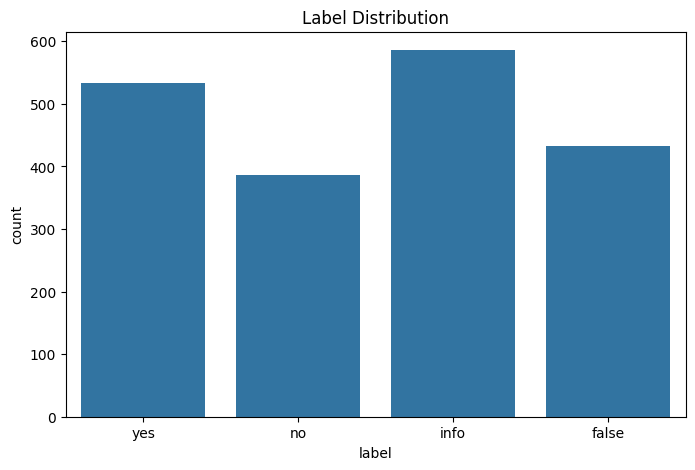

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

# 2. 라벨 분포 확인 (균형성)
print("--- [1. Label Distribution] ---")
print(df['label'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', order=['yes', 'no', 'info', 'false'])
plt.title("Label Distribution")
plt.savefig("label_distribution.png")

In [6]:
pivot = df.groupby(["title", "label"]).size().unstack(fill_value=0)
print(pivot)
need_aug_idx = pivot[(pivot["yes"]<=1) | (pivot["no"]<=1) | (pivot["false"] <=1)]

print(len(pivot))
print(len(need_aug_idx))

label                                               false  info  no  yes
title                                                                   
E-BOOK 리더기(크레마)에서 YES24 서비스가 안되는 경우                     1     7   4    0
가족회원이 무엇인가요?                                            2     3   3    4
가좌도서관 위치 및 전화번호가 어떻게 되나요?                               2     5   0    5
가좌도서관 이용시간이 어떻게 되나요?                                    1     3   3    3
가좌도서관 휴관일은 언제인가요?                                       2     7   2    1
...                                                   ...   ...  ..  ...
화정어린이도서관 이용시간이 어떻게 되나요?                                 1     3   3    5
화정어린이도서관 휴관일은 언제인가요?                                    1     6   2    3
회원증은 도서관마다 각각 만들어야 하나요? 또, 회원증을 분실한 경우에는 어떻게 해야...      3     4   1    4
회원증을 대리발급 할 수 있나요?                                      1     5   4    3
희망도서 신청은 어떻게 하며, 도서구입은 얼마나 자주하나요?                       1     3   4    4

[106 rows x 4 columns]
106
88


In [11]:
def generate_targeted_data(faq_content, target_labels):
    # 필요한 라벨에 대한 가이드라인 / 예시만 프롬프트로 넣어서, 다른 예시가 생성되지 않도록 하기
    all_guidelines = {
        "yes" : "질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n - 문구: '네, 가능합니다! 도서관 규정에 따르면...'\n - 활용: 질문의 조건이 FAQ와 일치할 때 사용.\n",
        "no" : "질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n - 문구: '죄송하지만 어렵습니다. 그 이유는...'\n - 활용: 질문의 조건이 FAQ 규정에 어긋날 때 사용. '사실과 다르다'는 표현 대신 '규정상 어렵다'를 사용하세요.\n",
        "info" : "질문이 '~은 무엇인가요?', '~은 어떻게 하나요?', '~은 언제인가요?'처럼 절차/시간/방법을 물을 때 사용하세요.\n 문구: '문의하신 내용에 대해 안내해 드리겠습니다. 관련 서류는...'\n - 활용: 네/아니오 판단이 아닌 정보 질문에 사용.\n",
        "false" : "문구: '죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.'\n - 활용: FAQ에 없는 내용이거나 질문이 모호할 때 사용.\n\n"
    }
    selected_guidelines = "\n".join([all_guidelines[l] for l in target_labels if l in all_guidelines])

    all_examples = {
        "yes": '{"question": "임산부인데 남편이 대신 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함됩니다.", "label": "yes"}',
        "no": '{"question": "성인 직장인인데 친구가 대신 가도 되나요?", "answer": "죄송하지만, 해당 조건으로는 대리 발급이 어렵습니다. 대리 발급은 아동, 어르신, 장애인, 임산부로 대상이 제한되어 있기 때문입니다.", "label": "no"}',
        "info": '{"question": "장애인 대리 발급 시 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 장애인 복지카드 또는 장애인 증명서를 지참하시면 됩니다.", "label": "info"}',
        "false": '{"question": "도서관 근처에 맛있는 식당이 어디인가요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", "label": "false"}'
    }   

    target_str = ", ".join(target_labels)
    selected_examples = ",\n      ".join([all_examples[l] for l in target_labels if l in all_examples])
    system_message = (
        f"당신은 도서관 FAQ 데이터를 바탕으로 부족한 유형의 학습 데이터를 보충하는 전문가입니다.\n"
        f"제공된 정보를 분석하여 반드시 다음 라벨에 해당하는 데이터만 생성하세요 : **[{target_str}]**\n\n"
        f"이때 판단이 쉬운 예시와 보통, 어려운 예시 총 3가지 상황을 가정하세요."
        f"각 라벨마다 최소 2~3개의 답변을 생성하세요"
        
        f"### [답변 가이드라인]\n{selected_guidelines}\n\n"
        "모든 답변은 실제 도서관 사서가 방문객에게 설명하듯 친절하고 자연스러운 문장으로 작성하세요."
        f"**[{target_str}]**에 해당하지 않는 라벨은 절대로 생성하지 마세요"
        "판단 불가의 경우 문구 외에 다른 문장은 생성하지 마세요."
        "JSON 답변 외에 다른 문장은 일체 생성하지 마세요."
    )

    # 사용자가 정의한 user_content
    user_content = f"""
    [도서관 FAQ 정보]
    {faq_content}
    
    위 정보를 바탕으로 질문과 답변이 논리적으로 완벽하게 이어지는 JSON 데이터를 생성하세요.
    
    [출력 예시]:
    {selected_examples}
    """
    
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_content},
    ]

    print(messages)

    prompt = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )

    outputs = pipe(
        prompt, 
        max_new_tokens=2048, 
        do_sample=True, 
        temperature=0.7,
        truncation=True,
        eos_token_id=tokenizer.eos_token_id
    )

    # 생성된 텍스트 추출 (결과값만 깔끔하게 가져오기 위해 prompt 이후 내용만 슬라이싱)
    full_text = outputs[0]["generated_text"]
    response = full_text.split("[|assistant|]")[-1].strip()
    
    return response

In [12]:
# 각 행마다 부족한 데이터 유형을 확인하여 데이터 증강

from tqdm import tqdm

output_file = "augmented_library_faq.jsonl"
target_titles = need_aug_idx.index.tolist()

with open(output_file, "a", encoding="utf-8") as f :
    pbar = tqdm(target_titles, desc="타겟 라벨 보충")
    
    for title in pbar :
        current = pivot.loc[title]
        missing_labels_list = [label for label in ["yes", "no", "false"] if current[label] <= 3]
    
        if not missing_labels_list :
            continue
    
        missing_labels = ", ".join(missing_labels_list)
        pbar.set_postfix(FAQ=title[:10] + "..", Labels=missing_labels)
        
        faq_data = [x for x in dataset if x["TITLE"] == title][0]
        faq_content = faq_data["DES"]

        try :
            raw_output = generate_targeted_data(faq_content, missing_labels_list)
            print(raw_output)
            parsed_list = parse_generated_json(raw_output)

            for item in parsed_list :
                item["title"] = title
                item["faq"] = 
                item["augmented"] = True

                f.write(json.dumps(item, ensure_ascii=False) + "\n")
        except Exception as e:
            tqdm.write(f"\n[에러 발생] {title}: {e}")
            continue

SyntaxError: invalid syntax (868370360.py, line 31)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

data = []
with open("augmented_library_faq.jsonl", "r", encoding="utf-8") as f :
    for line in f :
        data.append(json.loads(line))

df = pd.DataFrame(data)

In [8]:
# 생성된 데이터 확인 (결측치 확인 및 데이터 보강을 위함)

print(df["label"].value_counts())
print("-----")
print(df.isnull().sum())
print("-----")
print(df.info())

label
info     593
yes      533
false    435
no       388
Name: count, dtype: int64
-----
question        2
answer         16
label           1
faq             0
title         678
답변           1943
augmented    1272
dtype: int64
-----
<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1934 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   답변         7 non-null      str   
 6   augmented  678 non-null    object
dtypes: object(2), str(5)
memory usage: 701.6+ KB
None


In [9]:
import pandas as pd

if "답변" in df.columns :
    df["answer"] = df["answer"].fillna(df["답변"])
    df = df.drop(columns=["답변"])

print(df.info())
print(df.isnull().sum())

<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1941 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   augmented  678 non-null    object
dtypes: object(2), str(4)
memory usage: 686.1+ KB
None
question        2
answer          9
label           1
faq             0
title         678
augmented    1272
dtype: int64


In [10]:
df = df.dropna(subset=["question", "answer", "label"])
df = df.reset_index(drop=True) # drop된 행의 인덱스를 다시 매기기

print(df.info()) 

<class 'pandas.DataFrame'>
RangeIndex: 1939 entries, 0 to 1938
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1939 non-null   str   
 1   answer     1939 non-null   str   
 2   label      1939 non-null   str   
 3   faq        1939 non-null   object
 4   title      1262 non-null   str   
 5   augmented  677 non-null    object
dtypes: object(2), str(4)
memory usage: 683.9+ KB
None


--- [1. Label Distribution] ---
label
info     586
yes      533
false    433
no       387
Name: count, dtype: int64


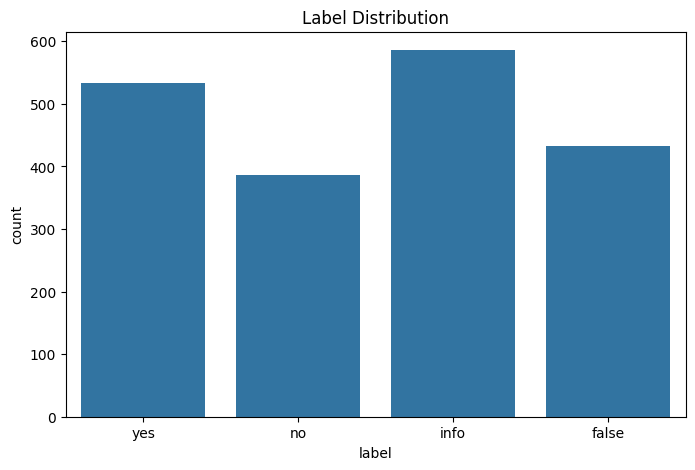

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

# 2. 라벨 분포 확인 (균형성)
print("--- [1. Label Distribution] ---")
print(df['label'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', order=['yes', 'no', 'info', 'false'])
plt.title("Label Distribution")
plt.savefig("label_distribution.png")

In [14]:
import pandas as pd

id_to_des = {x['FAQ']: x['DES'] for x in dataset}
title_to_des = {x['TITLE']: x['DES'] for x in dataset}

def recovery_des(faq_val):
    # 만약 숫자라면 (원본 FAQ 번호인 경우)
    if isinstance(faq_val, (int, float)) or (str(faq_val).isdigit()):
        return id_to_des.get(int(faq_val), "본문 없음")
    # 만약 문자열이라면 (실수로 들어간 TITLE인 경우)
    else:
        return title_to_des.get(faq_val, "본문 없음")

df['description'] = df['faq'].apply(recovery_des) # 데이터프레임에 함수 적용

KeyError: 'faq'

In [17]:
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 1939 entries, 0 to 1938
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     1939 non-null   str   
 1   answer       1939 non-null   str   
 2   label        1939 non-null   str   
 3   faq          1939 non-null   object
 4   title        1262 non-null   str   
 5   augmented    677 non-null    object
 6   description  1939 non-null   str   
dtypes: object(2), str(5)
memory usage: 1.3+ MB
None


In [7]:
# 결측치 처리 및 데이터 증강 이후 파인튜닝

In [18]:
# 3. 학습 시킬 모델 불러오기

from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig, 
    TrainingArguments,
)
from datasets import Dataset
import os, torch, json, wandb, subprocess
from sklearn.model_selection import train_test_split
import torch.nn as nn
from peft import (
    get_peft_model,
    LoraConfig, 
    TaskType,
    prepare_model_for_kbit_training
)

In [19]:
# 모델 및 토크나이저 불러오기

model_id = "/home/vsc/LLM/model/EXAONE-3.5-7.8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

print(model)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

ExaoneForCausalLM(
  (transformer): ExaoneModel(
    (wte): Embedding(102400, 4096, padding_idx=0)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x ExaoneBlock(
        (ln_1): ExaoneRMSNorm()
        (attn): ExaoneAttention(
          (attention): ExaoneSdpaAttention(
            (rotary): ExaoneRotaryEmbedding()
            (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
          )
        )
        (ln_2): ExaoneRMSNorm()
        (mlp): ExaoneGatedMLP(
          (c_fc_0): Linear(in_features=4096, out_features=14336, bias=False)
          (c_fc_1): Linear(in_features=4096, out_features=14336, bias=False)
          (c_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act): SiLU

In [20]:
# LoRA를 붙힐 레이어의 명칭을 찾아주는 코드

def find_all_linear_names(model):
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)
 
modules = find_all_linear_names(model)
print(modules)

['k_proj', 'v_proj', 'q_proj', 'c_proj', 'out_proj', 'c_fc_0', 'c_fc_1']


In [21]:
# 어떤 부분을 학습하냐에 따라서도 결과 값이 달라짐
modules = ["q_proj", "k_proj", "v_proj", "out_proj"]

# 변경 가능한 파라미터들
peft_config = LoraConfig(
    task_type="CAUSAL_LM", #CAUSAL_LM, FEATURE_EXTRACTION, QUESTION_ANS, SEQ_2_SEQ_LM, SEQ_CLS, TOKEN_CLS.
    inference_mode=False, # 학습 중에는 False로 두어야 가중치 업데이트 가능
    r=32, # r은 보통 2의 배수로 두는데, r이 클수록 학습 가능한 파라미터의 수가 더 많아짐
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=modules
)

print(peft_config)

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=32, target_modules={'k_proj', 'out_proj', 'v_proj', 'q_proj'}, lora_alpha=16, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))


In [22]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 27,262,976 || all params: 7,845,711,872 || trainable%: 0.3475


In [16]:
df['faq'] = df['faq'].astype(str)
hf_dataset = Dataset.from_pandas(df[["question", "answer","description"]])
seed = 42

ds_split = hf_dataset.train_test_split(test_size=0.2, seed=seed)
train_val_split = ds_split["train"].train_test_split(test_size = 0.3, seed=seed)

from datasets import DatasetDict

final_dataset = DatasetDict({
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': ds_split['test']
})

print(final_dataset)
print(final_dataset['train'][0])

KeyError: 'faq'

In [31]:
train_dataset, val_dataset, test_dataset = final_dataset['train'], final_dataset['val'], final_dataset['test']
print(train_dataset)

Dataset({
    features: ['question', 'answer', 'description'],
    num_rows: 1085
})


In [35]:
def generate_prompts(examples):
    prompt_list = []
    system_message = (
        "당신은 도서관 운영에 대한 전문적인 지식을 가진 인공지능 사서입니다."
        "제공된 [도서관 정보]를 바탕으로 사용자의 질문에 정확하고 친절하게 답하십시오. "
        "정보에 없는 내용은 함부로 추측하지 말고 정중히 확인이 어렵다고 답하세요."
    )
    
    for i in range(len(examples['question'])):
        question = examples["question"][i]
        answer = examples["answer"][i]
        context = examples["description"][i]

        user_content = (
            f"### [도서관 정보]\n{context}\n\n"
            f"### [질문]\n{question}\n\n"
            f"### [지시 사항]\n"
            f"1. 친절한 말투로 규정에 근거하여 답변할 것.\n"
            f"2. 3문단 이내로 답변할 것.\n"
            f"3. 답변 끝에 지시 사항을 반복하지 말 것."
        )

        # 채팅 템플릿 구성
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_content},
            {"role": "assistant", "content": answer}
        ]

        full_prompt = tokenizer.apply_chat_template(
            messages, 
            tokenize=False, 
            add_generation_prompt=False
        )
        
        prompt_list.append(full_prompt)
    
    return prompt_list

In [36]:
# max_length 결정 (GPU Util을 최적화 하기 위함)

def generate_prompts_test(example) :
    system_message = (
        "당신은 도서관 운영에 대한 전문적인 지식을 가진 인공지능 사서입니다."
        "제공된 [도서관 정보]를 바탕으로 사용자의 질문에 정확하고 친절하게 답하십시오. "
        "정보에 없는 내용은 함부로 추측하지 말고 정중히 확인이 어렵다고 답하세요."
    )
    
    question = example["question"]
    answer = example["answer"]
    context = example["description"]

    user_content = (
            f"### [도서관 정보]\n{context}\n\n"
            f"### [질문]\n{question}\n\n"
            f"### [지시 사항]\n"
            f"1. 친절한 말투로 규정에 근거하여 답변할 것.\n"
            f"2. 3문단 이내로 답변할 것.\n"
            f"3. 답변 끝에 지시 사항을 반복하지 말 것."
        )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_content},
        {"role": "assistant", "content": answer}
    ]

    full_prompt = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=False
    )
    
    return {"text": full_prompt}

train_prompts, val_prompts = train_dataset.map(generate_prompts_test), val_dataset.map(generate_prompts_test)

import numpy as np

token_lengths = [len(tokenizer.encode(p["text"])) for p in train_prompts] + [len(tokenizer.encode(p["text"])) for p in val_prompts]

print(f"최대 토큰 길이: {np.max(token_lengths)}")
print(f"평균 토큰 길이: {np.mean(token_lengths):.2f}")
print(f"95번째 백분위수 (P95): {np.percentile(token_lengths, 95)}")
print(f"99번째 백분위수 (P99): {np.percentile(token_lengths, 99)}")

Map:   0%|          | 0/1085 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

최대 토큰 길이: 770
평균 토큰 길이: 294.52
95번째 백분위수 (P95): 427.5
99번째 백분위수 (P99): 729.0


In [37]:
# 학습을 기록할 wanDB notebook 설정

import os
from datetime import datetime

wandb.finish()

os.environ["WANDB_PROJECT"] = "PromptTuning" # 프로젝트 이름
os.environ["WANDB_RUN_ID"] = "library_QA_v1" # 노트북 고유 ID
os.environ["WANDB_RESUME"] = "allow" # 해당 노트북에서 학습을 이어서 진행할 것인지

wandb.init(
    project=os.environ["WANDB_PROJECT"],
    id=os.environ["WANDB_RUN_ID"],
    resume=os.environ["WANDB_RESUME"],
    name=datetime.now().strftime("%Y-%m-%d %H:%M:%S") # 대시보드에 표시될 이름
)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/vsc/.netrc.
wandb: Currently logged in as: jungseonglian (uailab-unist_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [40]:
# 먼저 1 epoch로 훈련 -> 추론이 잘 이루어지는지 확인
# 이후 epoch를 늘려 과적합이 일어날 때 까지 학습하는 것이 좋음

from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM # 오직 답변 부분에 대해서만 손실 계산
from datetime import datetime

response_template = "[|assistant|]" # EXAONE 기준 response_template
data_collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template, 
    tokenizer=tokenizer
)

training_args = SFTConfig(
    output_dir="./SFT",
    save_strategy="steps",
    save_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    max_seq_length=1024,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    load_best_model_at_end=True,
    optim="paged_adamw_32bit", # 일반적으로 adam 계열 사용, paged_adamw_32bit는 GPU 메모리 부담을 줄이기 위해 CPU 메모리르 확장 사용 기법
    logging_dir="./logs",
    logging_steps=11,
    warmup_steps=10, # 0부터 목표 lr까지 선형적으로 늘리는 steps 기간 결정 (학습 초기에 큰 lr을 사용하면 발산할 수 있기 때문)
    logging_strategy="steps",
    learning_rate=5e-5,
    group_by_length=True, # 길이가 비슷한 샘플을 함께 배치 함으로써 메모리 사용 최적화
    bf16=True,
    fp16=False,
    report_to="wandb",
    run_name=f"{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=training_args,
    data_collator=data_collator,
    formatting_func=generate_prompts,
)

Map:   0%|          | 0/1085 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

In [ ]:
import torch
from functools import partial

# PyTorch 2.6 이상 버전에서 trainer.train(resume_from_checkpoint=True)을 하고 싶다면 해주어야 함
# torch.load의 기본값을 weights_only=False로 수정
torch.load = partial(torch.load, weights_only=False)

final_save_path = "./SFT/final"
os.makedirs(final_save_path, exist_ok=True)
trainer.train()
# trainer.train(resume_from_checkpoint=True) # 이어서 학습을 진행하고 싶은 경우, 가장 마지막 checkpoint-XX를 불러와서 학습이 진행된다

trainer.save_model(final_save_path)
tokenizer.save_pretrained(final_save_path)
wandb.finish()

Step,Training Loss,Validation Loss
